<a href="https://colab.research.google.com/github/Lucchh/eilof/blob/main/EILOF_Experiment_Results_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EILOF & ILOF Research Code

In this notebook, we demonstrate:

1. **Generating synthetic data** for incremental outlier detection.
2. **Implementing** and **incrementally updating** **ILOF** and **EILOF** algorithms.
3. **Visualizing** performance metrics across different k values and thresholds.
4. **Applying** these methods to real-world datasets (Shuttle, Credit Card Fraud) as examples.



In [3]:
!pip install EILOF
from eilof import *
# from google.colab import files add this if using colab

import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator

  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6


## **Methodology**

### **Algorithms**

- **Incremental Local Outlier Factor (ILOF)**:
  Computes the Local Outlier Factor (LOF) for a dataset and updates incrementally as new points are added. https://ieeexplore.ieee.org/document/4221341

- **Enhanced Incremental LOF (EILOF)**:
  An optimized algorithm designed to handle large datasets more efficiently by reducing computational overhead.


It might be confusing later, as we used the Local Outlier Factor (LOF) to calculate instead of the Incremental Local Outlier Factor (ILOF) for the selected
𝑚
m (incremental points) in its visualization. However, the results of using ILOF and LOF are exactly the same, as confirmed by https://ieeexplore.ieee.org/document/4221341.


### ILOF Algorithm



In [151]:
# Helper functions
def compute_reachability_distance(dist_matrix: np.ndarray, k: int) -> np.ndarray:
    """
    Compute the reachability distance for each point.
    Args:
        dist_matrix (array): Pairwise distance matrix.
        k (int): Number of neighbors.
    Returns:
        array: Reachability distance matrix.
    """
    reach_dist_matrix = np.zeros_like(dist_matrix)
    kth_distances = np.sort(dist_matrix, axis=1)[:, k]
    for i in range(len(dist_matrix)):
        for j in range(len(dist_matrix)):
            if i != j:
                reach_dist_matrix[i, j] = max(dist_matrix[i, j], kth_distances[j])
    return reach_dist_matrix


def incremental_lof(updated_data: np.ndarray,
                    k: int,
                    new_point: np.ndarray,
                    reachability_dist: np.ndarray) -> tuple:
    """
    Incrementally update the LOF (Local Outlier Factor) for a new incoming point.

    Parameters
    ----------
    updated_data : np.ndarray
        The current data array (without the new point).
    k : int
        Number of neighbors considered in LOF.
    new_point : np.ndarray
        The new data point to be inserted incrementally.
    reachability_dist : np.ndarray
        Reachability distance matrix from the previous iteration.

    Returns
    -------
    lof_scores : np.ndarray
        Updated LOF scores including the new point.
    reachability_dist : np.ndarray
        Updated reachability distance matrix.
    lrd_sum_all : np.ndarray
        Updated array of local reachability density for all points.
    """
    dist_matrix = cdist(updated_data, updated_data, 'euclidean') #orginal distance matrix
    k_th_dist_og = np.sort(dist_matrix, axis=1)[:, k]

    distance_new = compute_distances(updated_data, new_point) #calculate the distance of new point to other points

    updated_data = np.append(updated_data, [new_point], axis=0) #update the data
    k_nearest_neib_new = np.sort(distance_new)[k-1]
    k_nearest_index = np.argsort(distance_new)[k-1]
    # Compute reachability distance from new point to its k-nearest neighbors
    dist_matrix_new = cdist(updated_data, updated_data, 'euclidean') #new distance matrix
    # Compute the sorted indices (k-nearest neighbors) for the new point
    k_nearest_indices_new = np.argsort(dist_matrix_new)[:, 1:k+1][-1]

    neighbors_new = k_nearest_neighbors(dist_matrix_new, k)
    kth_distances_new = np.sort(dist_matrix_new, axis=1)[:, k]
    reachability_distance_new = []
    kth_distances = np.sort(dist_matrix, axis=1)[:, k]

    reachability_dist = np.pad(reachability_dist, ((0, 1), (0, 1)), mode='constant', constant_values=0)

    for i in k_nearest_indices_new:
        reach_dist = max(kth_distances_new[i], distance_new[i])
        reachability_distance_new.append(reach_dist)
        reachability_dist[-1, i] = reach_dist


    #get the KRNN
    KRNN = np.nonzero(distance_new < k_th_dist_og)[0]
    for i in KRNN:
        # Check the condition to update k-distance based on the new point
        if distance_new[i] < np.sort(dist_matrix, axis=1)[i][k] and distance_new[i] > np.sort(dist_matrix, axis=1)[i][k-1]:
            k_th_dist_og[i] = distance_new[i]
        elif distance_new[i] <= np.sort(dist_matrix, axis=1)[i][k-1]:
            k_th_dist_og[i] = np.sort(dist_matrix, axis=1)[i][k-1]
    K_update_dis = np.append(k_th_dist_og, k_nearest_neib_new)
    S_update_lrd = set()

    S_update_lrd = set(KRNN)
    for pj in KRNN:
        # Get the k-nearest neighbors of pj excluding the new point
        neighbors_pj = [neighbor for neighbor in neighbors_new[pj] if neighbor != len(updated_data)]

        # Update reachability distances for pj and its neighbors
        for pi in neighbors_pj:
            # Calculate the reachability distance between pj and pi
            actual_dist = dist_matrix_new[pi][pj]
            k_distance_pj = K_update_dis[pj]
            reachability_dist[pi][pj] = max(actual_dist, k_distance_pj)

            # If pj is a k-nearest neighbor of pi, add pi to S_update_lrd
            if pj in neighbors_new[pi]:
                S_update_lrd.add(pi)
    # Convert S_update_lrd to a list
    S_update_lrd = list(S_update_lrd)
    value_to_remove = len(updated_data) - 1
    if value_to_remove in S_update_lrd:
        S_update_lrd.remove(value_to_remove)
    S_update_LOF = set(S_update_lrd)

    # Update the LRD for points in S_update_lrd
    for pm in S_update_lrd:
        neighbors_pm = neighbors_new[pm]
        # Exclude the new point from the neighbors, if present
        # Recalculate LRD for pm
        reach_dist_sum_pm = 0
        for neighbor in neighbors_pm:
            if neighbor  == len(updated_data) - 1 and distance_new[pm] < k_nearest_neib_new:
              reach_dist_sum_pm += k_nearest_neib_new
            elif neighbor  == len(updated_data) - 1 and distance_new[pm] >= k_nearest_neib_new:
              reach_dist_sum_pm += distance_new[pm]
            elif reachability_dist[pm][neighbor] == 0:
              reachability_dist[pm][neighbor] = max(dist_matrix_new[pm][neighbor],K_update_dis[neighbor])
              reach_dist_sum_pm += reachability_dist[pm][neighbor]
            else:
              reach_dist_sum_pm += reachability_dist[pm][neighbor]
        lrd_og[pm] = 1.0 / (reach_dist_sum_pm / k)

    KRNN = []
    for index, row in enumerate(neighbors_new):
        if any(value in row for value in S_update_lrd):
            KRNN.append(index)

    # Add the kRNN to the S_update_LOF set
    S_update_LOF.update(KRNN)

    # Convert S_update_LOF to a list
    S_update_LOF = list(S_update_LOF)


    lrd_pc = 1.0 / (sum(reachability_distance_new) / k)
    lrd_sum_all = np.append(lrd_og, lrd_pc)

    # Update the LOF for each point in S_update_LOF
    for pi in S_update_LOF:
        if pi != len(updated_data) - 1:
            neighbors_pi = neighbors_new[pi]
            sum_lrd_ratios = sum(lrd_sum_all[neighbor] for neighbor in neighbors_pi) / k
            lof_og[pi] = sum_lrd_ratios / lrd_sum_all[pi]
    average_lrd_neighbors = sum(lrd_og[neighbor] for neighbor in k_nearest_indices_new) / k
    lrd_sum_neighbors = average_lrd_neighbors / lrd_pc



    # final
    return (np.append(lof_og, lrd_sum_neighbors)), reachability_dist, lrd_sum_all

## Simulation Study


### Generating and Visualizing 2D Data

We generate 2D data with 5% outliers. The outliers are shifted by a distance of 10.

In [ ]:
np.random.seed(5)
def generate_simulation_data(n_points, outlier_ratio, dimensions, outlier_distance):

    n_outliers = int(n_points * outlier_ratio)
    n_normals = n_points - n_outliers

    # Generate normal data points around a center
    normal_data = np.random.randn(n_normals, dimensions)

    # Generate outliers
    outlier_data = np.random.randn(n_outliers, dimensions) * outlier_distance + outlier_distance

    # Combine normal data and outliers
    data = np.vstack([normal_data, outlier_data])

    # Create labels (0 for normal, 1 for outlier)
    labels = np.array([0] * n_normals + [1] * n_outliers)

    return data, labels

# 2D Data with 5% Outliers and Separation of 10
data, labels = generate_simulation_data(n_points=2280, outlier_ratio=0.05, dimensions=2, outlier_distance = 10)


### Fig. 2: Distribution of Simulated Data Points

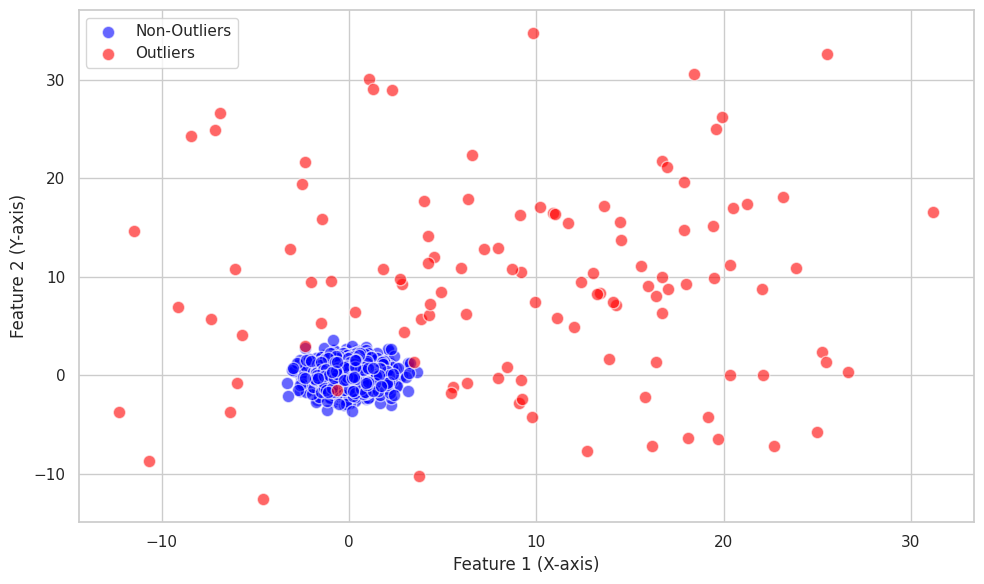

In [ ]:
# Specify the directory where the file will be saved. Enter your own directory name
save_dir = "..."
os.makedirs(save_dir, exist_ok=True)

# Extract x and y coordinates from the data
x = data[:, 0]
y = data[:, 1]

# Labels array indicating outliers (1 for outliers, 0 for normal points)
outliers = labels == 1

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.scatter(x[~outliers], y[~outliers], c='blue', alpha=0.6, edgecolors='w', s=80, label='Non-Outliers')
plt.scatter(x[outliers], y[outliers], c='red', alpha=0.6, edgecolors='w', s=80, label='Outliers')
plt.xlabel('Feature 1 (X-axis)', fontsize=12)
plt.ylabel('Feature 2 (Y-axis)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
save_path = os.path.join(save_dir, 'Distribution_of_Simulated_Data_Points.png')
plt.savefig(save_path, dpi=300)
plt.show()


### Creating Initial and Incremental Datasets

We randomly pick 1000 points as the initial “selected” dataset and use the rest as our “unselected” or incremental dataset.


In [ ]:
random.seed(5)
all_indices = list(range(0, 2280))
selected_index = random.sample(all_indices, 1000)
unselected_index = [index for index in all_indices if index not in selected_index]
random.shuffle(unselected_index)
# Use selected_index and unselected_index to get selected_data, unselected_data, selected_labels, and unselected_labels
selected_data = data[selected_index]
selected_labels = labels[selected_index]
unselected_data = data[unselected_index]
unselected_labels = labels[unselected_index]


### Fig. 3: $F_1$ by Test Index for Different $k$ Values in ILOF

We choose several k values (e.g., 25, 50, 75, 100, 125, 150) and measure F1 score incrementally.


In [ ]:
test_index = [1,5,10,20,40,80,160,320,640,1280]
k = [25,50,75,100,125,150]
total_f1_list = []
for kk in k:
    f1_list = []
    for i in test_index:
        updated_data = np.append(selected_data, unselected_data[:i], axis=0)
        lof_scores = local_outlier_factor(updated_data, kk)
        lof_mean_og = np.mean(lof_scores)
        lof_std = np.std(lof_scores)
        threshold = lof_mean_og + 2 * lof_std
        # Classify points based on the threshold
        predicted_labels = (lof_scores > threshold).astype(int)
        labels_update = np.append(selected_labels, unselected_labels[0:i])

        # Calculate F1 score and accuracy
        f1 = f1_score(labels_update, predicted_labels)
        accuracy = accuracy_score(labels_update, predicted_labels)
        f1_list.append(f1)
    total_f1_list.append(f1_list)


<ipython-input-6-ff13b6c57596>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

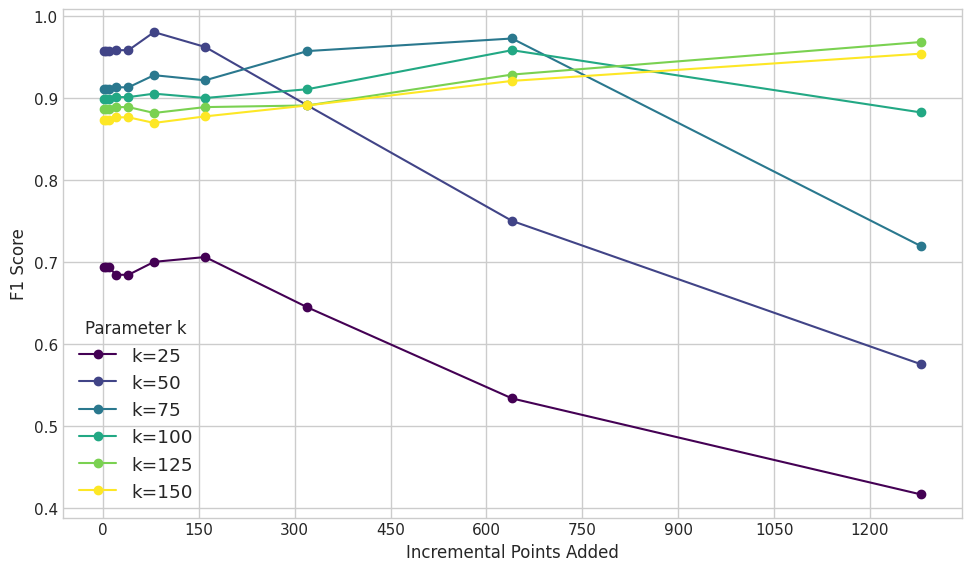

In [ ]:
# Set the style for the plot to be suitable for formal presentations/publications
plt.style.use('seaborn-v0_8-whitegrid')

# Set the font properties that will be used for the plot
font = {'family': 'Times New Roman', 'weight': 'normal', 'size': 16}

plt.rc('font', **font)  # Apply the font properties

# Create a figure and axis with the desired size for publication
fig, ax = plt.subplots(figsize=(10, 6))

# Define a color map with a professional appearance
colors = plt.cm.viridis(np.linspace(0, 1, len(k)))
x
# Create the line plot for each array in total_f1_list
for i, f1_array in enumerate(total_f1_list):
    ax.plot(test_index, f1_array, marker='o', linestyle='-', color=colors[i], label=f'k={k[i]}')

ax.set_xlabel('Incremental Points Added')
ax.set_ylabel('F1 Score')
#ax.set_title('F1 Score by Test Index for Different k Values')
ax.legend(title='Parameter k', loc='best', fontsize='small')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_axisbelow(True)
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('F1 Score by Test Index for Different k Values.png', dpi=300)  # Save the figure with a DPI of 300
files.download('F1 Score by Test Index for Different k Values.png')  # Prompt to download the file to your local machine




plt.show()  # Show the plot as the last step


### Fig. 4: $F_{1}$ Score by $k$ for Different Sizes of Incremental Data Points ($m$) in ILOF

In [ ]:
test_index = [80,160,320,640,1280]
k = [25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175]
total_f1_list = []
for kk in k:
    f1_list_test = []
    for i in test_index:
        updated_data = np.append(selected_data, unselected_data[:i], axis=0)
        testttttt = local_outlier_factor(updated_data, kk)
        lof_mean_og = np.mean(testttttt)
        lof_std = np.std(testttttt)
        threshold = lof_mean_og + 2 * lof_std
        # Classify points based on the threshold
        predicted_label_test = (testttttt > threshold).astype(int)
        labels_update = np.append(selected_labels, unselected_labels[0:i])

        # Calculate F1 score and accuracy
        f1 = f1_score(labels_update, predicted_label_test)
        accuracy = accuracy_score(labels_update, predicted_label_test)
        f1_list_test.append(f1)
    total_f1_list.append(f1_list_test)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

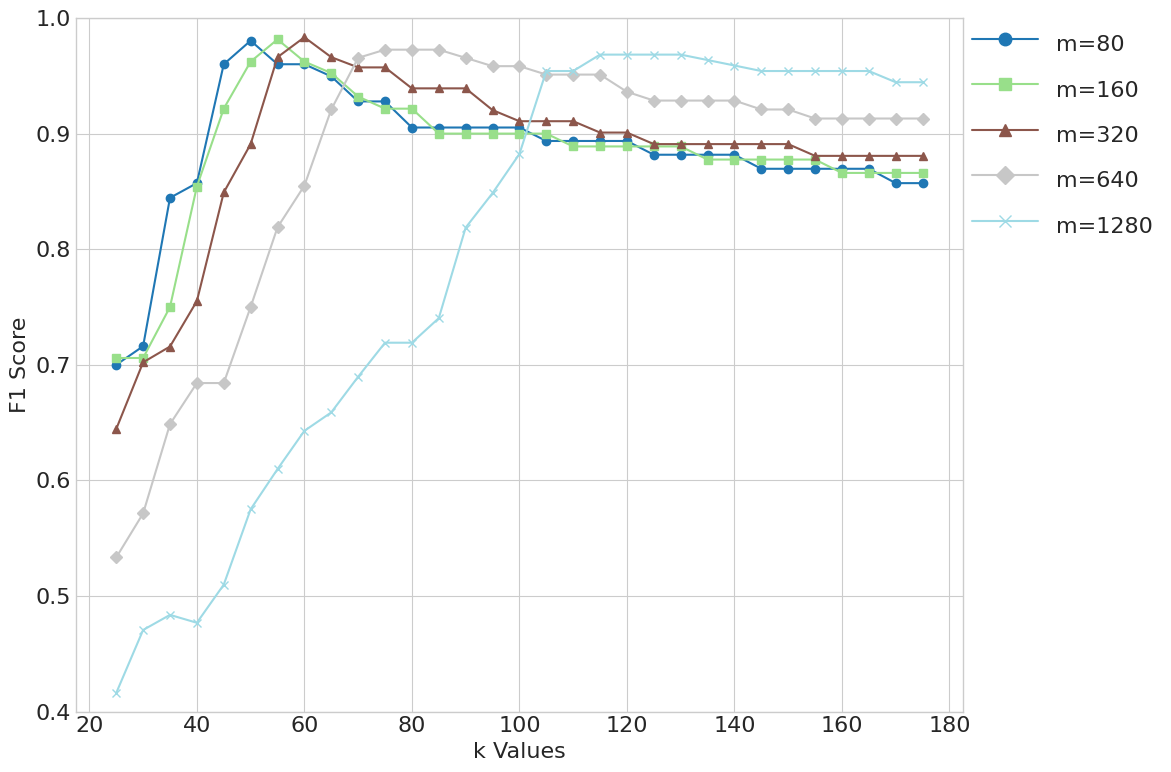

In [ ]:
test_index = [80, 160, 320, 640, 1280]
k = [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175]
colors = plt.cm.tab20(np.linspace(0, 1, len(test_index)))
plt.figure(figsize=(12, 8))

line_styles = ['-']
markers = ['o', 's', '^', 'D', 'x', '+', '*', '<', '>', 'p', 'P', 'h', 'H', 'X', '|', '_']

# Create the line plot for each value in test_index
for i, m in enumerate(test_index):
    ls = line_styles[i % len(line_styles)]
    mk = markers[i % len(markers)]
    plt.plot(k, np.array(total_f1_list)[:,i], marker=mk, linestyle=ls, color=colors[i % len(colors)], label=f'm={m}')

plt.xlabel('k Values', fontsize=16)  # Increase font size for x-axis label
plt.ylabel('F1 Score', fontsize=16)  # Increase font size for y-axis label
plt.xticks(fontsize=16)  # Increase font size for x-axis tick labels
plt.yticks(fontsize=16)  # Increase font size for y-axis tick labels

plt.ylim(0.4, 1.0)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=16, markerscale=1.5, handlelength=3, handleheight=2, shadow=True, frameon=False)
plt.tight_layout()  # Adjust the padding to fit the legend and prevent clipping
plt.grid(True)


# Save the figure with high resolution
plt.savefig('F1 Score by k for Different Sizes of Incremental Data Points (m).png', dpi=300)  # Save the figure with a DPI of 300
from google.colab import files
files.download('F1 Score by k for Different Sizes of Incremental Data Points (m).png')
plt.show()


### Fig. 5: $F_1$ by Test Index for Different $k$ Values in EILOF

In [ ]:
# Initialize variables
test_index = range(0, 1280)
indices = [80, 160, 320, 640, 1280]
f1_total = []
k_values = [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175]

# Loop through each k value
for k in k_values:
    # Initialize EILOF model
    model = EILOF(k=k)
    # Fit the model on the selected data
    model.fit(selected_data)
    f1_new_list = []
    data_copy = selected_data
    # Loop through test indices
    for i in test_index:
        new_point = unselected_data[i]
        # Update the model incrementally with the new point
        model.update([new_point])
        # Calculate threshold based on LOF mean and standard deviation
        lof_mean_incremental = np.mean(model.lof_scores)
        lof_std_incremental = np.std(model.lof_scores)
        threshold_incremental_new = lof_mean_incremental + 2 * lof_std_incremental
        # Classify points based on the threshold
        predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)
        # Update the labels
        labels_update = np.append(selected_labels, unselected_labels[:i+1])
        # Calculate F1 score
        f1 = f1_score(labels_update, predicted_labels)
        f1_new_list.append(f1)
    selected_values = [f1_new_list[i-1] for i in indices]
    f1_total.append(selected_values)

In [ ]:
f1_total

[[0.7,
  0.7058823529411765,
  0.7021276595744681,
  0.6486486486486487,
  0.5534591194968553],
 [0.7317073170731707,
  0.735632183908046,
  0.7422680412371134,
  0.6956521739130435,
  0.6097560975609756],
 [0.8444444444444444,
  0.8421052631578947,
  0.8490566037735849,
  0.7804878048780488,
  0.6820809248554913],
 [0.8936170212765957,
  0.8888888888888888,
  0.8909090909090909,
  0.8372093023255814,
  0.7675675675675676],
 [0.9702970297029703,
  0.9622641509433962,
  0.9482758620689655,
  0.9130434782608695,
  0.8247422680412371],
 [0.96,
  0.9523809523809523,
  0.9661016949152542,
  0.9361702127659575,
  0.8484848484848485],
 [0.96,
  0.9523809523809523,
  0.9572649572649573,
  0.9436619718309859,
  0.8656716417910447],
 [0.96,
  0.9523809523809523,
  0.9572649572649573,
  0.9285714285714286,
  0.8484848484848485],
 [0.9387755102040817,
  0.9423076923076923,
  0.9482758620689655,
  0.951048951048951,
  0.8656716417910447],
 [0.9278350515463918,
  0.9215686274509803,
  0.939130434782

### Fig. 6: $F_{1}$ Score by $k$ for Different Sizes of Incremental Data Points ($m$) in EILOF

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

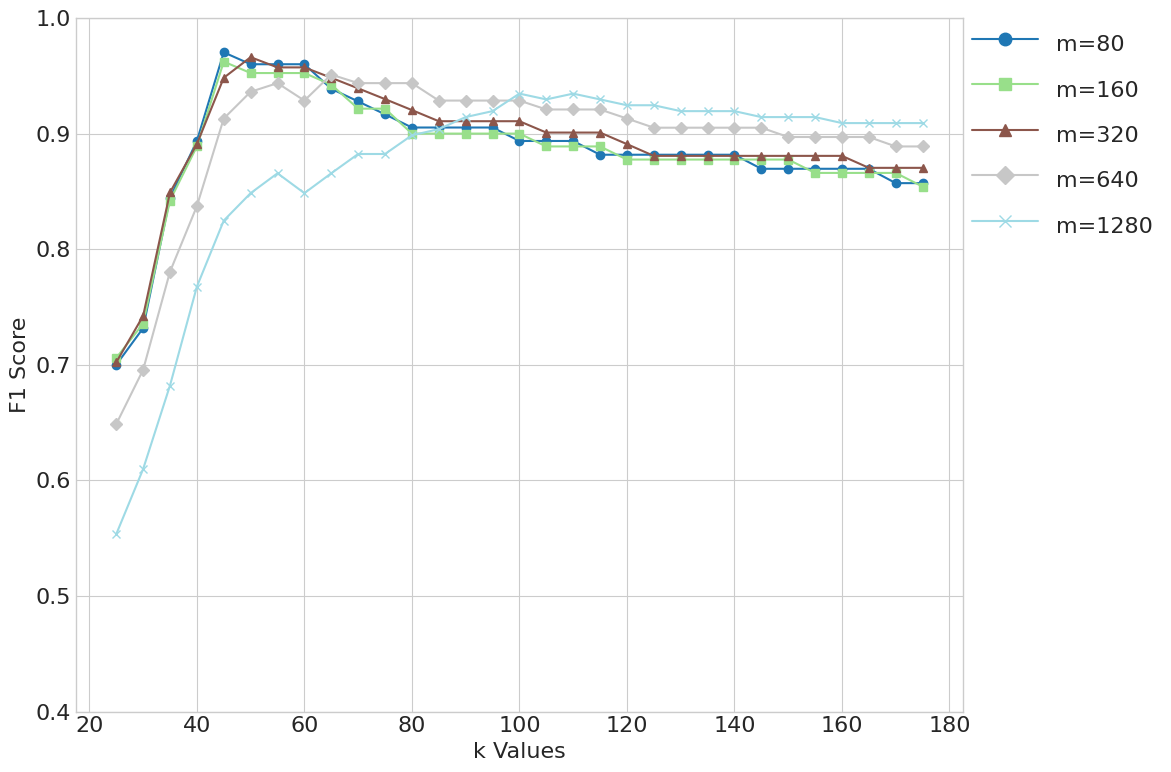

In [ ]:
test_index = [80, 160, 320, 640, 1280]
k = [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175]

colors = plt.cm.tab20(np.linspace(0, 1, len(test_index)))

plt.figure(figsize=(12, 8))

line_styles = ['-']
markers = ['o', 's', '^', 'D', 'x', '+', '*', '<', '>', 'p', 'P', 'h', 'H', 'X', '|', '_']

# Create the line plot for each value in test_index
for i, m in enumerate(test_index):
    ls = line_styles[i % len(line_styles)]
    mk = markers[i % len(markers)]
    plt.plot(k, np.array(f1_total)[:,i], marker=mk, linestyle=ls, color=colors[i % len(colors)], label=f'm={m}')

plt.xlabel('k Values', fontsize=16)
plt.ylabel('F1 Score', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(0.4, 1.0)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=16, markerscale=1.5, handlelength=3, handleheight=2, shadow=True, frameon=False)
plt.tight_layout()
plt.grid(True)



# Save the figure with high resolution
plt.savefig('F1 Score by k for Different Sizes of Incremental Data Points (m) for EILOF.png', dpi=300)
files.download('F1 Score by k for Different Sizes of Incremental Data Points (m) for EILOF.png')
plt.show()


### Fig. 7: Comparison of Incremental $F_{1}$ Scores in $2D$: ILOF vs. EILOF when $k = 50 $

#### EILOF

In [ ]:
test_index = range(0, 640)
k = 50
f1_new_list = []
accuracy_list = []
# Initialize EILOF model
model = EILOF(k=k)
# Fit the model on the selected data
model.fit(selected_data)
data_copy = selected_data

# Loop through test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold based on LOF mean and standard deviation
    lof_mean_incremental = np.mean(model.lof_scores)
    lof_std_incremental = np.std(model.lof_scores)
    threshold_incremental_new = lof_mean_incremental + 2 * lof_std_incremental

    # Classify points based on the threshold
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)

    # Update the labels
    labels_update = np.append(selected_labels, unselected_labels[:i+1])

    # Calculate F1 score and accuracy
    f1 = f1_score(labels_update, predicted_labels)
    accuracy = accuracy_score(labels_update, predicted_labels)

    # Append results to lists
    f1_new_list.append(f1)
    accuracy_list.append(accuracy)
f1_new_list

[0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333

#### ILOF

In [ ]:
test_index = range(0,640)
f1_list = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []

k = 50
dist_og = cdist(selected_data, selected_data, 'euclidean')
neighbors_og = k_nearest_neighbors(dist_og, k)
k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
chunk_size = 320
# Initialize lists to keep track of metrics
f1_list_first_half = []
accuracy_list_first_half = []

# Process the first half
for i in range(chunk_size):
    new_point = unselected_data[i]
    lof_og, reachability_dist, lrd_og = incremental_lof(data_copy, k, new_point, reachability_dist)
    data_copy = np.append(data_copy, [new_point], axis=0)

    # Update LOF metrics and thresholds
    lof_mean_incremental = np.mean(lof_og)
    lof_std_inc = np.std(lof_og)
    threshold_incremental = lof_mean_incremental + 2 * lof_std_inc

    # Predict and update labels
    predicted_labels_inc = (lof_og > threshold_incremental).astype(int)
    labels_update_inc = np.append(selected_labels, unselected_labels[:i+1])

    # Calculate metrics
    f1_inc = f1_score(labels_update_inc, predicted_labels_inc)
    accuracy_inc = accuracy_score(labels_update_inc, predicted_labels_inc)

    # Store metrics
    f1_list_first_half.append(f1_inc)
    accuracy_list_first_half.append(accuracy_inc)

# Initialize lists for the second half metrics if needed
f1_list_second_half = []
accuracy_list_second_half = []

# Process the second half
for i in range(chunk_size, 2 * chunk_size):
    new_point = unselected_data[i]
    lof_og, reachability_dist, lrd_og = incremental_lof(data_copy, k, new_point, reachability_dist)
    data_copy = np.append(data_copy, [new_point], axis=0)

    lof_mean_incremental = np.mean(lof_og)
    lof_std_inc = np.std(lof_og)
    threshold_incremental = lof_mean_incremental + 2 * lof_std_inc

    predicted_labels_inc = (lof_og > threshold_incremental).astype(int)
    labels_update_inc = np.append(selected_labels, unselected_labels[:i+1])

    f1_inc = f1_score(labels_update_inc, predicted_labels_inc)
    accuracy_inc = accuracy_score(labels_update_inc, predicted_labels_inc)

    f1_list_second_half.append(f1_inc)
    accuracy_list_second_half.append(accuracy_inc)


In [ ]:
# Combining the two F1 score lists from the first and second half
f1_list = f1_list_first_half + f1_list_second_half

# Combined lists
f1_list


[0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9574468085106383,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333

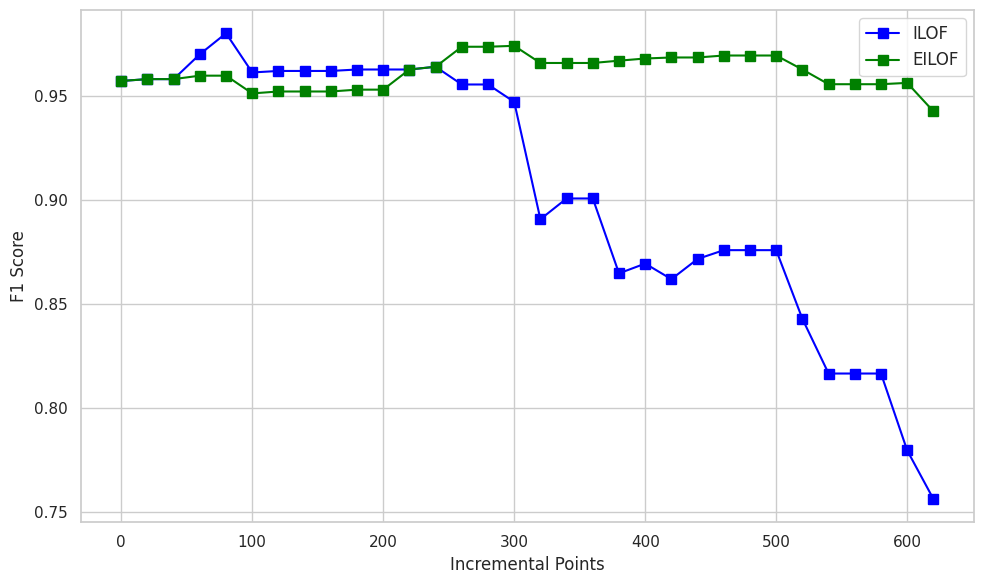

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Number of increments (x-axis)
x = range(len(f1_list))

# Select key points every 20th point for clarity
key_points = np.arange(0, len(f1_list), 20)

# Plotting the data
plt.figure(figsize=(10, 6))

# Plotting ILOF 7% and EILOF 7% with different markers
plt.plot(key_points, np.array(f1_list)[key_points], label='ILOF', marker='s', color='blue', markersize=7, linestyle='-', linewidth=1.5)
plt.plot(key_points, np.array(f1_new_list)[key_points], label='EILOF', marker='s', color='green', linestyle='-', markersize=7, linewidth=1.5)


# Adding labels, legend, and grid
plt.xlabel('Incremental Points', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('incremental_f1_scores_comparison.png', dpi=300)

# Show plot
plt.show()
files.download('incremental_f1_scores_comparison.png')

### TABLE I: F1 Scores for Different Values of k (Number of Neighbors) and m (Points Added) Across 2 and 50 Dimensions for ILOF


#### In 2 Dimensions

In [ ]:
np.random.seed(5)
def generate_simulation_data(n_points, outlier_ratio, dimensions, outlier_distance):
    n_outliers = int(n_points * outlier_ratio)
    n_normals = n_points - n_outliers
    normal_data = np.random.randn(n_normals, dimensions)

    # Calculate the rescaling factor for higher dimensions
    rescaling_factor = np.sqrt(2 / dimensions)

    # Rescale the outlier_distance
    rescaled_outlier_distance = outlier_distance * rescaling_factor

    # Generate outliers with rescaled distance
    outlier_data = np.random.randn(n_outliers, dimensions) * rescaled_outlier_distance + rescaled_outlier_distance

    # Combine normal data and outliers
    data = np.vstack([normal_data, outlier_data])

    # Create labels (0 for normal, 1 for outlier)
    labels = np.array([0] * n_normals + [1] * n_outliers)

    return data, labels

# Example usage for 50 dimensions with rescaling
data, labels = generate_simulation_data(n_points=2280, outlier_ratio=0.05, dimensions=2, outlier_distance=10)

In [ ]:
random.seed(5)
all_indices = list(range(0, 2280))
selected_index = random.sample(all_indices, 1000)
unselected_index = [index for index in all_indices if index not in selected_index]
random.shuffle(unselected_index)
# Use selected_index and unselected_index to get selected_data, unselected_data, selected_labels, and unselected_labels
selected_data = data[selected_index]
selected_labels = labels[selected_index]
unselected_data = data[unselected_index]
unselected_labels = labels[unselected_index]


In [ ]:
test_index = [1,5,10,20,40,80,160,320,640,1280]
k = [25,50,75,100,125,150]
total_f1_list = []
for kk in k:
    f1_list = []
    for i in test_index:
        updated_data = np.append(selected_data, unselected_data[:i], axis=0)
        lof_scores = local_outlier_factor(updated_data, kk)
        lof_mean_og = np.mean(lof_scores)
        lof_std = np.std(lof_scores)
        threshold = lof_mean_og + 2 * lof_std
        # Classify points based on the threshold
        predicted_labels = (lof_scores > threshold).astype(int)
        labels_update = np.append(selected_labels, unselected_labels[0:i])

        # Calculate F1 score and accuracy
        f1 = f1_score(labels_update, predicted_labels)
        accuracy = accuracy_score(labels_update, predicted_labels)
        f1_list.append(f1)
    total_f1_list.append(f1_list)
total_f1_list

[[0.6933333333333334,
  0.6933333333333334,
  0.6933333333333334,
  0.6842105263157895,
  0.6842105263157895,
  0.7,
  0.7058823529411765,
  0.6444444444444445,
  0.5333333333333333,
  0.4161073825503356],
 [0.9574468085106383,
  0.9574468085106383,
  0.9574468085106383,
  0.9583333333333334,
  0.9583333333333334,
  0.9803921568627451,
  0.9622641509433962,
  0.8909090909090909,
  0.75,
  0.575],
 [0.9111111111111111,
  0.9111111111111111,
  0.9111111111111111,
  0.9130434782608695,
  0.9130434782608695,
  0.9278350515463918,
  0.9215686274509803,
  0.9572649572649573,
  0.9726027397260274,
  0.7191011235955056],
 [0.898876404494382,
  0.898876404494382,
  0.898876404494382,
  0.9010989010989011,
  0.9010989010989011,
  0.9052631578947369,
  0.9,
  0.9107142857142857,
  0.9583333333333334,
  0.8823529411764706],
 [0.8863636363636364,
  0.8863636363636364,
  0.8863636363636364,
  0.8888888888888888,
  0.8888888888888888,
  0.8817204301075269,
  0.8888888888888888,
  0.8909090909090909,


#### In 50 Dimensions

In [ ]:
np.random.seed(5)
def generate_simulation_data(n_points, outlier_ratio, dimensions, outlier_distance):
    n_outliers = int(n_points * outlier_ratio)
    n_normals = n_points - n_outliers
    normal_data = np.random.randn(n_normals, dimensions)

    # Calculate the rescaling factor for higher dimensions
    rescaling_factor = np.sqrt(2 / dimensions)

    # Rescale the outlier_distance
    rescaled_outlier_distance = outlier_distance * rescaling_factor

    # Generate outliers with rescaled distance
    outlier_data = np.random.randn(n_outliers, dimensions) * rescaled_outlier_distance + rescaled_outlier_distance

    # Combine normal data and outliers
    data = np.vstack([normal_data, outlier_data])

    # Create labels (0 for normal, 1 for outlier)
    labels = np.array([0] * n_normals + [1] * n_outliers)

    return data, labels

# Example usage for 50 dimensions with rescaling
data, labels = generate_simulation_data(n_points=2280, outlier_ratio=0.05, dimensions=50, outlier_distance=10)

In [ ]:
random.seed(5)
all_indices = list(range(0, 2280))
selected_index = random.sample(all_indices, 1000)
unselected_index = [index for index in all_indices if index not in selected_index]
random.shuffle(unselected_index)
# Use selected_index and unselected_index to get selected_data, unselected_data, selected_labels, and unselected_labels
selected_data = data[selected_index]
selected_labels = labels[selected_index]
unselected_data = data[unselected_index]
unselected_labels = labels[unselected_index]


In [ ]:
test_index = [1,5,10,20,40,80,160,320,640,1280]
k = [25,50,75,100,125,150]
total_f1_list = []
for kk in k:
    f1_list = []
    for i in test_index:
        updated_data = np.append(selected_data, unselected_data[:i], axis=0)
        lof_scores = local_outlier_factor(updated_data, kk)
        lof_mean_og = np.mean(lof_scores)
        lof_std = np.std(lof_scores)
        threshold = lof_mean_og + 2 * lof_std
        # Classify points based on the threshold
        predicted_labels = (lof_scores > threshold).astype(int)
        labels_update = np.append(selected_labels, unselected_labels[0:i])

        # Calculate F1 score and accuracy
        f1 = f1_score(labels_update, predicted_labels)
        accuracy = accuracy_score(labels_update, predicted_labels)
        f1_list.append(f1)
    total_f1_list.append(f1_list)


In [ ]:
total_f1_list

[[0.7901234567901235,
  0.7901234567901235,
  0.7901234567901235,
  0.7654320987654321,
  0.7654320987654321,
  0.7469879518072289,
  0.735632183908046,
  0.7291666666666666,
  0.6956521739130436,
  0.5925925925925926],
 [0.9791666666666666,
  0.9791666666666666,
  0.9791666666666666,
  0.9690721649484536,
  0.9690721649484536,
  0.9166666666666666,
  0.888888888888889,
  0.8909090909090909,
  0.8372093023255813,
  0.7472527472527472],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9864864864864865,
  0.8307692307692308],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.919431279620853],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9866666666666666],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]

### TABLE II: F1 Scores for Different Values of k (Number of Neighbors) and m (Points Added) Across 2 and 50 Dimensions for EILOF


#### In 2 Dimensions

In [ ]:
np.random.seed(5)
def generate_simulation_data(n_points, outlier_ratio, dimensions, outlier_distance):
    n_outliers = int(n_points * outlier_ratio)
    n_normals = n_points - n_outliers

    # Generate normal data points around a center
    normal_data = np.random.randn(n_normals, dimensions)

    # Calculate the rescaling factor for higher dimensions
    rescaling_factor = np.sqrt(2 / dimensions)  # sqrt(2/dimensions) to match the 2D scaling

    # Rescale the outlier_distance
    rescaled_outlier_distance = outlier_distance * rescaling_factor

    # Generate outliers with rescaled distance
    outlier_data = np.random.randn(n_outliers, dimensions) * rescaled_outlier_distance + rescaled_outlier_distance

    # Combine normal data and outliers
    data = np.vstack([normal_data, outlier_data])

    # Create labels (0 for normal, 1 for outlier)
    labels = np.array([0] * n_normals + [1] * n_outliers)

    return data, labels

data, labels = generate_simulation_data(n_points=2280, outlier_ratio=0.05, dimensions=2, outlier_distance=10)

In [ ]:
random.seed(5)
all_indices = list(range(0, 2280))
selected_index = random.sample(all_indices, 1000)
unselected_index = [index for index in all_indices if index not in selected_index]
random.shuffle(unselected_index)
# Use selected_index and unselected_index to get selected_data, unselected_data, selected_labels, and unselected_labels
selected_data = data[selected_index]
selected_labels = labels[selected_index]
unselected_data = data[unselected_index]
unselected_labels = labels[unselected_index]


In [ ]:
test_index = range(0, 1280)
indices = [1, 4, 9, 19, 39, 79, 159, 319, 639, 1279]
f1_total = []
k_values = [25, 50, 75, 100, 125, 150]

for kk in k_values:
    # Initialize EILOF model with current k
    model = EILOF(k=kk)

    # Fit the model on the selected data
    model.fit(selected_data)

    # Prepare lists for tracking
    f1_new_list = []
    data_copy = selected_data

    # Loop through test indices
    for i in test_index:
        # Get the new point to add
        new_point = unselected_data[i]

        # Update the model incrementally with the new point
        model.update([new_point])

        # Calculate threshold based on LOF mean and standard deviation
        lof_mean_incremental = np.mean(model.lof_scores)
        lof_std_incremental = np.std(model.lof_scores)
        threshold_incremental_new = lof_mean_incremental + 2 * lof_std_incremental

        # Classify points based on the threshold
        predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)

        # Update the labels
        labels_update = np.append(selected_labels, unselected_labels[:i+1])

        # Calculate F1 score
        f1 = f1_score(labels_update, predicted_labels)
        f1_new_list.append(f1)
    selected_values = [f1_new_list[i] for i in indices]
    f1_total.append(selected_values)

In [ ]:
f1_total

[[0.6933333333333334,
  0.6933333333333334,
  0.6933333333333334,
  0.6842105263157895,
  0.6842105263157895,
  0.7000000000000001,
  0.7058823529411764,
  0.7021276595744682,
  0.6486486486486487,
  0.5534591194968553],
 [0.9574468085106383,
  0.9574468085106383,
  0.9574468085106383,
  0.9583333333333334,
  0.9583333333333334,
  0.9600000000000001,
  0.9523809523809523,
  0.9661016949152543,
  0.9361702127659575,
  0.8484848484848484],
 [0.9111111111111111,
  0.9111111111111111,
  0.9111111111111111,
  0.9130434782608696,
  0.9130434782608696,
  0.9166666666666666,
  0.9215686274509803,
  0.9298245614035088,
  0.9436619718309859,
  0.8823529411764706],
 [0.898876404494382,
  0.898876404494382,
  0.898876404494382,
  0.9010989010989011,
  0.9010989010989011,
  0.8936170212765957,
  0.9,
  0.9107142857142857,
  0.9285714285714286,
  0.9345794392523363],
 [0.8863636363636364,
  0.8863636363636364,
  0.8863636363636364,
  0.888888888888889,
  0.888888888888889,
  0.8817204301075269,
  0.

#### In 50 Dimensions

In [ ]:
np.random.seed(5)

def generate_simulation_data(n_points, outlier_ratio, dimensions, outlier_distance):
    n_outliers = int(n_points * outlier_ratio)
    n_normals = n_points - n_outliers

    # Generate normal data points around a center
    normal_data = np.random.randn(n_normals, dimensions)

    # Calculate the rescaling factor for higher dimensions
    rescaling_factor = np.sqrt(2 / dimensions)  # sqrt(2/dimensions) to match the 2D scaling

    # Rescale the outlier_distance
    rescaled_outlier_distance = outlier_distance * rescaling_factor

    # Generate outliers with rescaled distance
    outlier_data = np.random.randn(n_outliers, dimensions) * rescaled_outlier_distance + rescaled_outlier_distance

    # Combine normal data and outliers
    data = np.vstack([normal_data, outlier_data])

    # Create labels (0 for normal, 1 for outlier)
    labels = np.array([0] * n_normals + [1] * n_outliers)

    return data, labels
data, labels = generate_simulation_data(n_points=2280, outlier_ratio=0.05, dimensions=50, outlier_distance=10)

In [ ]:
random.seed(5)
all_indices = list(range(0, 2280))
selected_index = random.sample(all_indices, 1000)
unselected_index = [index for index in all_indices if index not in selected_index]
random.shuffle(unselected_index)
# Use selected_index and unselected_index to get selected_data, unselected_data, selected_labels, and unselected_labels
selected_data = data[selected_index]
selected_labels = labels[selected_index]
unselected_data = data[unselected_index]
unselected_labels = labels[unselected_index]


In [ ]:
# Initialize variables
test_index = range(1280)
indices = [1, 4, 9, 19, 39, 79, 159, 319, 639, 1279]
f1_total = []
k_values = [25, 50, 75, 100, 125, 150]

# Loop through different k values
for k in k_values:
    # Initialize EILOF model
    model = EILOF(k=k)

    # Fit the model on the selected data
    model.fit(selected_data)

    # Initialize list for F1 scores
    f1_new_list = []

    # Process unselected data incrementally
    for i in test_index:
        # Get the new point to add
        new_point = unselected_data[i]

        # Update the model incrementally with the new point
        model.update([new_point])

        # Calculate threshold using the mean and standard deviation of LOF scores
        lof_mean_incremental = np.mean(model.lof_scores)
        lof_std_inc = np.std(model.lof_scores)
        threshold_incremental_new = lof_mean_incremental + 2 * lof_std_inc

        # Classify points based on the threshold
        predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)

        # Update the labels
        labels_update = np.append(selected_labels, unselected_labels[:i+1])

        # Calculate F1 score
        f1 = f1_score(labels_update, predicted_labels)
        f1_new_list.append(f1)

    # Select F1 scores for specific indices
    selected_values = [f1_new_list[i] for i in indices]
    f1_total.append(selected_values)

In [ ]:
f1_total

[[0.7901234567901235,
  0.7901234567901235,
  0.7901234567901235,
  0.7804878048780487,
  0.7804878048780487,
  0.7764705882352941,
  0.7640449438202247,
  0.78,
  0.7394957983193278,
  0.632768361581921],
 [0.9791666666666666,
  0.9791666666666666,
  0.9791666666666666,
  0.9690721649484536,
  0.9690721649484536,
  0.9600000000000001,
  0.9622641509433962,
  0.9572649572649572,
  0.9285714285714286,
  0.7894736842105263],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.909952606635071],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9493087557603688],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9821428571428572],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.958904109589041]]

### Fig. 8: Comparison of Incremental F1 Scores in 50D: ILOF vs. EILOF when k = 50

In [ ]:
test_index = range(0,640)
f1_list = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []

k = 50
dist_og = cdist(selected_data, selected_data, 'euclidean')
neighbors_og = k_nearest_neighbors(dist_og, k)
k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)


chunk_size = 320

# Initialize lists to keep track of metrics
f1_list_first_half = []
accuracy_list_first_half = []

# Process the first half
for i in range(chunk_size):
    new_point = unselected_data[i]
    lof_og, reachability_dist, lrd_og = incremental_lof(data_copy, k, new_point, reachability_dist)
    data_copy = np.append(data_copy, [new_point], axis=0)

    # Update LOF metrics and thresholds
    lof_mean_incremental = np.mean(lof_og)
    lof_std_inc = np.std(lof_og)
    threshold_incremental = lof_mean_incremental + 2 * lof_std_inc

    # Predict and update labels
    predicted_labels_inc = (lof_og > threshold_incremental).astype(int)
    labels_update_inc = np.append(selected_labels, unselected_labels[:i+1])

    # Calculate metrics
    f1_inc = f1_score(labels_update_inc, predicted_labels_inc)
    accuracy_inc = accuracy_score(labels_update_inc, predicted_labels_inc)

    # Store metrics
    f1_list_first_half.append(f1_inc)
    accuracy_list_first_half.append(accuracy_inc)

# Initialize lists for the second half metrics if needed
f1_list_second_half = []
accuracy_list_second_half = []

# Process the second half
for i in range(chunk_size, 2 * chunk_size):
    new_point = unselected_data[i]
    lof_og, reachability_dist, lrd_og = incremental_lof(data_copy, k, new_point, reachability_dist)
    data_copy = np.append(data_copy, [new_point], axis=0)

    lof_mean_incremental = np.mean(lof_og)
    lof_std_inc = np.std(lof_og)
    threshold_incremental = lof_mean_incremental + 2 * lof_std_inc

    predicted_labels_inc = (lof_og > threshold_incremental).astype(int)
    labels_update_inc = np.append(selected_labels, unselected_labels[:i+1])

    f1_inc = f1_score(labels_update_inc, predicted_labels_inc)
    accuracy_inc = accuracy_score(labels_update_inc, predicted_labels_inc)

    f1_list_second_half.append(f1_inc)
    accuracy_list_second_half.append(accuracy_inc)


In [ ]:
# Combining the two F1 score lists from the first and second half
f1_list = f1_list_first_half + f1_list_second_half

# Combined lists
f1_list


[0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
test_index = range(0,640)
k = 50
f1_new_list = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []

dist_og = cdist(selected_data, selected_data, 'euclidean')
neighbors_og = k_nearest_neighbors(dist_og, k)
k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)


for i in test_index:
    new_point = unselected_data[i]
    lof_og, reachability_dist, lrd_og = incremental_lof_update_new(data_copy, k, new_point, reachability_dist)
    data_copy = np.append(data_copy, [new_point], axis = 0)
    lof_mean_incremental = np.mean(lof_og)
    lof_std_inc = np.std(lof_og)
    threshold_incremental_new = lof_mean_incremental + 2 * lof_std_inc
    # Classify points based on the threshold
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    labels_update = np.append(selected_labels, unselected_labels[0:i+1])

    # Calculate F1 score and accuracy
    f1 = f1_score(labels_update, predicted_labels)
    accuracy = accuracy_score(labels_update, predicted_labels)
    f1_new_list.append(f1)
f1_new_list

[0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9791666666666666,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649484536,
 0.9690721649

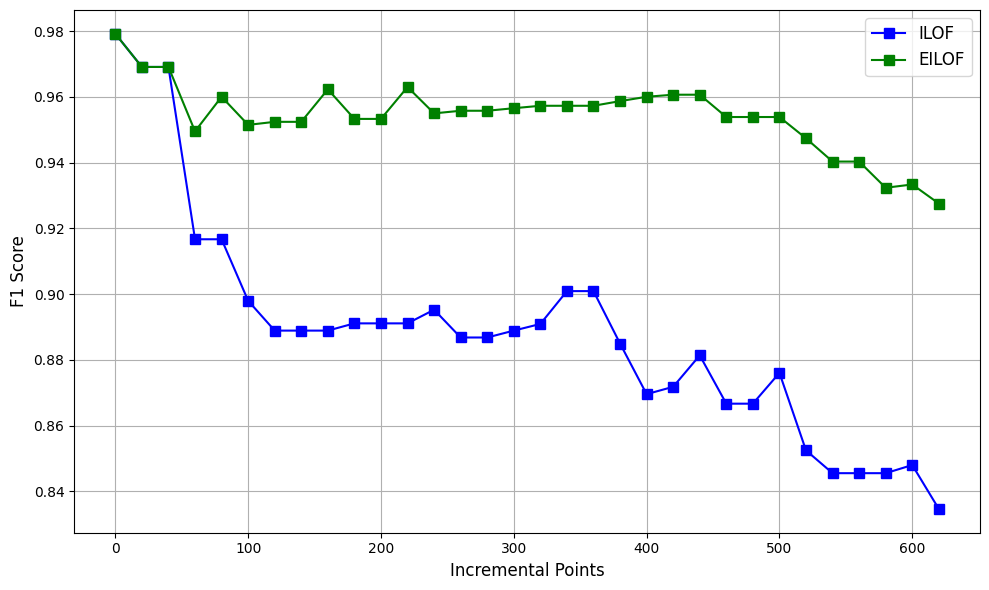

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Number of increments (x-axis)
x = range(len(f1_list))

# Select key points every 20th point for clarity
key_points = np.arange(0, len(f1_list), 20)

# Plotting the data
plt.figure(figsize=(10, 6))

# Plotting ILOF 7% and EILOF 7% with different markers
plt.plot(key_points, np.array(f1_list)[key_points], label='ILOF', marker='s', color='blue', markersize=7, linestyle='-', linewidth=1.5)
plt.plot(key_points, np.array(f1_new_list)[key_points], label='EILOF', marker='s', color='green', linestyle='-', markersize=7, linewidth=1.5)


# Adding labels, legend, and grid
plt.xlabel('Incremental Points', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('incremental_f1_scores_comparison.png', dpi=300)

# Show plot
plt.show()
files.download('incremental_f1_scores_comparison.png')

# Shuttle Dataset

Here, we demonstrate how to load and apply the methods to the Shuttle dataset
from UCI.

shuttle data: https://archive.ics.uci.edu/dataset/148/statlog+shuttle

exclude class 4 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4836738/


In [142]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch the dataset
statlog_shuttle = fetch_ucirepo(id=148)

# Data (as pandas dataframes)
X = statlog_shuttle.data.features
y = statlog_shuttle.data.targets

# Combine X and y into a single DataFrame for easier filtering
data = X.copy()
data['class'] = y

# Remove rows where y (class) equals 4
data_filtered = data[data['class'] != 4]

# Separate X and y after filtering
X = data_filtered.drop(columns=['class'])
data_filtered['class'] = data_filtered['class'].apply(lambda x: 0 if x == 1 else 1)
y = data_filtered['class']



/var/folders/9m/tnjp4c4s4h71yk7z7x0p2qxw0000gn/T/ipykernel_29328/293665858.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['class'] = data_filtered['class'].apply(lambda x: 0 if x == 1 else 1)


In [5]:
X

Rad Flow  Fpv Close  Fpv Open  High  Bypass  Bpv Close  Bpv Open
50  21        77          0        28     0      27         48        22
53  0         82          0        52    -5      29         30         2
37  0         76          0        28    18      40         48         8
    0         79          0        34   -26      43         46         2
85  0         88         -4         6     1       3         83        80
...          ...        ...       ...   ...     ...        ...       ...
39 -2         80         -4        38     0      41         41         0
43  0         81          1        42    -9      37         39         2
49  0         87          0        46   -12      38         41         2
80  0         84          0       -36   -29       4        120       116
37  0        103          0        18   -16      66         85        20

[49097 rows x 7 columns]

In [6]:
# Use selected_index and unselected_index to get selected_data, unselected_data, selected_labels, and unselected_labels
selected_data = X[:1000].reset_index(drop=True).values
selected_labels = y[:1000].reset_index(drop=True).values
unselected_data = X[1000:2280].reset_index(drop=True).values
unselected_labels = y[1000:2280].reset_index(drop=True).values


## Fig. 9(a)

### Incremental LOF Thresholding with 5% Outlier Detection and $k$ = 50

In [ ]:
test_index = range(0,640)
k = 50
f1_list_5_k50 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []

for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    # Calculate the threshold as the 93rd percentile of LOF values
    threshold_incremental_new = np.percentile(lof_og, 95)
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list_5_k50.append(f1)
f1_list_5_k50

[0.4915254237288136,
 0.4715447154471545,
 0.3968253968253968,
 0.40310077519379844,
 0.3969465648854962,
 0.37593984962406013,
 0.38235294117647056,
 0.36879432624113473,
 0.3835616438356164,
 0.3783783783783784,
 0.37333333333333335,
 0.3684210526315789,
 0.36363636363636365,
 0.36129032258064514,
 0.35668789808917195,
 0.37267080745341613,
 0.37037037037037035,
 0.37575757575757573,
 0.3712574850299401,
 0.36904761904761907,
 0.3742690058479532,
 0.3815028901734104,
 0.38857142857142857,
 0.3888888888888889,
 0.391304347826087,
 0.40425531914893614,
 0.39790575916230364,
 0.41237113402061853,
 0.40404040404040403,
 0.4020100502512563,
 0.38613861386138615,
 0.38235294117647056,
 0.3942307692307692]

### Incremental LOF Thresholding with 7% Outlier Detection and $k$ = 50

In [ ]:
test_index = range(0,640)
k = 50
f1_list_7_k50 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    # Calculate the threshold as the 93rd percentile of LOF values
    threshold_incremental_new = np.percentile(lof_og, 93)
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))

    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list_7_k50.append(f1)
f1_list_7_k50

[0.4492753623188406,
 0.4166666666666667,
 0.4217687074829932,
 0.4105960264900662,
 0.40522875816993464,
 0.3870967741935484,
 0.3522012578616352,
 0.32926829268292684,
 0.3411764705882353,
 0.32558139534883723,
 0.3218390804597701,
 0.3163841807909605,
 0.3240223463687151,
 0.32044198895027626,
 0.32786885245901637,
 0.3315508021390374,
 0.3386243386243386,
 0.34375,
 0.3384615384615385,
 0.336734693877551,
 0.3316582914572864,
 0.33663366336633666,
 0.3431372549019608,
 0.3333333333333333,
 0.3364485981308411,
 0.3486238532110092,
 0.34234234234234234,
 0.35555555555555557,
 0.34782608695652173,
 0.3463203463203463,
 0.3418803418803419,
 0.33755274261603374,
 0.34854771784232363]

### Incremental LOF Thresholding with 10% Outlier Detection and $k$ = 50

In [ ]:
test_index = range(0,640)
k = 50
f1_list_10_k50 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    # Calculate the threshold as the 93rd percentile of LOF values
    threshold_incremental_new = np.percentile(lof_og, 90)
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list_10_k50.append(f1)
f1_list_10_k50

[0.40476190476190477,
 0.3563218390804598,
 0.34831460674157305,
 0.3516483516483517,
 0.34594594594594597,
 0.3404255319148936,
 0.34375,
 0.29292929292929293,
 0.3333333333333333,
 0.2995169082125604,
 0.2857142857142857,
 0.28169014084507044,
 0.2777777777777778,
 0.27522935779816515,
 0.27149321266968324,
 0.2831858407079646,
 0.2807017543859649,
 0.28448275862068967,
 0.28085106382978725,
 0.27848101265822783,
 0.2821576763485477,
 0.28688524590163933,
 0.291497975708502,
 0.2766798418972332,
 0.27906976744186046,
 0.2889733840304182,
 0.2846441947565543,
 0.2952029520295203,
 0.2898550724637681,
 0.28776978417266186,
 0.28368794326241137,
 0.2807017543859649,
 0.2896551724137931]

### EILOF Thresholding with 5% Outlier Detection and $k$ = 50

In [ ]:
# Initialize variables
test_index = range(0, 640)
k = 50
f1_new_list_5_k50 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 95th percentile of LOF scores
    threshold_incremental_new = np.percentile(model.lof_scores, 95)
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)
    labels_update = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update, predicted_labels)
    f1_new_list_5_k50.append(f1)
f1_new_list_5_k50

[0.4915254237288135,
 0.4873949579831932,
 0.4873949579831932,
 0.4873949579831932,
 0.4873949579831932,
 0.4873949579831932,
 0.4873949579831932,
 0.4873949579831932,
 0.4873949579831932,
 0.4833333333333333,
 0.47933884297520657,
 0.47540983606557374,
 0.47540983606557374,
 0.47540983606557374,
 0.4715447154471545,
 0.4715447154471545,
 0.4715447154471545,
 0.4715447154471545,
 0.4715447154471545,
 0.4715447154471545,
 0.4715447154471545,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.48,
 0.47619047619047616,
 0.47619047619047616,
 0.47619047619047616,
 0.47619047619047616,
 0.46031746031746035,
 0.46031746031746035,
 0.46031746031746035,
 0.46031746031746035,
 0.46031746031746035,
 0.46031746031746035,
 0.46031746031746035,
 0.46031746031746035,
 0.45669291338582674,
 0.45669291338582674,
 0.453125,
 0.46511627906976744,
 0.46511627906976744,
 0.46511627906976744,
 0.46511627906976744,
 0.46511627906976744,
 0.46511627906976744,
 0.46511627906976744,
 0.46511627906976744,
 0.465116279069767

### EILOF Thresholding with 7% Outlier Detection and $k$ = 50

In [ ]:
# Initialize variables
test_index = range(640)
k = 50
f1_new_list_7_k50 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 93rd percentile of LOF scores
    threshold_incremental_new = np.percentile(model.lof_scores, 93)
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)
    labels_update = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update, predicted_labels)
    f1_new_list_7_k50.append(f1)
f1_new_list_7_k50


[0.4492753623188406,
 0.4492753623188406,
 0.4492753623188406,
 0.4492753623188406,
 0.44604316546762585,
 0.44604316546762585,
 0.44604316546762585,
 0.44604316546762585,
 0.44604316546762585,
 0.44285714285714284,
 0.43971631205673756,
 0.43661971830985913,
 0.43661971830985913,
 0.43661971830985913,
 0.43356643356643354,
 0.4444444444444444,
 0.4444444444444444,
 0.4444444444444444,
 0.4444444444444444,
 0.4444444444444444,
 0.4444444444444444,
 0.4413793103448276,
 0.4413793103448276,
 0.4413793103448276,
 0.4413793103448276,
 0.4413793103448276,
 0.4413793103448276,
 0.4383561643835616,
 0.4383561643835616,
 0.4383561643835616,
 0.4383561643835616,
 0.435374149659864,
 0.42176870748299317,
 0.42176870748299317,
 0.42176870748299317,
 0.42176870748299317,
 0.42176870748299317,
 0.42176870748299317,
 0.42176870748299317,
 0.4189189189189189,
 0.4189189189189189,
 0.4189189189189189,
 0.42953020134228187,
 0.4266666666666667,
 0.4266666666666667,
 0.4266666666666667,
 0.4266666666666

### EILOF Thresholding with 10% Outlier Detection and $k$ = 50

In [ ]:
# Initialize variables
test_index = range(0, 640)
k = 50
f1_new_list_10_k50 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 95th percentile of LOF scores
    threshold_incremental_new = np.percentile(model.lof_scores, 90)
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)
    labels_update = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update, predicted_labels)
    f1_new_list_10_k50.append(f1)
f1_new_list_10_k50

[0.40476190476190477,
 0.40236686390532544,
 0.40236686390532544,
 0.40236686390532544,
 0.40236686390532544,
 0.40236686390532544,
 0.40236686390532544,
 0.40236686390532544,
 0.40236686390532544,
 0.4,
 0.3976608187134503,
 0.39306358381502887,
 0.39306358381502887,
 0.39306358381502887,
 0.40229885057471265,
 0.40229885057471265,
 0.40229885057471265,
 0.40229885057471265,
 0.40229885057471265,
 0.40229885057471265,
 0.40229885057471265,
 0.3977272727272727,
 0.3977272727272727,
 0.3977272727272727,
 0.3977272727272727,
 0.3977272727272727,
 0.3977272727272727,
 0.39548022598870053,
 0.39548022598870053,
 0.39548022598870053,
 0.39548022598870053,
 0.39325842696629215,
 0.39325842696629215,
 0.39325842696629215,
 0.39325842696629215,
 0.39325842696629215,
 0.39325842696629215,
 0.39325842696629215,
 0.39325842696629215,
 0.3910614525139665,
 0.3910614525139665,
 0.3888888888888889,
 0.3977900552486187,
 0.3977900552486187,
 0.3977900552486187,
 0.3977900552486187,
 0.397790055248618

### Fig. 9 (a): Comparison of EILOF and ILOF performance on Shuttle dataset when $k$ = 50

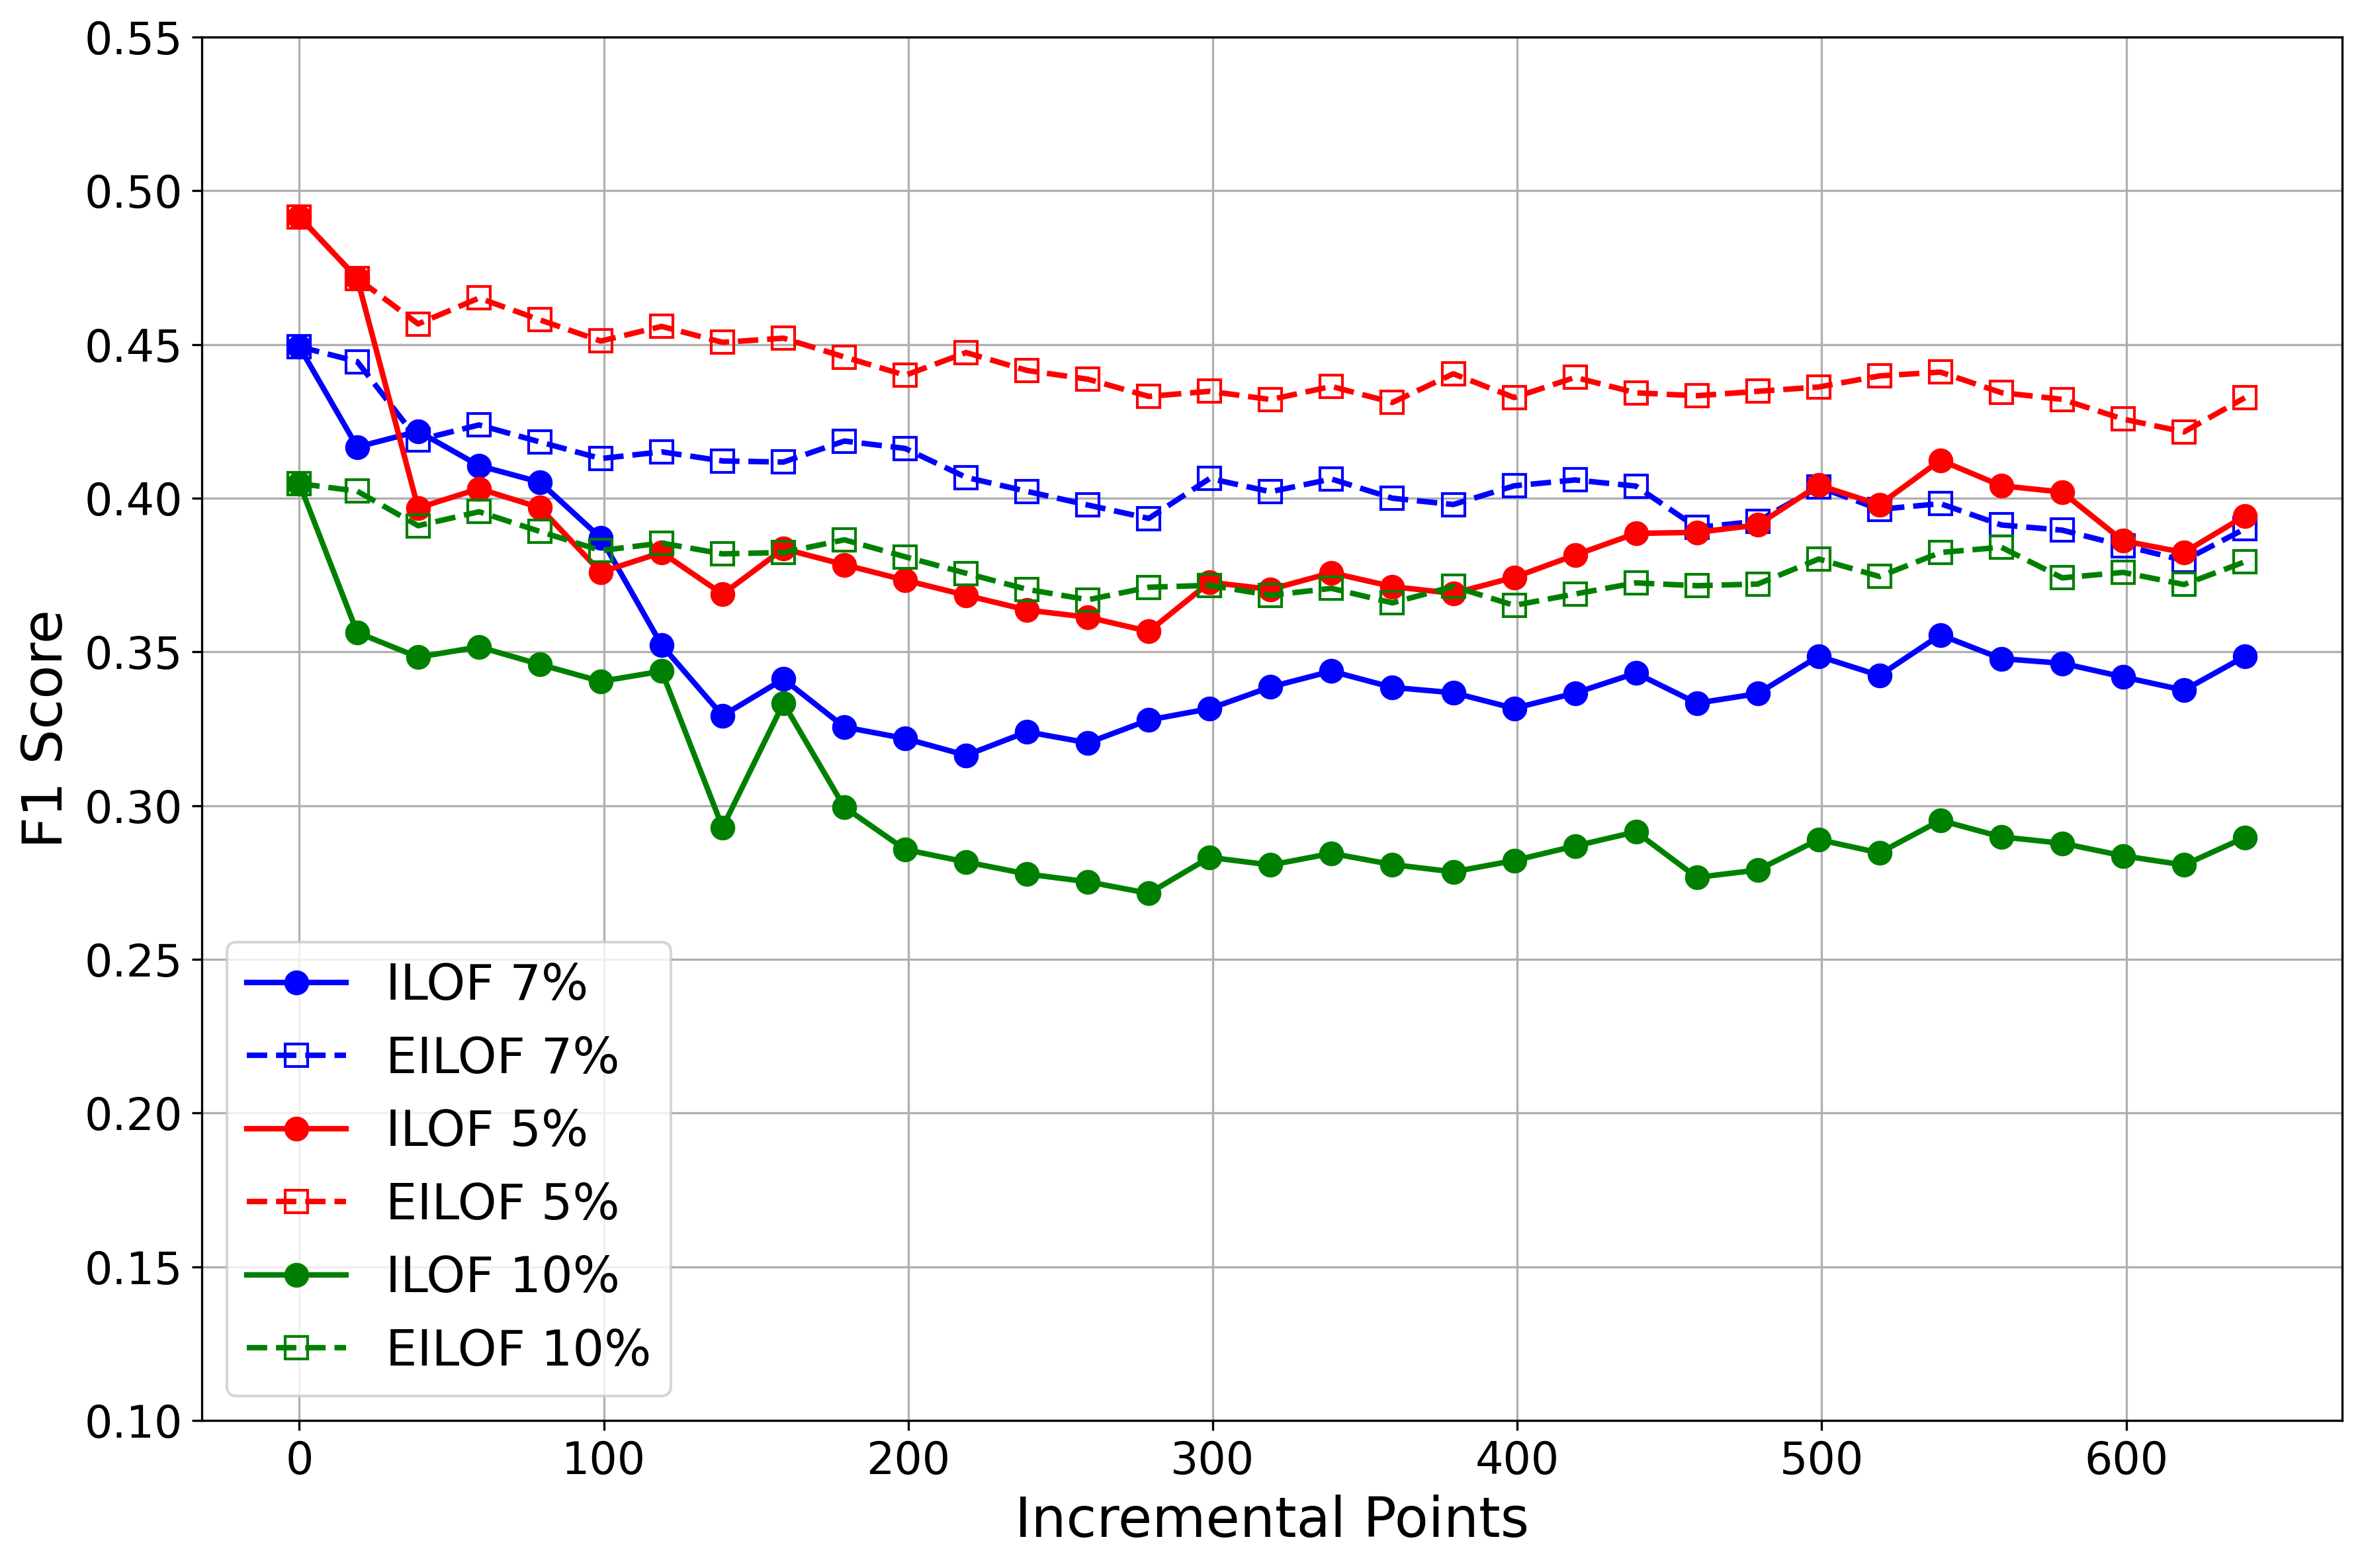

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of increments (x-axis)
x = range(len(f1_new_list_5_k50))

# Select key points every 20th point for clarity
key_points = np.insert(np.arange(19, len(f1_new_list_7_k50), 20), 0, 0)

# Create a high-resolution figure
plt.figure(figsize=(12, 8), dpi=300)  # Increased figure size and resolution (DPI)

# Plotting ILOF 7% and EILOF 7% with different markers
plt.plot(key_points, np.array(f1_list_7_k50), label='ILOF 7%', marker='o', color='blue', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list_7_k50)[key_points], label='EILOF 7%', marker='s', color='blue', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)

# Plotting ILOF 5% and EILOF 5% with different markers
plt.plot(key_points, np.array(f1_list_5_k50), label='ILOF 5%', marker='o', color='red', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list_5_k50)[key_points], label='EILOF 5%', marker='s', color='red', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)

# Plotting ILOF 10% and EILOF 10% with different markers
plt.plot(key_points, np.array(f1_list_10_k50), label='ILOF 10%', marker='o', color='green', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list_10_k50)[key_points], label='EILOF 10%', marker='s', color='green', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)

# Adding labels, legend, and grid with better formatting
plt.xlabel('Incremental Points', fontsize=20)
plt.ylabel('F1 Score', fontsize=20)
plt.legend(fontsize=18, loc='lower left')
plt.xticks(fontsize=16)  # Increase font size for x-axis scale numbers
plt.yticks(np.arange(0.10, 0.60, 0.05), fontsize=16)
plt.grid(True)
# Tight layout and export settings
plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300)  # Save the figure as a high-resolution PNG
plt.show()

## Fig. 9(b)

### Incremental LOF Thresholding with 5% Outlier Detection and $k$ = 100

In [ ]:
test_index = range(0,640)
k = 100
f1_list5 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []

for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    threshold_incremental_new = np.percentile(lof_og, 95)
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list5.append(f1)
f1_list5

### Incremental LOF Thresholding with 7% Outlier Detection and $k$ = 100

In [ ]:
test_index = range(0,640)
k = 100
f1_list7 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []

for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    threshold_incremental_new = np.percentile(lof_og, 93)
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list7.append(f1)
f1_list7

### Incremental LOF Thresholding with 10% Outlier Detection and $k$ = 100

In [ ]:
test_index = range(0,640)
k = 100
f1_list10 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []

for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    threshold_incremental_new = np.percentile(lof_og, 90)
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list10.append(f1)
f1_list10

### EILOF Thresholding with 5% Outlier Detection and $k$ = 100

In [64]:
# Initialize variables
test_index = range(0, 640)
k = 100
f1_new_list5 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Copy the selected data for incremental updates
data_copy = selected_data

# Loop through test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 95th percentile of LOF scores
    threshold_incremental_new = np.percentile(model.lof_scores, 95)

    # Classify points based on the threshold
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)

    # Update the labels
    labels_update = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update, predicted_labels)
    f1_new_list5.append(f1)
f1_new_list5

KeyboardInterrupt: 

### EILOF Thresholding with 7% Outlier Detection and $k$ = 100

In [ ]:
# Initialize variables
test_index = range(0, 640)
k = 100
f1_new_list7 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)
data_copy = selected_data

# Loop through test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 93rd percentile of LOF scores
    threshold_incremental_new = np.percentile(model.lof_scores, 93)

    # Classify points based on the threshold
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)

    # Update the labels
    labels_update = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update, predicted_labels)
    f1_new_list7.append(f1)
f1_new_list7

[0.855072463768116,
 0.8633093525179856,
 0.8633093525179856,
 0.8633093525179856,
 0.8633093525179856,
 0.8633093525179856,
 0.8633093525179856,
 0.8633093525179856,
 0.8633093525179856,
 0.8571428571428571,
 0.851063829787234,
 0.8450704225352113,
 0.8450704225352113,
 0.8450704225352113,
 0.8391608391608392,
 0.8472222222222222,
 0.8472222222222222,
 0.8472222222222222,
 0.8472222222222222,
 0.8472222222222222,
 0.8472222222222222,
 0.8413793103448276,
 0.8413793103448276,
 0.8413793103448276,
 0.8413793103448276,
 0.8413793103448276,
 0.8413793103448276,
 0.8356164383561644,
 0.8356164383561644,
 0.8435374149659864,
 0.8435374149659864,
 0.8299319727891157,
 0.8299319727891157,
 0.8299319727891157,
 0.8299319727891157,
 0.8299319727891157,
 0.8299319727891157,
 0.8299319727891157,
 0.8299319727891157,
 0.8243243243243243,
 0.8243243243243243,
 0.8243243243243243,
 0.8187919463087249,
 0.8266666666666667,
 0.8266666666666667,
 0.8266666666666667,
 0.8266666666666667,
 0.826666666666

### EILOF Thresholding with 10% Outlier Detection and $k$ = 100

In [ ]:
test_index = range(0, 640)
k = 100
f1_new_list10 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 90th percentile of LOF scores
    threshold_incremental_new = np.percentile(model.lof_scores, 90)

    # Classify points based on the threshold
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)

    labels_update = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update, predicted_labels)
    f1_new_list10.append(f1)
f1_new_list10

[0.8095238095238095,
 0.8047337278106509,
 0.8047337278106509,
 0.8047337278106509,
 0.8047337278106509,
 0.8047337278106509,
 0.8047337278106509,
 0.8047337278106509,
 0.8047337278106509,
 0.8,
 0.8070175438596491,
 0.8092485549132948,
 0.8092485549132948,
 0.8092485549132948,
 0.8160919540229885,
 0.8160919540229885,
 0.8160919540229885,
 0.8160919540229885,
 0.8160919540229885,
 0.8160919540229885,
 0.8160919540229885,
 0.8181818181818182,
 0.8181818181818182,
 0.8181818181818182,
 0.8181818181818182,
 0.8181818181818182,
 0.8181818181818182,
 0.8248587570621468,
 0.8248587570621468,
 0.8248587570621468,
 0.8248587570621468,
 0.8202247191011236,
 0.8202247191011236,
 0.8202247191011236,
 0.8202247191011236,
 0.8202247191011236,
 0.8202247191011236,
 0.8202247191011236,
 0.8202247191011236,
 0.8268156424581006,
 0.8268156424581006,
 0.8222222222222222,
 0.8287292817679558,
 0.8287292817679558,
 0.8287292817679558,
 0.8287292817679558,
 0.8287292817679558,
 0.8287292817679558,
 0.8287

### Fig. 9 (b): Comparison of EILOF and ILOF performance on Shuttle dataset when $k$ = 100.

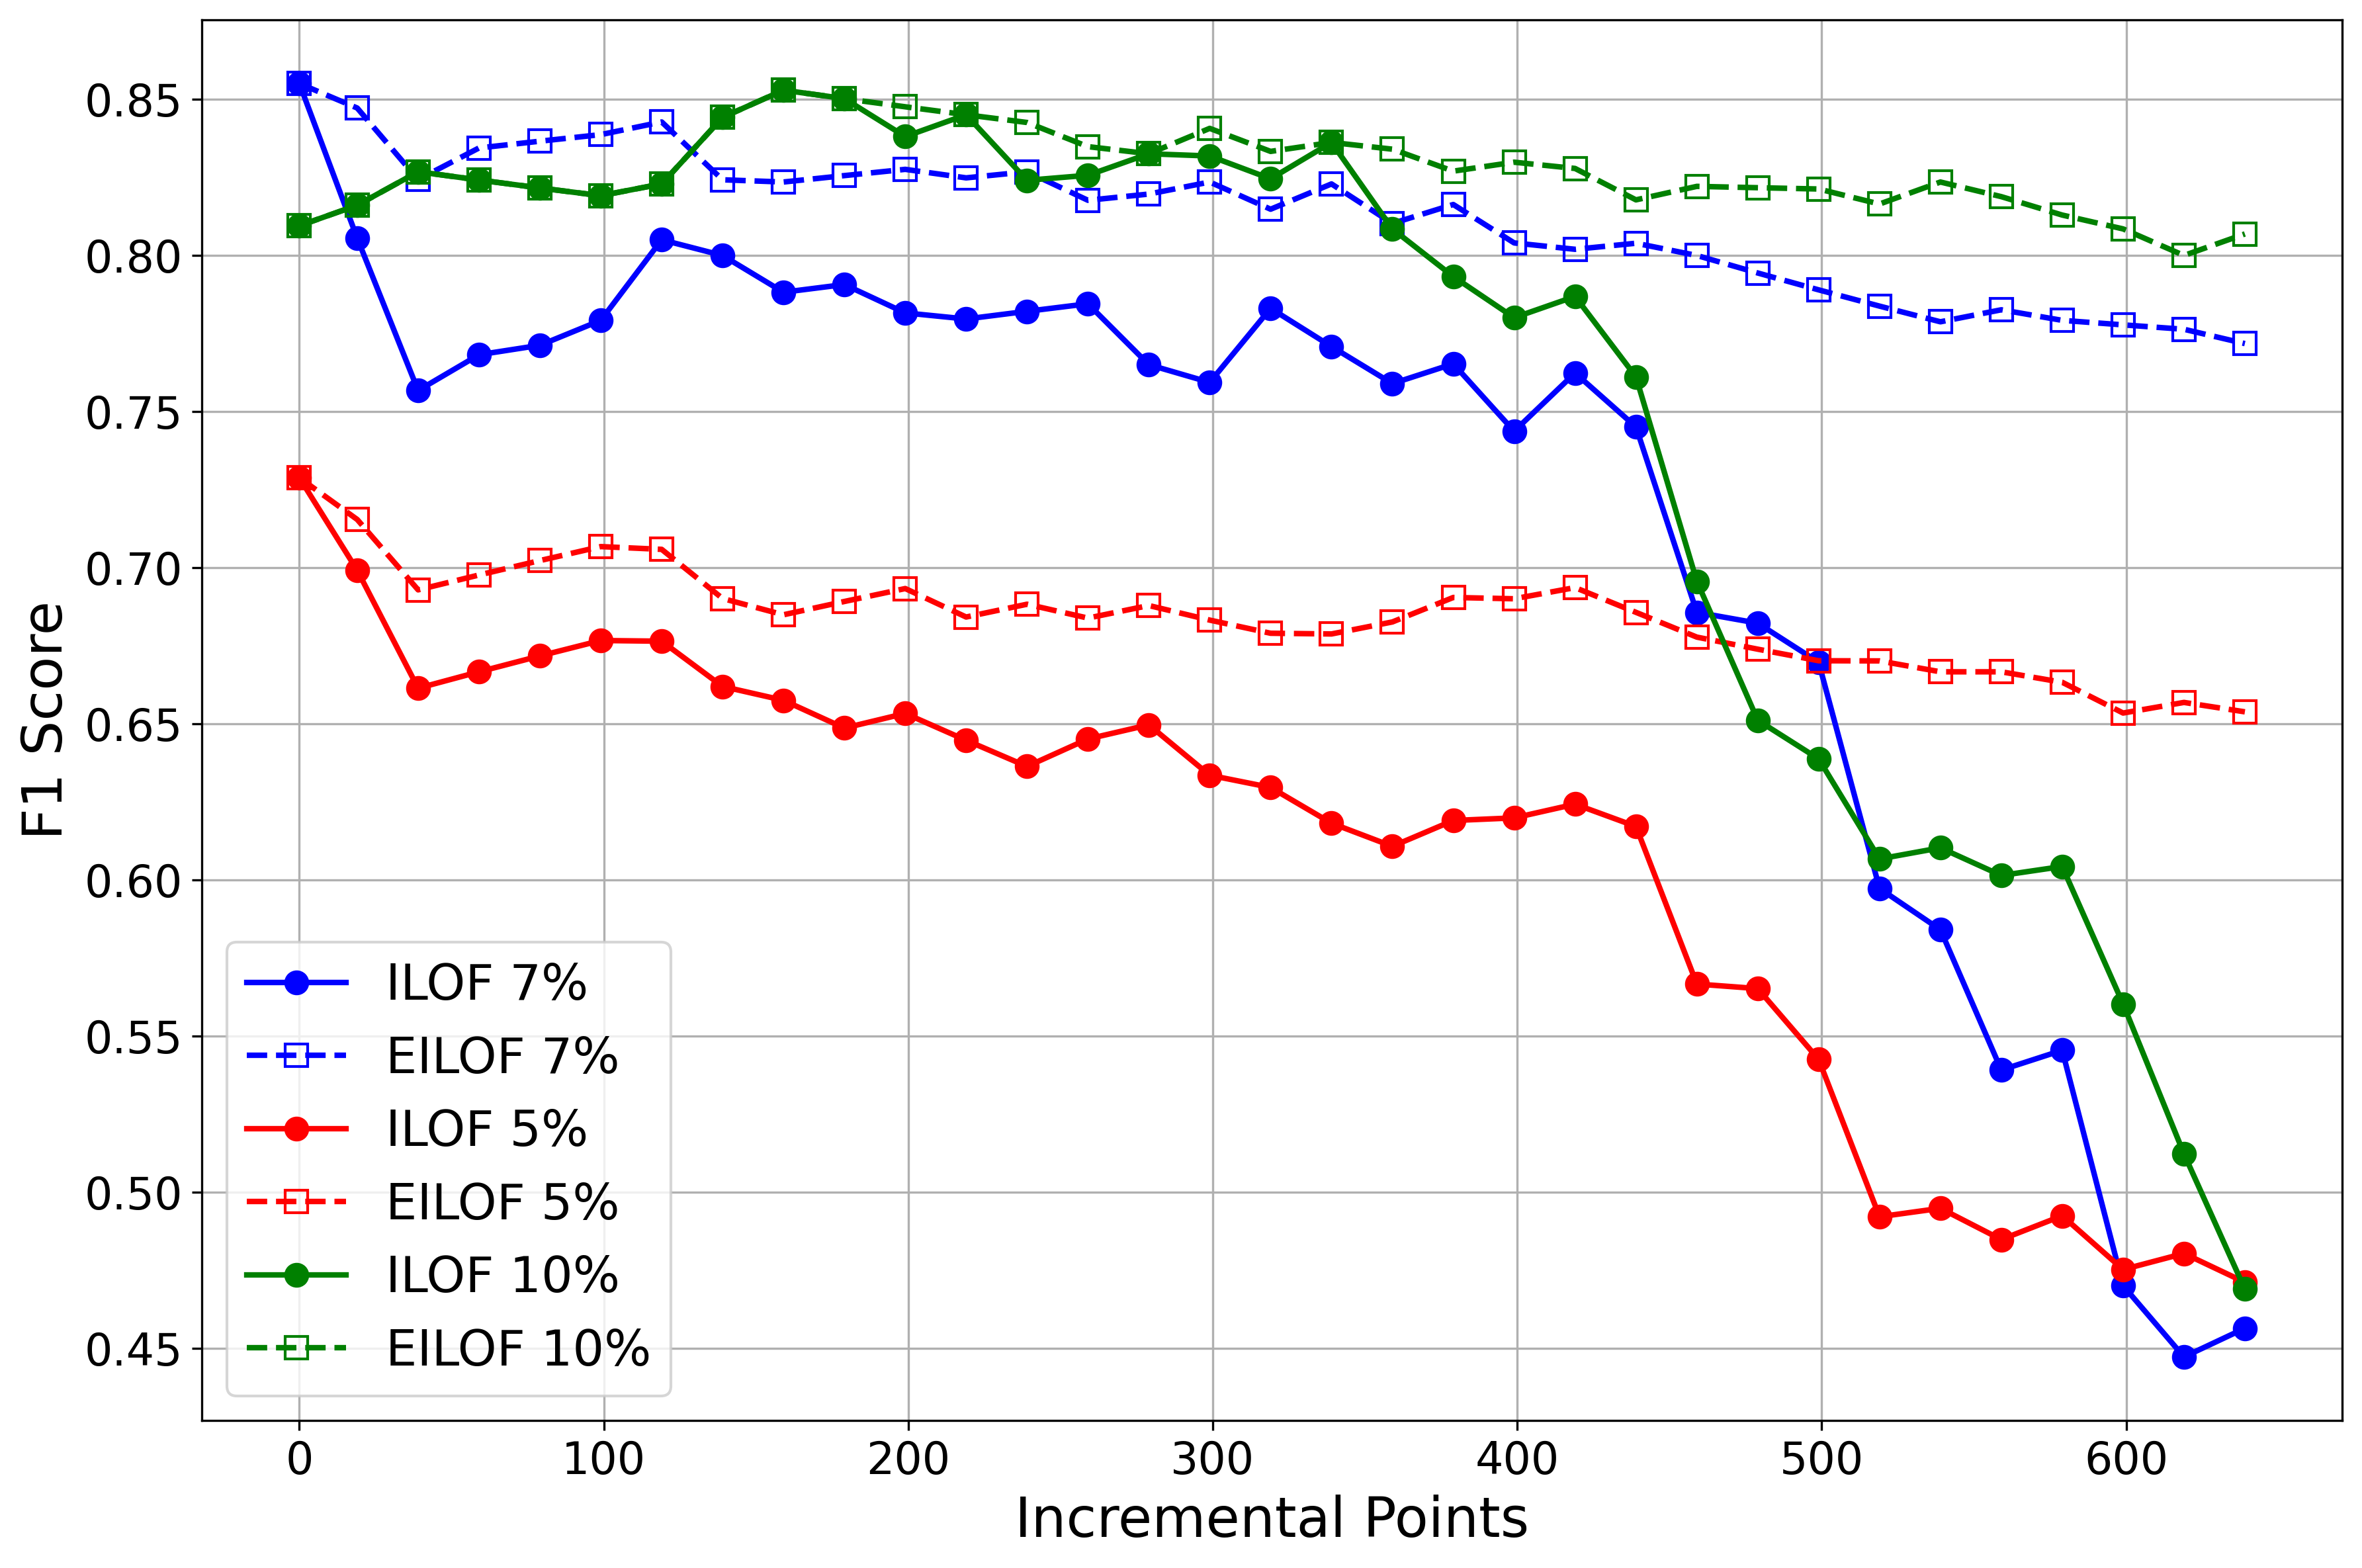

In [ ]:
x = range(len(f1_new_list7))

# Select key points every 20th point for clarity
key_points = np.insert(np.arange(19, len(f1_new_list7), 20), 0, 0)
plt.figure(figsize=(12, 8), dpi=300)

# Plotting ILOF 7% and EILOF 7% with different markers
plt.plot(key_points, np.array(f1_list7), label='ILOF 7%', marker='o', color='blue', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list7)[key_points], label='EILOF 7%', marker='s', color='blue', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)

# Plotting ILOF 5% and EILOF 5% with different markers
plt.plot(key_points, np.array(f1_list5), label='ILOF 5%', marker='o', color='red', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list5)[key_points], label='EILOF 5%', marker='s', color='red', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)

# Plotting ILOF 10% and EILOF 10% with different markers
plt.plot(key_points, np.array(f1_list10), label='ILOF 10%', marker='o', color='green', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list10)[key_points], label='EILOF 10%', marker='s', color='green', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)
plt.xlabel('Incremental Points', fontsize=20)
plt.ylabel('F1 Score', fontsize=20)
plt.legend(fontsize=18, loc='lower left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300)
plt.show()


## Fig. 9(c)

### Incremental LOF Thresholding with 5% Outlier Detection and $k$ = 150

In [ ]:
test_index = range(0,640)
k = 150
f1_list_5_k150 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    # Calculate the threshold as the 93rd percentile of LOF values
    threshold_incremental_new = np.percentile(lof_og, 95)

    # Classify points based on the threshold
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list_5_k150.append(f1)
f1_list_5_k150

[0.7627118644067796,
 0.7479674796747967,
 0.7142857142857143,
 0.6976744186046512,
 0.7022900763358778,
 0.706766917293233,
 0.7058823529411765,
 0.6950354609929078,
 0.6986301369863014,
 0.6891891891891891,
 0.7066666666666667,
 0.6973684210526315,
 0.6883116883116883,
 0.6967741935483871,
 0.6878980891719745,
 0.6956521739130435,
 0.691358024691358,
 0.6909090909090909,
 0.6946107784431138,
 0.6785714285714286,
 0.6783625730994152,
 0.6936416184971098,
 0.6857142857142857,
 0.6666666666666666,
 0.6630434782608695,
 0.6702127659574468,
 0.6596858638743456,
 0.6701030927835051,
 0.6565656565656566,
 0.6633165829145728,
 0.6633663366336634,
 0.6666666666666666,
 0.6442307692307693]

### Incremental LOF Thresholding with 7% Outlier Detection and $k$ = 150

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
test_index = range(0,640)
k = 150
f1_list_7_k150 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    # Calculate the threshold as the 93rd percentile of LOF values
    threshold_incremental_new = np.percentile(lof_og, 93)

    # Classify points based on the threshold
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list_7_k150.append(f1)
f1_list_7_k150

[0.855072463768116,
 0.8333333333333334,
 0.7891156462585034,
 0.8079470198675497,
 0.8104575163398693,
 0.8,
 0.8050314465408805,
 0.7926829268292683,
 0.788235294117647,
 0.7906976744186046,
 0.8045977011494253,
 0.8135593220338984,
 0.8156424581005587,
 0.8176795580110497,
 0.8306010928961749,
 0.8235294117647058,
 0.8148148148148148,
 0.8125,
 0.8102564102564103,
 0.8061224489795918,
 0.7939698492462312,
 0.801980198019802,
 0.7941176470588235,
 0.7619047619047619,
 0.7476635514018691,
 0.7431192660550459,
 0.7387387387387387,
 0.7377777777777778,
 0.7391304347826086,
 0.7359307359307359,
 0.7350427350427351,
 0.7426160337552743,
 0.7385892116182573]

### Incremental LOF Thresholding with 10% Outlier Detection and $k$ = 150

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
test_index = range(0,640)
k = 150
f1_list_10_k150 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    # Calculate the threshold as the 93rd percentile of LOF values
    threshold_incremental_new = np.percentile(lof_og, 90)

    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))

    # Calculate F1 score and accuracy
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list_10_k150.append(f1)

In [ ]:
f1_list_10_k150

[0.8095238095238095,
 0.8160919540229885,
 0.8268156424581006,
 0.8241758241758242,
 0.8216216216216217,
 0.8191489361702128,
 0.8229166666666667,
 0.8442211055276382,
 0.8529411764705882,
 0.8502415458937198,
 0.8476190476190477,
 0.8450704225352113,
 0.8425925925925927,
 0.8348623853211009,
 0.832579185520362,
 0.84070796460177,
 0.8333333333333333,
 0.8362068965517241,
 0.8340425531914893,
 0.8270042194092827,
 0.8298755186721991,
 0.8278688524590163,
 0.8178137651821862,
 0.8300395256916996,
 0.8372093023255814,
 0.8365019011406845,
 0.8314606741573033,
 0.8455882352941175,
 0.8333333333333333,
 0.841726618705036,
 0.8297872340425532,
 0.8421052631578947]

### EILOF Thresholding with 5% Outlier Detection and $k$ = 150

In [ ]:
# Initialize variables
test_index = range(0, 640)
k = 150
f1_new_list_5_k150 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 95th percentile of LOF scores
    threshold_incremental_new = np.percentile(model.lof_scores, 95)

    # Classify points based on the threshold
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)
    labels_update = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update, predicted_labels)
    f1_new_list_5_k150.append(f1)
f1_new_list_5_k150

[0.7627118644067796,
 0.773109243697479,
 0.773109243697479,
 0.773109243697479,
 0.773109243697479,
 0.773109243697479,
 0.773109243697479,
 0.773109243697479,
 0.773109243697479,
 0.7666666666666666,
 0.7603305785123967,
 0.7540983606557378,
 0.7540983606557378,
 0.7540983606557378,
 0.7479674796747967,
 0.7479674796747967,
 0.7479674796747967,
 0.7479674796747967,
 0.7479674796747967,
 0.7479674796747967,
 0.7479674796747967,
 0.752,
 0.752,
 0.752,
 0.752,
 0.752,
 0.752,
 0.746031746031746,
 0.746031746031746,
 0.746031746031746,
 0.746031746031746,
 0.7301587301587302,
 0.7301587301587302,
 0.7301587301587302,
 0.7301587301587302,
 0.7301587301587302,
 0.7301587301587302,
 0.7301587301587302,
 0.7301587301587302,
 0.7244094488188976,
 0.7244094488188976,
 0.734375,
 0.7286821705426356,
 0.7286821705426356,
 0.7286821705426356,
 0.7286821705426356,
 0.7286821705426356,
 0.7286821705426356,
 0.7286821705426356,
 0.7286821705426356,
 0.7286821705426356,
 0.7286821705426356,
 0.72868

### EILOF Thresholding with 7% Outlier Detection and $k$ = 150

In [ ]:
# Initialize variables
test_index = range(0, 640)
k = 150
f1_new_list_7_k150 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 93rd percentile of LOF scores
    threshold_incremental_new = np.percentile(model.lof_scores, 93)

    # Classify points based on the threshold
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)

    # Update the labels
    labels_update = np.append(selected_labels, unselected_labels[:i+1])

    # Calculate F1 score
    f1 = f1_score(labels_update, predicted_labels)

    # Append the F1 score to the list
    f1_new_list_7_k150.append(f1)

# Results
f1_new_list_7_k150

[0.855072463768116,
 0.8633093525179856,
 0.8633093525179856,
 0.8633093525179856,
 0.8633093525179856,
 0.8633093525179856,
 0.8633093525179856,
 0.8633093525179856,
 0.8633093525179856,
 0.8571428571428571,
 0.851063829787234,
 0.8450704225352113,
 0.8450704225352113,
 0.8450704225352113,
 0.8391608391608392,
 0.8472222222222222,
 0.8472222222222222,
 0.8472222222222222,
 0.8472222222222222,
 0.8472222222222222,
 0.8472222222222222,
 0.8413793103448276,
 0.8413793103448276,
 0.8413793103448276,
 0.8413793103448276,
 0.8413793103448276,
 0.8413793103448276,
 0.8356164383561644,
 0.8356164383561644,
 0.8435374149659864,
 0.8435374149659864,
 0.8299319727891157,
 0.8299319727891157,
 0.8299319727891157,
 0.8299319727891157,
 0.8299319727891157,
 0.8299319727891157,
 0.8299319727891157,
 0.8299319727891157,
 0.8243243243243243,
 0.8243243243243243,
 0.8243243243243243,
 0.8187919463087249,
 0.8266666666666667,
 0.8266666666666667,
 0.8266666666666667,
 0.8266666666666667,
 0.826666666666

### EILOF Thresholding with 10% Outlier Detection and $k$ = 150

In [ ]:
# Initialize variables
test_index = range(0, 640)
k = 150
f1_new_list_10_k150 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 90th percentile of LOF scores
    threshold_incremental_new = np.percentile(model.lof_scores, 90)

    # Classify points based on the threshold
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)

    # Update the labels
    labels_update = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update, predicted_labels)
    f1_new_list_10_k150.append(f1)
f1_new_list_10_k150

[0.8095238095238095,
 0.8047337278106509,
 0.8047337278106509,
 0.8047337278106509,
 0.8047337278106509,
 0.8047337278106509,
 0.8047337278106509,
 0.8047337278106509,
 0.8047337278106509,
 0.8,
 0.8070175438596491,
 0.8092485549132947,
 0.8092485549132947,
 0.8092485549132947,
 0.8160919540229885,
 0.8160919540229885,
 0.8160919540229885,
 0.8160919540229885,
 0.8160919540229885,
 0.8160919540229885,
 0.8160919540229885,
 0.8181818181818181,
 0.8181818181818181,
 0.8181818181818181,
 0.8181818181818181,
 0.8181818181818181,
 0.8181818181818181,
 0.8248587570621468,
 0.8248587570621468,
 0.8248587570621468,
 0.8248587570621468,
 0.8202247191011235,
 0.8202247191011235,
 0.8202247191011235,
 0.8202247191011235,
 0.8202247191011235,
 0.8202247191011235,
 0.8202247191011235,
 0.8202247191011235,
 0.8268156424581006,
 0.8268156424581006,
 0.8222222222222222,
 0.8287292817679558,
 0.8287292817679558,
 0.8287292817679558,
 0.8287292817679558,
 0.8287292817679558,
 0.8287292817679558,
 0.8287

### Stochastic Outlier Selection (SOS) Thresholding with 5% Outlier Detection

In [ ]:
from sksos import SOS
from sklearn.metrics import f1_score
import numpy as np

# Initialize
test_index = range(0, 640)
f1_new_list_sos = []

# Initial training data
X_train = selected_data.copy()
y_train = selected_labels.copy()

model = SOS(perplexity=750)

# Streaming loop
for i in test_index:
    x_new = unselected_data[i].reshape(1, -1)
    y_new = unselected_labels[i]

    # Update training set
    X_train = np.vstack([X_train, x_new])
    y_train = np.append(y_train, y_new)

    # Compute outlier probabilities
    probs = model.predict(X_train)  # higher = more outlier
    threshold = np.percentile(probs, 95)
    preds = (probs > threshold).astype(int)

    # Compute F1
    f1 = f1_score(y_train, preds)
    f1_new_list_sos.append(f1)

f1_new_list_sos

/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: invalid value encountered in divide
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: invalid value encountered in divide
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWa

### Fig. 9 (c): Comparison of EILOF and ILOF performance on Shuttle dataset when $k$ = 150

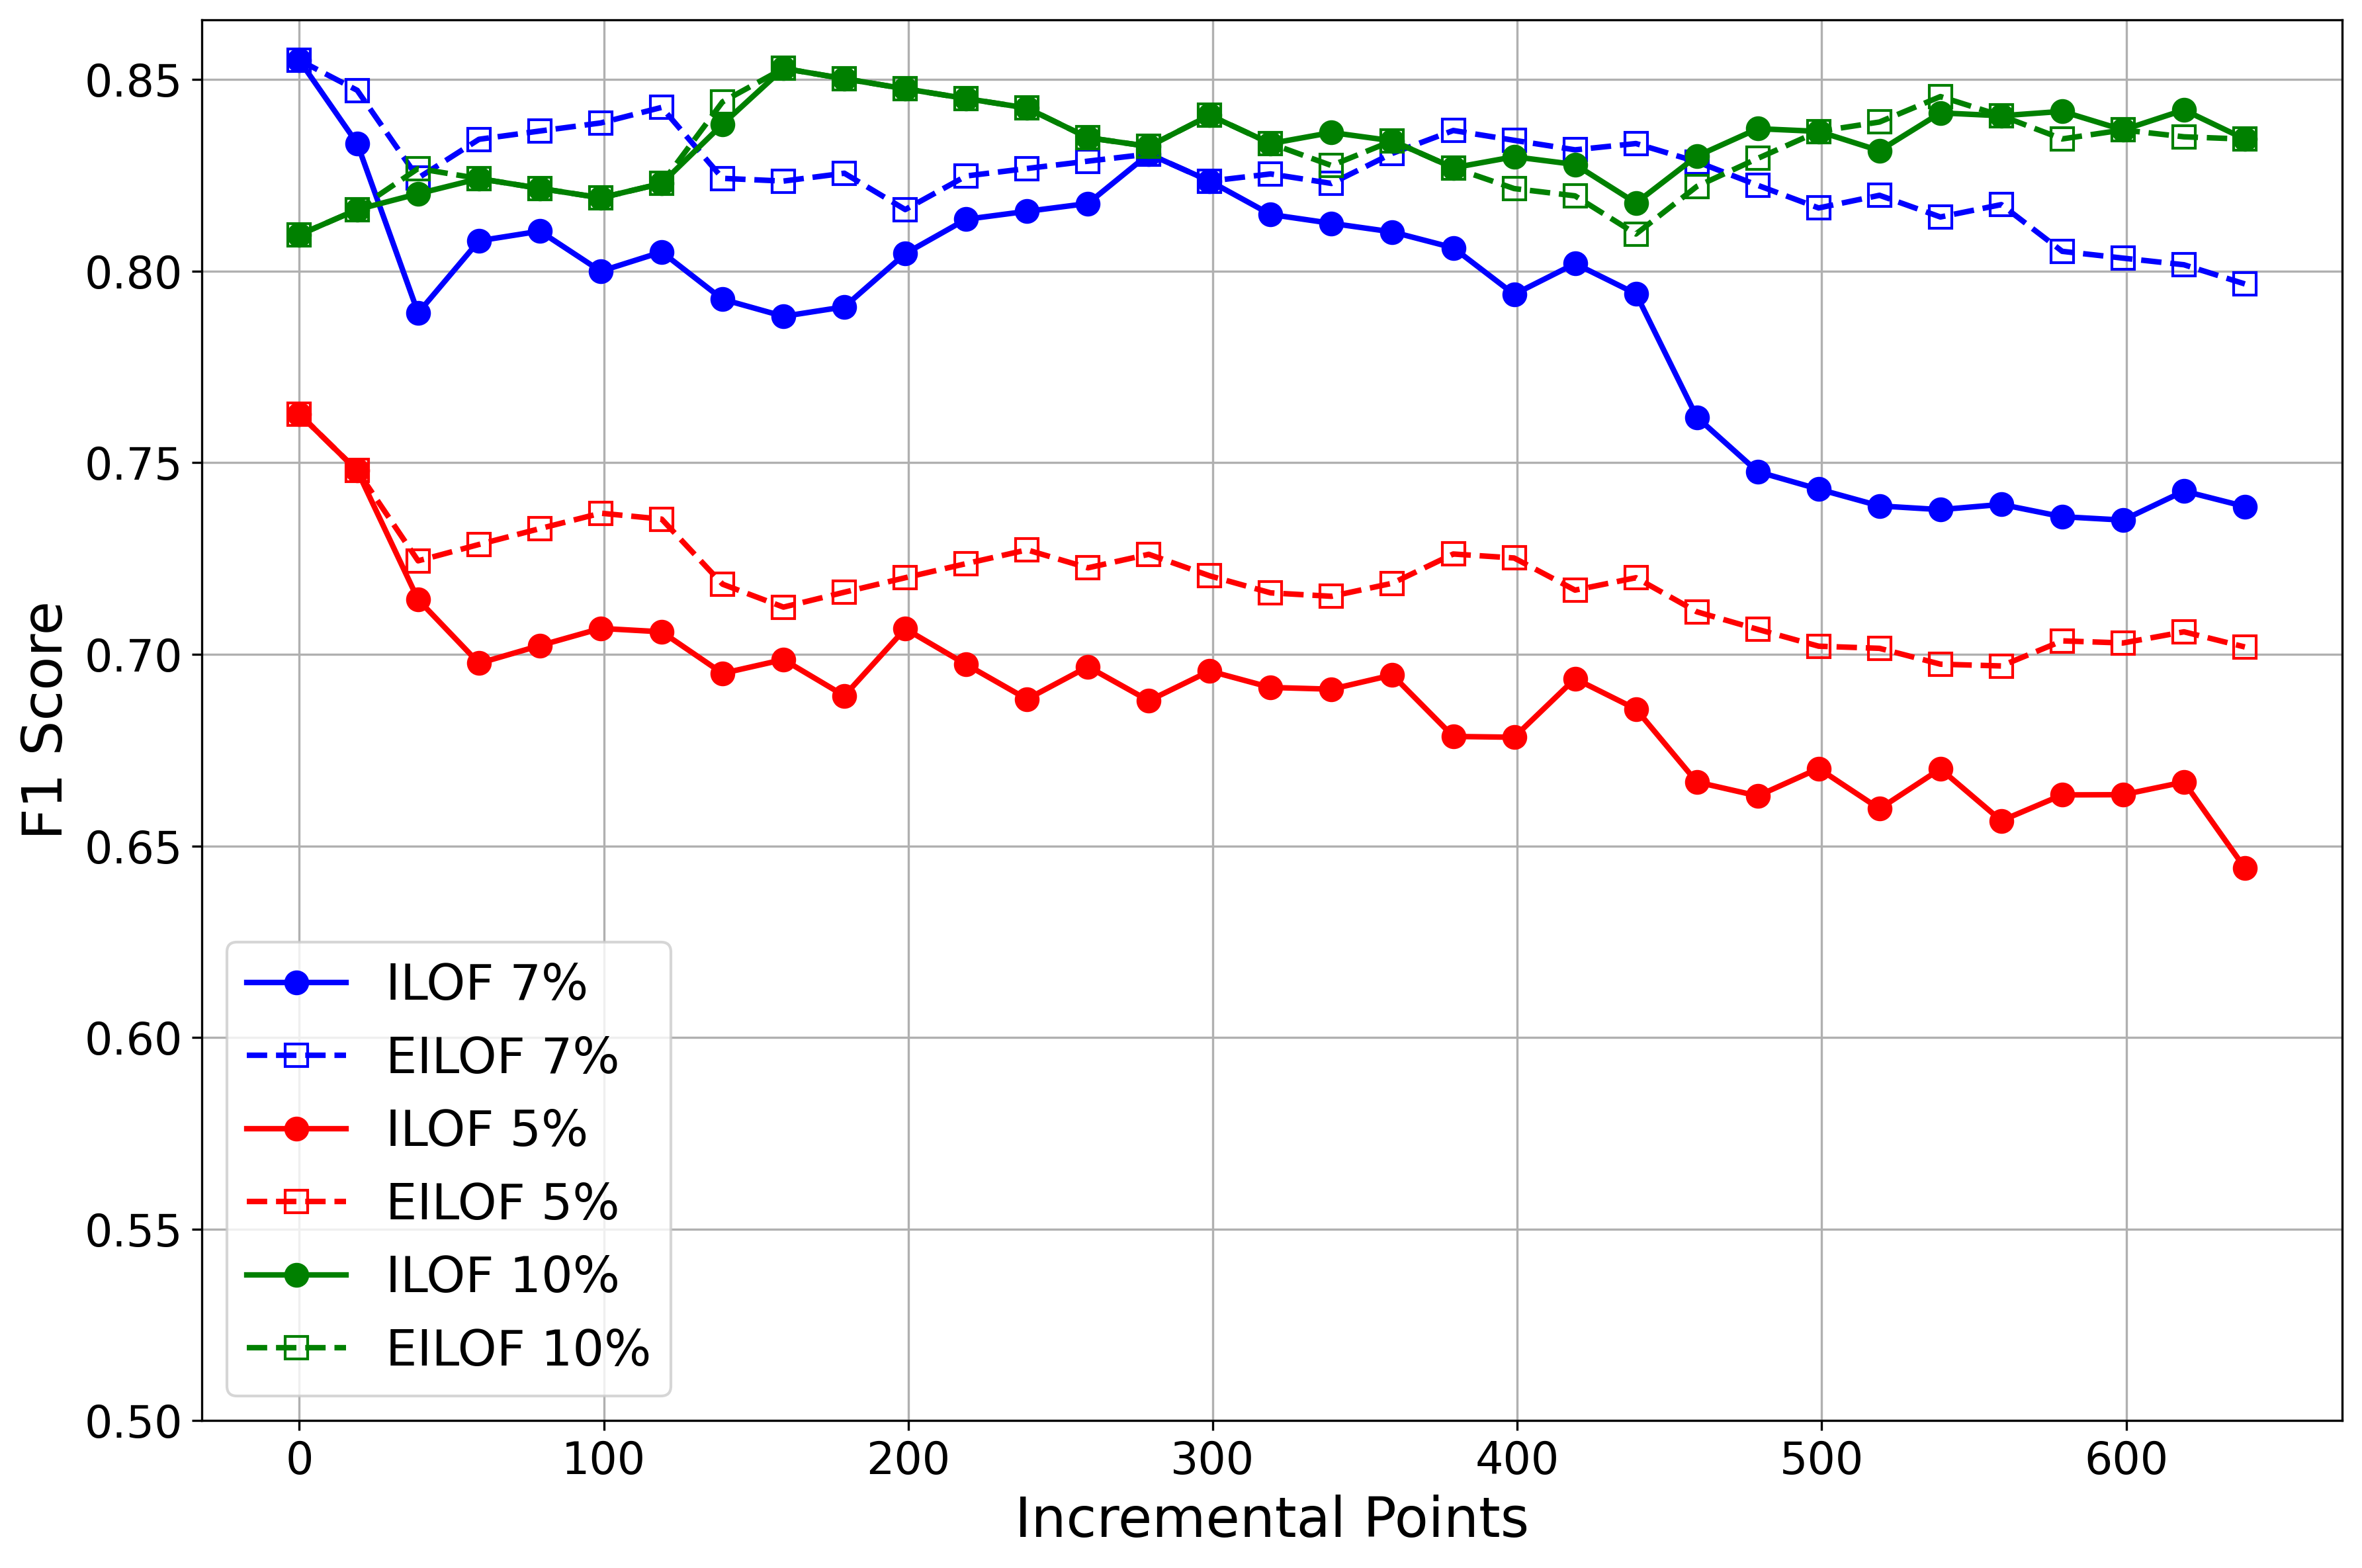

In [ ]:
x = range(len(f1_new_list_5_k150))

# Select key points every 20th point for clarity
key_points = np.insert(np.arange(19, len(f1_new_list_7_k150), 20), 0, 0)

# Create a high-resolution figure
plt.figure(figsize=(12, 8), dpi=300)  # Increased figure size and resolution (DPI)

# Plotting ILOF 7% and EILOF 7% with different markers
plt.plot(key_points, np.array(f1_list_7_k150), label='ILOF 7%', marker='o', color='blue', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list_7_k150)[key_points], label='EILOF 7%', marker='s', color='blue', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)

# Plotting ILOF 5% and EILOF 5% with different markers
plt.plot(key_points, np.array(f1_list_5_k150), label='ILOF 5%', marker='o', color='red', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list_5_k150)[key_points], label='EILOF 5%', marker='s', color='red', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)

# Plotting ILOF 10% and EILOF 10% with different markers
plt.plot(key_points, np.array(f1_list_10_k150), label='ILOF 10%', marker='o', color='green', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list_10_k150)[key_points], label='EILOF 10%', marker='s', color='green', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)

plt.xlabel('Incremental Points', fontsize=20)
plt.ylabel('F1 Score', fontsize=20)
plt.legend(fontsize=18, loc='lower left')
plt.xticks(fontsize=16)
plt.yticks(np.arange(0.5, 0.9, 0.05), fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300)
plt.show()

## Other Method

### ILOF

#### ILOF Thresholding with 5% Outlier Detection

In [157]:
from scipy.spatial.distance import cdist
from sklearn.metrics import f1_score
import numpy as np
import time

# Assumes these helper functions are defined:
# - k_nearest_neighbors
# - reachability_distance
# - local_reachability_density
# - lof_srs

# Setup
test_index = range(640)
k = 200
f1_ILOF_95_outliers = []

start_time = time.time()

# Loop: simulate online processing
for i in test_index:
    # Combine training data + streamed point(s)
    X_batch = np.vstack([selected_data, unselected_data[:i+1]])
    y_batch = np.concatenate([selected_labels, unselected_labels[:i+1]])

    # Distance matrix and LOF computation
    dist_matrix = cdist(X_batch, X_batch)
    neighbors = k_nearest_neighbors(dist_matrix, k)
    reach_dist = reachability_distance(dist_matrix, k)
    lrd = local_reachability_density(reach_dist, neighbors)
    lof = lof_srs(dist_matrix, neighbors, lrd, k)

    # Outlier detection
    threshold = np.percentile(lof, 95)
    preds = (lof > threshold).astype(int)

    # Evaluation
    f1 = f1_score(y_batch, preds)
    f1_ILOF_95_outliers.append(f1)

# Summary
elapsed_time = time.time() - start_time
average_f1_ILOF_95 = np.mean(f1_ILOF_95_outliers)

# Output
f1_ILOF_95_outliers, average_f1_ILOF_95, elapsed_time

([0.7796610169491526,
  0.7899159663865546,
  0.7899159663865546,
  0.7899159663865546,
  0.7899159663865546,
  0.7899159663865546,
  0.7899159663865546,
  0.7899159663865546,
  0.7899159663865546,
  0.7833333333333333,
  0.7768595041322314,
  0.7704918032786885,
  0.7704918032786885,
  0.7704918032786885,
  0.7642276422764228,
  0.7642276422764228,
  0.7642276422764228,
  0.7642276422764228,
  0.7642276422764228,
  0.7642276422764228,
  0.7642276422764228,
  0.768,
  0.768,
  0.768,
  0.768,
  0.768,
  0.768,
  0.7619047619047619,
  0.7619047619047619,
  0.7619047619047619,
  0.7619047619047619,
  0.746031746031746,
  0.746031746031746,
  0.746031746031746,
  0.746031746031746,
  0.746031746031746,
  0.746031746031746,
  0.746031746031746,
  0.746031746031746,
  0.7401574803149606,
  0.7401574803149606,
  0.75,
  0.7441860465116279,
  0.7441860465116279,
  0.7441860465116279,
  0.7441860465116279,
  0.7441860465116279,
  0.7441860465116279,
  0.7441860465116279,
  0.7441860465116279,


#### ILOF Thresholding with 7% Outlier Detection

In [158]:
from scipy.spatial.distance import cdist
from sklearn.metrics import f1_score
import numpy as np
import time

# Assumes these helper functions are defined:
# - k_nearest_neighbors
# - reachability_distance
# - local_reachability_density
# - lof_srs

# Setup
test_index = range(640)
k = 200
ILOF_93_outliers = []

start_time = time.time()

# Loop: simulate online processing
for i in test_index:
    # Combine training data + streamed point(s)
    X_batch = np.vstack([selected_data, unselected_data[:i+1]])
    y_batch = np.concatenate([selected_labels, unselected_labels[:i+1]])

    # Distance matrix and LOF computation
    dist_matrix = cdist(X_batch, X_batch)
    neighbors = k_nearest_neighbors(dist_matrix, k)
    reach_dist = reachability_distance(dist_matrix, k)
    lrd = local_reachability_density(reach_dist, neighbors)
    lof = lof_srs(dist_matrix, neighbors, lrd, k)

    # Outlier detection
    threshold = np.percentile(lof, 93)
    preds = (lof > threshold).astype(int)

    # Evaluation
    f1 = f1_score(y_batch, preds)
    ILOF_93_outliers.append(f1)

# Summary
elapsed_time = time.time() - start_time
average_ILOF_93 = np.mean(ILOF_93_outliers)

# Output
ILOF_93_outliers, average_ILOF_93, elapsed_time

([0.927536231884058,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.9285714285714286,
  0.9219858156028369,
  0.9295774647887324,
  0.9295774647887324,
  0.9154929577464789,
  0.9090909090909091,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9103448275862069,
  0.9103448275862069,
  0.9103448275862069,
  0.9103448275862069,
  0.9103448275862069,
  0.9103448275862069,
  0.9041095890410958,
  0.9041095890410958,
  0.9115646258503401,
  0.9115646258503401,
  0.8979591836734694,
  0.8979591836734694,
  0.8979591836734694,
  0.8979591836734694,
  0.8979591836734694,
  0.8979591836734694,
  0.8979591836734694,
  0.8979591836734694,
  0.8918918918918919,
  0.8918918918918919,
  0.8918918918918919,
  0.8859060402684564,
  0.8933333333333333,
  0.8933333333333333,
  0.893333333333333

#### ILOF Thresholding with 10% Outlier Detection

In [159]:
from scipy.spatial.distance import cdist
from sklearn.metrics import f1_score
import numpy as np
import time

# Assumes these helper functions are defined:
# - k_nearest_neighbors
# - reachability_distance
# - local_reachability_density
# - lof_srs

# Setup
test_index = range(640)
k = 200
ILOF_90_outliers = []

start_time = time.time()

# Loop: simulate online processing
for i in test_index:
    # Combine training data + streamed point(s)
    X_batch = np.vstack([selected_data, unselected_data[:i+1]])
    y_batch = np.concatenate([selected_labels, unselected_labels[:i+1]])

    # Distance matrix and LOF computation
    dist_matrix = cdist(X_batch, X_batch)
    neighbors = k_nearest_neighbors(dist_matrix, k)
    reach_dist = reachability_distance(dist_matrix, k)
    lrd = local_reachability_density(reach_dist, neighbors)
    lof = lof_srs(dist_matrix, neighbors, lrd, k)

    # Outlier detection
    threshold = np.percentile(lof, 90)
    preds = (lof > threshold).astype(int)

    # Evaluation
    f1 = f1_score(y_batch, preds)
    ILOF_90_outliers.append(f1)

# Summary
elapsed_time = time.time() - start_time
average_ILOF_90 = np.mean(ILOF_90_outliers)

# Output
ILOF_90_outliers, average_ILOF_90, elapsed_time

([0.8095238095238095,
  0.8047337278106509,
  0.8047337278106509,
  0.8047337278106509,
  0.8047337278106509,
  0.8047337278106509,
  0.8047337278106509,
  0.8047337278106509,
  0.8047337278106509,
  0.8,
  0.8070175438596491,
  0.8092485549132948,
  0.8092485549132948,
  0.8092485549132948,
  0.8208092485549133,
  0.8208092485549133,
  0.8208092485549133,
  0.8208092485549133,
  0.8208092485549133,
  0.8208092485549133,
  0.8208092485549133,
  0.8228571428571428,
  0.8181818181818182,
  0.8181818181818182,
  0.8181818181818182,
  0.8181818181818182,
  0.8181818181818182,
  0.8248587570621468,
  0.8248587570621468,
  0.8248587570621468,
  0.8248587570621468,
  0.8202247191011236,
  0.8248587570621468,
  0.8248587570621468,
  0.8248587570621468,
  0.8202247191011236,
  0.8202247191011236,
  0.8202247191011236,
  0.8248587570621468,
  0.8314606741573034,
  0.8314606741573034,
  0.8222222222222222,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0

### EILOF

#### EILOF Thresholding with 5% Outlier Detection

In [146]:
import time

# Initialize variables
test_index = range(640)
k = 200
f1_EILOF_90_outliers = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Start timing
start_time = time.time()

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 90th percentile of LOF scores
    threshold_incremental_new = np.percentile(model.lof_scores, 95)
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)
    labels_update = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update, predicted_labels)
    f1_EILOF_90_outliers.append(f1)

# Calculate the average F1 score over all 640 iterations
average_f1_640 = np.mean(f1_EILOF_90_outliers)

# Calculate elapsed time
elapsed_time = time.time() - start_time

# Output the results
f1_EILOF_90_outliers, average_f1_640, elapsed_time


([0.7796610169491526,
  0.7899159663865546,
  0.7899159663865546,
  0.7899159663865546,
  0.7899159663865546,
  0.7899159663865546,
  0.7899159663865546,
  0.7899159663865546,
  0.7899159663865546,
  0.7833333333333333,
  0.7768595041322314,
  0.7704918032786885,
  0.7704918032786885,
  0.7704918032786885,
  0.7642276422764228,
  0.7642276422764228,
  0.7642276422764228,
  0.7642276422764228,
  0.7642276422764228,
  0.7642276422764228,
  0.7642276422764228,
  0.768,
  0.768,
  0.768,
  0.768,
  0.768,
  0.768,
  0.7619047619047619,
  0.7619047619047619,
  0.7619047619047619,
  0.7619047619047619,
  0.746031746031746,
  0.746031746031746,
  0.746031746031746,
  0.746031746031746,
  0.746031746031746,
  0.746031746031746,
  0.746031746031746,
  0.746031746031746,
  0.7401574803149606,
  0.7401574803149606,
  0.75,
  0.7441860465116279,
  0.7441860465116279,
  0.7441860465116279,
  0.7441860465116279,
  0.7441860465116279,
  0.7441860465116279,
  0.7441860465116279,
  0.7441860465116279,


#### EILOF Thresholding with 7% Outlier Detection

In [147]:
# Use selected_index and unselected_index to get selected_data, unselected_data, selected_labels, and unselected_labels
selected_data = X[:1000].reset_index(drop=True).values
selected_labels = y[:1000].reset_index(drop=True).values
unselected_data = X[1000:22280].reset_index(drop=True).values
unselected_labels = y[1000:22280].reset_index(drop=True).values


In [160]:
import time

# Initialize variables
test_index = range(5000)
k = 200
f1_EILOF_93 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Start timing
start_time = time.time()

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 93rd percentile of LOF scores
    threshold_incremental_new = np.percentile(model.lof_scores, 93)
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)
    labels_update = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update, predicted_labels)
    f1_EILOF_93.append(f1)

# Calculate the average F1 score
average_f1 = np.mean(f1_EILOF_93)

# Calculate elapsed time
elapsed_time = time.time() - start_time

# Output the results
f1_EILOF_93, average_f1, elapsed_time




([0.927536231884058,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.9285714285714286,
  0.9219858156028369,
  0.9295774647887324,
  0.9295774647887324,
  0.9295774647887324,
  0.9230769230769231,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9241379310344827,
  0.9241379310344827,
  0.9241379310344827,
  0.9241379310344827,
  0.9241379310344827,
  0.9241379310344827,
  0.9178082191780822,
  0.9178082191780822,
  0.9251700680272109,
  0.9251700680272109,
  0.9115646258503401,
  0.9115646258503401,
  0.9115646258503401,
  0.9115646258503401,
  0.9115646258503401,
  0.9115646258503401,
  0.9115646258503401,
  0.9115646258503401,
  0.9054054054054054,
  0.9054054054054054,
  0.9054054054054054,
  0.8993288590604027,
  0.9066666666666666,
  0.9066666666666666,
  0.906666666666666

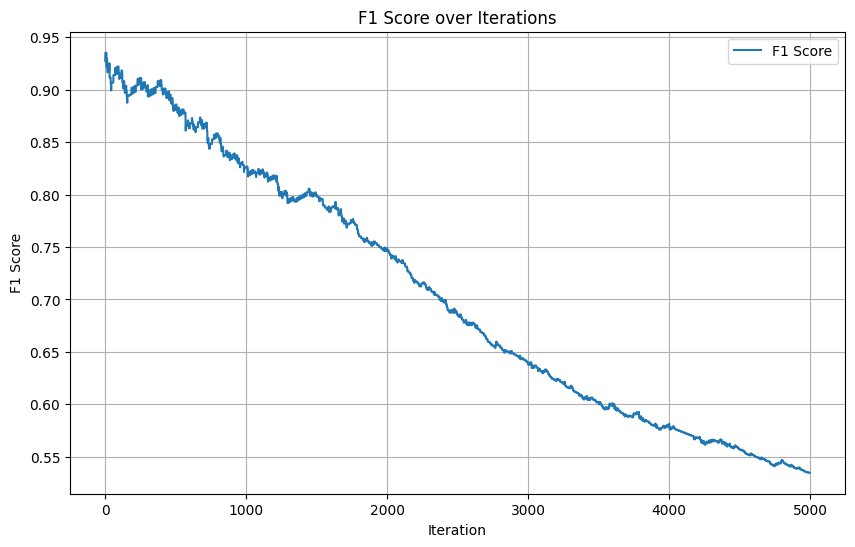

In [145]:
f1_EILOF_93

In [82]:
import time

# Initialize variables
test_index = range(640)
k = 200
f1_EILOF_93 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Start timing
start_time = time.time()

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 93rd percentile of LOF scores
    threshold_incremental_new = np.percentile(model.lof_scores, 93)
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)
    labels_update = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update, predicted_labels)
    f1_EILOF_93.append(f1)

# Calculate the average F1 score
average_f1 = np.mean(f1_EILOF_93)

# Calculate elapsed time
elapsed_time = time.time() - start_time

# Output the results
f1_EILOF_93, average_f1, elapsed_time




([0.927536231884058,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.9285714285714286,
  0.9219858156028369,
  0.9295774647887324,
  0.9295774647887324,
  0.9295774647887324,
  0.9230769230769231,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9241379310344827,
  0.9241379310344827,
  0.9241379310344827,
  0.9241379310344827,
  0.9241379310344827,
  0.9241379310344827,
  0.9178082191780822,
  0.9178082191780822,
  0.9251700680272109,
  0.9251700680272109,
  0.9115646258503401,
  0.9115646258503401,
  0.9115646258503401,
  0.9115646258503401,
  0.9115646258503401,
  0.9115646258503401,
  0.9115646258503401,
  0.9115646258503401,
  0.9054054054054054,
  0.9054054054054054,
  0.9054054054054054,
  0.8993288590604027,
  0.9066666666666666,
  0.9066666666666666,
  0.906666666666666

#### EILOF Thresholding with 10% Outlier Detection

In [83]:
import time

# Initialize variables
test_index = range(640)
k = 200
f1_EILOF_90 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Start timing
start_time = time.time()

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 90th percentile of LOF scores
    threshold_incremental_new = np.percentile(model.lof_scores, 90)
    predicted_labels = (model.lof_scores > threshold_incremental_new).astype(int)
    labels_update = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update, predicted_labels)
    f1_EILOF_90.append(f1)

# Calculate the average F1 score over all 640 iterations
average_f1_640 = np.mean(f1_EILOF_90)

# Calculate elapsed time
elapsed_time = time.time() - start_time

# Output the results
f1_EILOF_90, average_f1_640, elapsed_time


([0.8095238095238095,
  0.8047337278106509,
  0.8047337278106509,
  0.8047337278106509,
  0.8047337278106509,
  0.8047337278106509,
  0.8047337278106509,
  0.8047337278106509,
  0.8047337278106509,
  0.8,
  0.8070175438596491,
  0.8092485549132948,
  0.8092485549132948,
  0.8092485549132948,
  0.8208092485549133,
  0.8208092485549133,
  0.8208092485549133,
  0.8208092485549133,
  0.8208092485549133,
  0.8208092485549133,
  0.8208092485549133,
  0.8228571428571428,
  0.8228571428571428,
  0.8228571428571428,
  0.8228571428571428,
  0.8228571428571428,
  0.8228571428571428,
  0.8248587570621468,
  0.8248587570621468,
  0.8248587570621468,
  0.8248587570621468,
  0.8202247191011236,
  0.8202247191011236,
  0.8202247191011236,
  0.8202247191011236,
  0.8202247191011236,
  0.8202247191011236,
  0.8202247191011236,
  0.8202247191011236,
  0.8268156424581006,
  0.8268156424581006,
  0.8222222222222222,
  0.8287292817679558,
  0.8287292817679558,
  0.8287292817679558,
  0.8287292817679558,
  0

### Stochastic Outlier Selection (SOS)

#### Stochastic Outlier Selection (SOS) Thresholding with 5% Outlier Detection

In [ ]:
from sksos import SOS
from sklearn.metrics import f1_score
import numpy as np
import time

# Initialize
test_index = range(0, 640)
f1_new_list_sos = []

# Initial training data
X_train = selected_data.copy()
y_train = selected_labels.copy()

model = SOS(perplexity=750)

# Start timing
start_time = time.time()

# Streaming loop
for i in test_index:
    x_new = unselected_data[i].reshape(1, -1)
    y_new = unselected_labels[i]

    # Update training set
    X_train = np.vstack([X_train, x_new])
    y_train = np.append(y_train, y_new)

    # Compute outlier probabilities
    probs = model.predict(X_train)  # higher = more outlier
    threshold = np.percentile(probs, 95)
    preds = (probs > threshold).astype(int)

    # Compute F1
    f1 = f1_score(y_train, preds)
    f1_new_list_sos.append(f1)

# End timing
end_time = time.time()
run_time = end_time - start_time

# Calculate average F1 score
average_f1 = np.mean(f1_new_list_sos)

f1_new_list_sos, run_time, average_f1

/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: invalid value encountered in divide
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: invalid value encountered in divide
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWa

([0.7457627118644068,
  0.7563025210084033,
  0.7563025210084033,
  0.7563025210084033,
  0.7563025210084033,
  0.7563025210084033,
  0.7563025210084033,
  0.7563025210084033,
  0.7563025210084033,
  0.75,
  0.743801652892562,
  0.7377049180327869,
  0.7377049180327869,
  0.7377049180327869,
  0.7317073170731707,
  0.7317073170731707,
  0.7317073170731707,
  0.7317073170731707,
  0.7317073170731707,
  0.7317073170731707,
  0.7317073170731707,
  0.736,
  0.736,
  0.736,
  0.736,
  0.736,
  0.736,
  0.7301587301587301,
  0.7301587301587301,
  0.7301587301587301,
  0.7301587301587301,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7086614173228346,
  0.7086614173228346,
  0.71875,
  0.7131782945736435,
  0.7131782945736435,
  0.7131782945736435,
  0.7131782945736435,
  0.7131782945736435,
  0.7131782945736435,
  0.7131782945736435,
  0.7131782945736435,
  0.

#### Stochastic Outlier Selection (SOS) Thresholding with 7% Outlier Detection

In [59]:
from sksos import SOS
from sklearn.metrics import f1_score
import numpy as np
import time

# Initialize
test_index = range(0, 640)
f1_sos_93 = []

# Initial training data
X_train = selected_data.copy()
y_train = selected_labels.copy()

model = SOS(perplexity=750)

# Start timing
start_time = time.time()

# Streaming loop
for i in test_index:
    x_new = unselected_data[i].reshape(1, -1)
    y_new = unselected_labels[i]

    # Update training set
    X_train = np.vstack([X_train, x_new])
    y_train = np.append(y_train, y_new)

    # Compute outlier probabilities
    probs = model.predict(X_train)  # higher = more outlier
    threshold = np.percentile(probs, 93)
    preds = (probs > threshold).astype(int)

    # Compute F1
    f1 = f1_score(y_train, preds)
    f1_sos_93.append(f1)

# End timing
end_time = time.time()
run_time_sos_93 = end_time - start_time

# Calculate average F1 score
average_f1_sos_93 = np.mean(f1_sos_93)

f1_sos_93, run_time_sos_93, average_f1_sos_93

/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: invalid value encountered in divide
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: invalid value encountered in divide
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWa

([0.927536231884058,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.9285714285714286,
  0.9219858156028369,
  0.9154929577464789,
  0.9154929577464789,
  0.9154929577464789,
  0.9090909090909091,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9166666666666666,
  0.9103448275862069,
  0.9103448275862069,
  0.9103448275862069,
  0.9103448275862069,
  0.9103448275862069,
  0.9103448275862069,
  0.9041095890410958,
  0.9041095890410958,
  0.9115646258503401,
  0.9115646258503401,
  0.8979591836734694,
  0.8843537414965986,
  0.8843537414965986,
  0.8843537414965986,
  0.8843537414965986,
  0.8843537414965986,
  0.8843537414965986,
  0.8843537414965986,
  0.8783783783783784,
  0.8783783783783784,
  0.8783783783783784,
  0.87248322147651,
  0.88,
  0.88,
  0.88,
  0.88,
  0.88,
  0.88,
  0.88,
  0.88,
 

#### Stochastic Outlier Selection (SOS) Thresholding with 10% Outlier Detection

In [56]:
from sksos import SOS
from sklearn.metrics import f1_score
import numpy as np
import time

# Initialize
test_index = range(0, 640)
f1_sos_90 = []

# Initial training data
X_train = selected_data.copy()
y_train = selected_labels.copy()

model = SOS(perplexity=750)

# Start timing
start_time = time.time()

# Streaming loop
for i in test_index:
    x_new = unselected_data[i].reshape(1, -1)
    y_new = unselected_labels[i]

    # Update training set
    X_train = np.vstack([X_train, x_new])
    y_train = np.append(y_train, y_new)

    # Compute outlier probabilities
    probs = model.predict(X_train)  # higher = more outlier
    threshold = np.percentile(probs, 90)
    preds = (probs > threshold).astype(int)

    # Compute F1
    f1 = f1_score(y_train, preds)
    f1_sos_90.append(f1)

# End timing
end_time = time.time()
run_time_sos_90 = end_time - start_time

# Calculate average F1 score
average_f1_sos_90 = np.mean(f1_sos_90)

f1_sos_90, run_time_sos_90, average_f1_sos_90

/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: invalid value encountered in divide
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: invalid value encountered in divide
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumA) + beta * np.sum(D * A) / sumA
/Users/lucchen/Desktop/eilof/.venv/lib/python3.11/site-packages/sksos/sos.py:134: RuntimeWa

([0.7976190476190477,
  0.7928994082840237,
  0.7928994082840237,
  0.7928994082840237,
  0.7928994082840237,
  0.7928994082840237,
  0.7928994082840237,
  0.7928994082840237,
  0.7928994082840237,
  0.8,
  0.8070175438596491,
  0.8092485549132948,
  0.8092485549132948,
  0.8092485549132948,
  0.8160919540229885,
  0.8160919540229885,
  0.8160919540229885,
  0.8160919540229885,
  0.8160919540229885,
  0.8160919540229885,
  0.8160919540229885,
  0.8181818181818182,
  0.8181818181818182,
  0.8181818181818182,
  0.8181818181818182,
  0.8181818181818182,
  0.8181818181818182,
  0.8248587570621468,
  0.8248587570621468,
  0.8248587570621468,
  0.8248587570621468,
  0.8202247191011236,
  0.8202247191011236,
  0.8202247191011236,
  0.8202247191011236,
  0.8202247191011236,
  0.8202247191011236,
  0.8202247191011236,
  0.8202247191011236,
  0.8268156424581006,
  0.8268156424581006,
  0.8222222222222222,
  0.8287292817679558,
  0.8287292817679558,
  0.8287292817679558,
  0.8287292817679558,
  0

### Isolation Forest

#### Isolation Forest Thresholding with 5% Outlier Detection

In [80]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import numpy as np
import time

# Initialize
test_index = range(640)
f1_IsolationForest_95_outliers = []

X_train = selected_data.copy()
y_train = selected_labels.copy()
model = IsolationForest(n_estimators=200, contamination='auto', random_state=42)

# Fit once initially
model.fit(X_train)

# Predict and evaluate once on initial set
scores = -model.decision_function(X_train)
threshold = np.percentile(scores, 95)
preds = (scores > threshold).astype(int)
f1 = f1_score(y_train, preds)
f1_IsolationForest_95_outliers.append(f1)

# Start streaming
start_time = time.time()
for i in test_index:
    x_new = unselected_data[i].reshape(1, -1)
    y_new = unselected_labels[i]

    # Update training data
    X_train = np.vstack([X_train, x_new])
    y_train = np.append(y_train, y_new)

    # Retrain periodically (every 10 steps)
    if i % 10 == 0:
        model.fit(X_train)

    # Score all points
    scores = -model.decision_function(X_train)
    threshold = np.percentile(scores, 95)
    preds = (scores > threshold).astype(int)

    # F1 score
    f1 = f1_score(y_train, preds)
    f1_IsolationForest_95_outliers.append(f1)

# Calculate average F1 score
average_f1_IsolationForest_95_outliers = np.mean(f1_IsolationForest_95_outliers)

# Calculate elapsed time
elapsed_time_IsolationForest_95_outliers = time.time() - start_time

f1_IsolationForest_95_outliers, average_f1_IsolationForest_95_outliers, elapsed_time_IsolationForest_95_outliers

([0.8135593220338984,
  0.8135593220338984,
  0.8235294117647058,
  0.8235294117647058,
  0.8235294117647058,
  0.8235294117647058,
  0.8235294117647058,
  0.8235294117647058,
  0.8235294117647058,
  0.8235294117647058,
  0.8166666666666667,
  0.8099173553719008,
  0.8032786885245902,
  0.8032786885245902,
  0.8032786885245902,
  0.7967479674796748,
  0.7967479674796748,
  0.7967479674796748,
  0.7967479674796748,
  0.7967479674796748,
  0.7967479674796748,
  0.7868852459016393,
  0.7903225806451613,
  0.7903225806451613,
  0.7903225806451613,
  0.7903225806451613,
  0.7903225806451613,
  0.7903225806451613,
  0.7936507936507936,
  0.7936507936507936,
  0.7936507936507936,
  0.7936507936507936,
  0.7936507936507936,
  0.7936507936507936,
  0.7936507936507936,
  0.7936507936507936,
  0.7936507936507936,
  0.7936507936507936,
  0.7936507936507936,
  0.7936507936507936,
  0.7874015748031497,
  0.7874015748031497,
  0.796875,
  0.7906976744186046,
  0.7906976744186046,
  0.7906976744186046

#### Isolation Forest Thresholding with 7% Outlier Detection

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import numpy as np
import time

# Initialize
test_index = range(640)
f1_iforest_93 = []

X_train = selected_data.copy()
y_train = selected_labels.copy()
model = IsolationForest(n_estimators=200, contamination='auto', random_state=42)

# Fit once initially
model.fit(X_train)

# Predict and evaluate once on initial set
scores = -model.decision_function(X_train)
threshold = np.percentile(scores, 95)
preds = (scores > threshold).astype(int)
f1 = f1_score(y_train, preds)
f1_iforest_93.append(f1)

# Start streaming
start_time = time.time()
for i in test_index:
    x_new = unselected_data[i].reshape(1, -1)
    y_new = unselected_labels[i]

    # Update training data
    X_train = np.vstack([X_train, x_new])
    y_train = np.append(y_train, y_new)

    # Retrain periodically (every 10 steps)
    if i % 10 == 0:
        model.fit(X_train)

    # Score all points
    scores = -model.decision_function(X_train)
    threshold = np.percentile(scores, 93)
    preds = (scores > threshold).astype(int)

    # F1 score
    f1 = f1_score(y_train, preds)
    f1_iforest_93.append(f1)

# Calculate average F1 score
average_f1 = np.mean(f1_iforest_93)

# Calculate elapsed time
elapsed_time = time.time() - start_time

f1_iforest_93, average_f1, elapsed_time

([0.8135593220338984,
  0.927536231884058,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.935251798561151,
  0.9285714285714286,
  0.9078014184397163,
  0.9014084507042254,
  0.9014084507042254,
  0.9014084507042254,
  0.8951048951048951,
  0.9027777777777778,
  0.9027777777777778,
  0.9027777777777778,
  0.9027777777777778,
  0.9027777777777778,
  0.8888888888888888,
  0.896551724137931,
  0.896551724137931,
  0.896551724137931,
  0.896551724137931,
  0.896551724137931,
  0.896551724137931,
  0.9041095890410958,
  0.9041095890410958,
  0.8979591836734694,
  0.8843537414965986,
  0.8843537414965986,
  0.8707482993197279,
  0.8707482993197279,
  0.8707482993197279,
  0.8707482993197279,
  0.8707482993197279,
  0.8707482993197279,
  0.8707482993197279,
  0.8783783783783784,
  0.8648648648648649,
  0.8648648648648649,
  0.8590604026845637,
  0.8666666666666667,
  0.8666666666666667,
  0

#### Isolation Forest Thresholding with 10% Outlier Detection

In [79]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import numpy as np
import time

# Initialize
test_index = range(640)
f1_iforest_90_outliers = []

X_train = selected_data.copy()
y_train = selected_labels.copy()
model = IsolationForest(n_estimators=200, contamination='auto', random_state=42)

# Fit once initially
model.fit(X_train)

# Predict and evaluate once on initial set
scores = -model.decision_function(X_train)
threshold = np.percentile(scores, 95)
preds = (scores > threshold).astype(int)
f1 = f1_score(y_train, preds)
f1_iforest_90_outliers.append(f1)

# Start streaming
start_time = time.time()
for i in test_index:
    x_new = unselected_data[i].reshape(1, -1)
    y_new = unselected_labels[i]

    # Update training data
    X_train = np.vstack([X_train, x_new])
    y_train = np.append(y_train, y_new)

    # Retrain periodically (every 10 steps)
    if i % 10 == 0:
        model.fit(X_train)

    # Score all points
    scores = -model.decision_function(X_train)
    threshold = np.percentile(scores, 90)
    preds = (scores > threshold).astype(int)

    # F1 score
    f1 = f1_score(y_train, preds)
    f1_iforest_90_outliers.append(f1)

# Calculate average F1 score
average_f1 = np.mean(f1_iforest_90_outliers)

# Calculate elapsed time
elapsed_time = time.time() - start_time

# Calculate average of all 640 F1 scores and add elapsed time
average_f1_all = np.mean(f1_iforest_90_outliers)
f1_iforest_90_outliers, average_f1_all, elapsed_time

([0.8135593220338984,
  0.7976190476190477,
  0.7928994082840237,
  0.7928994082840237,
  0.7928994082840237,
  0.7928994082840237,
  0.7928994082840237,
  0.7928994082840237,
  0.7928994082840237,
  0.7928994082840237,
  0.788235294117647,
  0.7953216374269005,
  0.7976878612716763,
  0.7976878612716763,
  0.7976878612716763,
  0.8045977011494253,
  0.8045977011494253,
  0.8045977011494253,
  0.8045977011494253,
  0.8045977011494253,
  0.8045977011494253,
  0.8045977011494253,
  0.8068181818181818,
  0.8068181818181818,
  0.8068181818181818,
  0.8068181818181818,
  0.8068181818181818,
  0.8068181818181818,
  0.8135593220338984,
  0.8135593220338984,
  0.8135593220338984,
  0.8135593220338984,
  0.8089887640449438,
  0.8089887640449438,
  0.8089887640449438,
  0.8089887640449438,
  0.8089887640449438,
  0.8089887640449438,
  0.8089887640449438,
  0.8089887640449438,
  0.8156424581005587,
  0.8156424581005587,
  0.8111111111111111,
  0.8176795580110497,
  0.8176795580110497,
  0.8176795

### One-Class SVM

#### One-Class SVM Thresholding with 5% Outlier Detection

In [128]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import numpy as np

# Initialize
test_index = range(640)
f1_new_list_ocsvm = []

# Initial scaler and model
scaler = StandardScaler()
X_train = selected_data.copy()
y_train = selected_labels.copy()

# Train scaler and model
X_scaled = scaler.fit_transform(X_train)
model = OneClassSVM(kernel='sigmoid', nu=0.0005, gamma=0.01)
model.fit(X_scaled)

# Streaming loop
for i in test_index:
    x_new = unselected_data[i].reshape(1, -1)
    y_new = unselected_labels[i]

    # Add new data to training set
    X_train = np.vstack([X_train, x_new])
    y_train = np.append(y_train, y_new)

    # Re-scale and re-train
    X_scaled = scaler.fit_transform(X_train)
    model.fit(X_scaled)

    # Get decision function values (lower = more outlier)
    scores = -model.decision_function(X_scaled)
    threshold = np.percentile(scores, 95)
    preds = (scores > threshold).astype(int)

    # F1 score
    f1 = f1_score(y_train, preds)
    f1_new_list_ocsvm.append(f1)

# Calculate average F1 score for all 640 evaluations
average_f1_all = np.mean(f1_new_list_ocsvm)

# Output the evaluation metric as method + outlier percentage
evaluation_metric = f"OneClassSVM_95: {average_f1_all}"

evaluation_metric, f1_new_list_ocsvm

('OneClassSVM_95: 0.7050959775856308',
 [0.6949152542372882,
  0.6890756302521008,
  0.6890756302521008,
  0.6890756302521008,
  0.6890756302521008,
  0.6890756302521008,
  0.6890756302521008,
  0.6890756302521008,
  0.6890756302521008,
  0.6833333333333333,
  0.6942148760330579,
  0.7049180327868853,
  0.7049180327868853,
  0.7049180327868853,
  0.7154471544715447,
  0.7154471544715447,
  0.7154471544715447,
  0.7154471544715447,
  0.7154471544715447,
  0.7154471544715447,
  0.7154471544715447,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.7301587301587301,
  0.7301587301587301,
  0.7301587301587301,
  0.7301587301587301,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7086614173228346,
  0.7086614173228346,
  0.71875,
  0.7131782945736435,
  0.7131782945736435,
  0.7131782945736435,
  0.7131782945736435,
  0.7131782945736435,
  0.7131782945736435,


#### One-Class SVM Thresholding with 7% Outlier Detection

In [127]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import numpy as np

# Initialize
test_index = range(640)
f1_new_list_ocsvm = []

# Initial scaler and model
scaler = StandardScaler()
X_train = selected_data.copy()
y_train = selected_labels.copy()

# Train scaler and model
X_scaled = scaler.fit_transform(X_train)
model = OneClassSVM(kernel='sigmoid', nu=0.0005, gamma=0.01)
model.fit(X_scaled)

# Streaming loop
for i in test_index:
    x_new = unselected_data[i].reshape(1, -1)
    y_new = unselected_labels[i]

    # Add new data to training set
    X_train = np.vstack([X_train, x_new])
    y_train = np.append(y_train, y_new)

    # Re-scale and re-train
    X_scaled = scaler.fit_transform(X_train)
    model.fit(X_scaled)

    # Get decision function values (lower = more outlier)
    scores = -model.decision_function(X_scaled)
    threshold = np.percentile(scores, 93)
    preds = (scores > threshold).astype(int)

    # F1 score
    f1 = f1_score(y_train, preds)
    f1_new_list_ocsvm.append(f1)

# Calculate average F1 score for all 640 evaluations
average_f1_all = np.mean(f1_new_list_ocsvm)

# Output the evaluation metric as method + outlier percentage
evaluation_metric = f"OneClassSVM_93: {average_f1_all}"

evaluation_metric, f1_new_list_ocsvm

('OneClassSVM_93: 0.6843019128000428',
 [0.6376811594202898,
  0.6330935251798561,
  0.6330935251798561,
  0.6330935251798561,
  0.6330935251798561,
  0.6330935251798561,
  0.6330935251798561,
  0.6330935251798561,
  0.6330935251798561,
  0.6428571428571429,
  0.6382978723404256,
  0.647887323943662,
  0.647887323943662,
  0.647887323943662,
  0.6573426573426573,
  0.6527777777777778,
  0.6527777777777778,
  0.6527777777777778,
  0.6527777777777778,
  0.6527777777777778,
  0.6527777777777778,
  0.6620689655172414,
  0.6620689655172414,
  0.6620689655172414,
  0.6620689655172414,
  0.6620689655172414,
  0.6620689655172414,
  0.6712328767123288,
  0.6712328767123288,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6756756756756757,
  0.6756756756756757,
  0.6756756756756757,
  0.6711409395973155,
  0.66666666666666

#### One-Class SVM Thresholding with 10% Outlier Detection

In [129]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import numpy as np

# Initialize
test_index = range(640)
f1_new_list_ocsvm = []

# Initial scaler and model
scaler = StandardScaler()
X_train = selected_data.copy()
y_train = selected_labels.copy()

# Train scaler and model
X_scaled = scaler.fit_transform(X_train)
model = OneClassSVM(kernel='sigmoid', nu=0.0005, gamma=0.01)
model.fit(X_scaled)

# Streaming loop
for i in test_index:
    x_new = unselected_data[i].reshape(1, -1)
    y_new = unselected_labels[i]

    # Add new data to training set
    X_train = np.vstack([X_train, x_new])
    y_train = np.append(y_train, y_new)

    # Re-scale and re-train
    X_scaled = scaler.fit_transform(X_train)
    model.fit(X_scaled)

    # Get decision function values (lower = more outlier)
    scores = -model.decision_function(X_scaled)
    threshold = np.percentile(scores, 90)
    preds = (scores > threshold).astype(int)

    # F1 score
    f1 = f1_score(y_train, preds)
    f1_new_list_ocsvm.append(f1)

# Calculate average F1 score for all 640 evaluations
average_f1_all = np.mean(f1_new_list_ocsvm)

# Output the evaluation metric as method + outlier percentage
evaluation_metric = f"OneClassSVM_90: {average_f1_all}"

evaluation_metric, f1_new_list_ocsvm

('OneClassSVM_90: 0.5773957266938841',
 [0.5238095238095238,
  0.5207100591715976,
  0.5207100591715976,
  0.5207100591715976,
  0.5207100591715976,
  0.5207100591715976,
  0.5207100591715976,
  0.5207100591715976,
  0.5207100591715976,
  0.5294117647058824,
  0.5380116959064327,
  0.5433526011560693,
  0.5433526011560693,
  0.5433526011560693,
  0.5517241379310345,
  0.5517241379310345,
  0.5517241379310345,
  0.5517241379310345,
  0.5517241379310345,
  0.5517241379310345,
  0.5517241379310345,
  0.5568181818181818,
  0.5568181818181818,
  0.5568181818181818,
  0.5568181818181818,
  0.5568181818181818,
  0.5568181818181818,
  0.5649717514124294,
  0.5649717514124294,
  0.5649717514124294,
  0.5649717514124294,
  0.5617977528089888,
  0.5617977528089888,
  0.5617977528089888,
  0.5617977528089888,
  0.5617977528089888,
  0.5617977528089888,
  0.5617977528089888,
  0.5617977528089888,
  0.5698324022346368,
  0.5698324022346368,
  0.5666666666666667,
  0.56353591160221,
  0.5635359116022

In [ ]:
import numpy as np
import torch
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from deepod.models import DeepSVDD
from torch.utils.data import TensorDataset, DataLoader

# Configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 64
epochs = 100
lr = 1e-4

# Initialize scaler and model
scaler = StandardScaler()
X_train = selected_data.copy()
y_train = selected_labels.copy()
X_train = scaler.fit_transform(X_train)

clf = DeepSVDD(epochs=epochs, lr=lr, device=device)

# Initial fit
clf.fit(X_train)

# Streaming setup
f1_new_list_deepsvdd = []
test_index = range(50)

# Loop over stream
for i in test_index:
    x_new = unselected_data[i].reshape(1, -1)
    y_new = unselected_labels[i]

    # Update train set
    X_train = np.vstack([X_train, scaler.transform(x_new)])
    y_train = np.append(y_train, y_new)

    # Validation split
    X_train_part, X_val = train_test_split(X_train, test_size=0.05, random_state=42)

    # Reinitialize model
    clf = DeepSVDD(epochs=epochs, lr=lr, device=device)

    # Re-train on updated data
    clf.fit(X_train_part)

    # Predict scores
    scores = clf.decision_function(X_train)
    threshold = np.percentile(scores, 90)
    preds = (scores > threshold).astype(int)

    # F1 score
    f1 = f1_score(y_train, preds)
    f1_new_list_deepsvdd.append(f1)

# Result
f1_new_list_deepsvdd

Start Training...
ensemble size: 1
MLPnet(
  (network): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=7, out_features=100, bias=False)
      (act_layer): ReLU()
    )
    (1): LinearBlock(
      (linear): Linear(in_features=100, out_features=50, bias=False)
      (act_layer): ReLU()
    )
    (2): LinearBlock(
      (linear): Linear(in_features=50, out_features=128, bias=False)
      (act_layer): Identity()
    )
  )
)
epoch1, training loss: 1.543948, time: 0.0s
epoch10, training loss: 0.587880, time: 0.0s
epoch20, training loss: 0.253452, time: 0.0s
epoch30, training loss: 0.138654, time: 0.0s
epoch40, training loss: 0.088146, time: 0.0s
epoch50, training loss: 0.056504, time: 0.0s
epoch60, training loss: 0.042060, time: 0.0s
epoch70, training loss: 0.033866, time: 0.0s
epoch80, training loss: 0.028840, time: 0.0s
epoch90, training loss: 0.024547, time: 0.0s
epoch100, training loss: 0.021926, time: 0.0s
Start Inference on the training data...
Start Training...
e

[0.38095238095238093,
 0.35502958579881655,
 0.35502958579881655,
 0.35502958579881655,
 0.3431952662721893,
 0.378698224852071,
 0.3431952662721893,
 0.35502958579881655,
 0.378698224852071,
 0.4,
 0.4093567251461988,
 0.3352601156069364,
 0.3352601156069364,
 0.3236994219653179,
 0.39080459770114945,
 0.3448275862068966,
 0.367816091954023,
 0.367816091954023,
 0.367816091954023,
 0.4367816091954023,
 0.367816091954023,
 0.3409090909090909,
 0.375,
 0.36363636363636365,
 0.3409090909090909,
 0.36363636363636365,
 0.4090909090909091,
 0.4067796610169492,
 0.327683615819209,
 0.3502824858757062,
 0.384180790960452,
 0.34831460674157305,
 0.3258426966292135,
 0.33707865168539325,
 0.34831460674157305,
 0.34831460674157305,
 0.3258426966292135,
 0.33707865168539325,
 0.4044943820224719,
 0.3687150837988827,
 0.37988826815642457,
 0.35555555555555557,
 0.3425414364640884,
 0.3425414364640884,
 0.3425414364640884,
 0.36464088397790057,
 0.36464088397790057,
 0.35555555555555557,
 0.3314917

# Credit Card Dataset
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [161]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

ModuleNotFoundError: No module named 'kagglehub'

In [ ]:
csv_file = os.path.join(path, "creditcard.csv") 
data = pd.read_csv(csv_file)
data.head()


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [ ]:
# Identify outliers and non-outliers
outliers = data[data['Class'] == 1]
non_outliers = data[data['Class'] == 0]

# Calculate the number of non-outliers required
n_outliers = len(outliers)  # Total number of outliers
required_total = n_outliers / 0.05  # Total rows needed for 5% outliers
required_non_outliers = int(required_total - n_outliers)

# Randomly sample the required number of non-outliers
non_outliers_sampled = non_outliers.sample(n=required_non_outliers, random_state=42)

# Combine outliers and sampled non-outliers
subset = pd.concat([outliers, non_outliers_sampled])

# Maintain time-series order
subset = subset.sort_index()

# Verify the outlier ratio
actual_outlier_ratio = len(subset[subset['Class'] == 1]) / len(subset)
print(f"Outlier Ratio in Subset: {actual_outlier_ratio:.2%}")
# Display the subset
subset.head()


Outlier Ratio in Subset: 5.00%


Time        V1        V2        V3        V4        V5        V6  \
0    0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
16  12.0  1.103215 -0.040296  1.267332  1.289091 -0.735997  0.288069   
24  22.0 -1.946525 -0.044901 -0.405570 -1.013057  2.941968  2.955053   
26  23.0  1.173285  0.353498  0.283905  1.133563 -0.172577 -0.916054   
41  32.0 -2.008872  2.198527  0.144242  1.159432 -0.815174  0.182288   

          V7        V8        V9  ...       V21       V22       V23       V24  \
0   0.239599  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928   
16 -0.586057  0.189380  0.782333  ... -0.024612  0.196002  0.013802  0.103758   
24 -0.063063  0.855546  0.049967  ... -0.579526 -0.799229  0.870300  0.983421   
26  0.369025 -0.327260 -0.246651  ...  0.067003  0.227812 -0.150487  0.435045   
41 -0.617108  1.530817 -0.586832  ...  0.094917  0.294983  0.011081  0.015249   

         V25       V26       V27       V28  Amount  Class  
0   0.128539 -0.189115  0.133558 -0.021053  149.62      0  
16  0.364298 -0.382261  0.092809  0.037051   12.99      0  
24  0.321201  0.149650  0.707519  0.014600    0.89      0  
26  0.724825 -0.337082  0.016368  0.030041   41.88      0  
41  0.034211 -0.236141  0.128291  0.117986    2.35      0  

[5 rows x 31 columns]

In [ ]:
data = subset.drop(columns=['Class'])
label = subset["Class"]
# Initialize selected and unselected datasets
selected_data = data[:1000].reset_index(drop=True).values
selected_labels = label[:1000].reset_index(drop=True).values
unselected_data = data[1000:2280].reset_index(drop=True).values
unselected_labels = label[1000:2280].reset_index(drop=True).values
scaler = StandardScaler()
selected_data = scaler.fit_transform(selected_data)
scaler = StandardScaler()
unselected_data = scaler.fit_transform(unselected_data)

## Fig. 10(a)

### Incremental LOF Thresholding with 5% Outlier Detection and $k$ = 50

In [ ]:
test_index = range(0,640)
k = 50
f1_list5 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    threshold_incremental_new = np.percentile(lof_og, 95)

    # Classify points based on the threshold
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list5.append(f1)
f1_list5

[0.27972027972027974,
 0.2777777777777778,
 0.27586206896551724,
 0.272108843537415,
 0.24836601307189543,
 0.24203821656050956,
 0.24050632911392406,
 0.25157232704402516,
 0.25,
 0.2484472049689441,
 0.24539877300613497,
 0.25609756097560976,
 0.2545454545454545,
 0.26506024096385544,
 0.2754491017964072,
 0.27380952380952384,
 0.27218934911242604,
 0.2823529411764706,
 0.29239766081871343,
 0.2658959537572254,
 0.26285714285714284,
 0.22598870056497175,
 0.21348314606741572,
 0.20652173913043478,
 0.2094240837696335,
 0.19900497512437812,
 0.19230769230769232,
 0.18779342723004694,
 0.18518518518518517,
 0.18181818181818182,
 0.1891891891891892,
 0.1875,
 0.18666666666666668]

### Incremental LOF Thresholding with 7% Outlier Detection and $k$ = 50

In [ ]:
test_index = range(0,640)
k = 50
f1_list7 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    threshold_incremental_new = np.percentile(lof_og, 93)

    # Classify points based on the threshold
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list7.append(f1)
f1_list7

[0.3803680981595092,
 0.3878787878787879,
 0.3855421686746988,
 0.3905325443786982,
 0.35428571428571426,
 0.3240223463687151,
 0.3314917127071823,
 0.32967032967032966,
 0.33695652173913043,
 0.32432432432432434,
 0.3422459893048128,
 0.3492063492063492,
 0.3368421052631579,
 0.3541666666666667,
 0.3626943005181347,
 0.35051546391752575,
 0.35714285714285715,
 0.3553299492385787,
 0.37185929648241206,
 0.3681592039800995,
 0.35467980295566504,
 0.34951456310679613,
 0.33816425120772947,
 0.308411214953271,
 0.2986425339366516,
 0.2857142857142857,
 0.2928870292887029,
 0.28688524590163933,
 0.2903225806451613,
 0.2777777777777778,
 0.2755905511811024,
 0.2723735408560311,
 0.2713178294573643]

### Incremental LOF Thresholding with 10% Outlier Detection and $k$ = 50

In [ ]:
test_index = range(0,640)
k = 50
f1_list10 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    threshold_incremental_new = np.percentile(lof_og, 90)

    # Classify points based on the threshold
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list10.append(f1)
f1_list10

[0.45595854922279794,
 0.4512820512820513,
 0.4467005076142132,
 0.45,
 0.4251207729468599,
 0.4056603773584906,
 0.40186915887850466,
 0.39814814814814814,
 0.3944954128440367,
 0.4,
 0.4125560538116592,
 0.4088888888888889,
 0.4052863436123348,
 0.4017467248908297,
 0.39826839826839827,
 0.3948497854077253,
 0.39148936170212767,
 0.3881856540084388,
 0.38493723849372385,
 0.3884297520661157,
 0.3836734693877551,
 0.3951612903225806,
 0.392,
 0.38910505836575876,
 0.37735849056603776,
 0.36231884057971014,
 0.352112676056338,
 0.31724137931034485,
 0.3197278911564626,
 0.31438127090301005,
 0.31788079470198677,
 0.31475409836065577,
 0.30618892508143325]

### EILOF Thresholding with 5% Outlier Detection and $k$ = 50

In [ ]:
test_index = range(640)
k = 50
f1_new_list5 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 95th percentile of LOF scores
    threshold_incremental = np.percentile(model.lof_scores, 95)
    predicted_labels_inc = (model.lof_scores > threshold_incremental).astype(int)
    labels_update_inc = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update_inc, predicted_labels_inc)
    f1_new_list5.append(f1)
f1_new_list5

[0.27972027972027974,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2777777777777778,
 0.2896551724137931,
 0.2896551724137931,
 0.2896551724137931,
 0.2896551724137931,
 0.2896551724137931,
 0.2896551724137931,
 0.2896551724137931,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.2876712328767123,
 0.2876712328767123,
 0.2876712328767123,
 0.2876712328767123,
 0.2876712328767123,
 0.2876712328767123,

### EILOF Thresholding with 7% Outlier Detection and $k$ = 50

In [ ]:
test_index = range(640)
k = 50
f1_new_list7 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]
    model.update([new_point])
    threshold_incremental = np.percentile(model.lof_scores, 93)
    predicted_labels_inc = (model.lof_scores > threshold_incremental).astype(int)
    labels_update_inc = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update_inc, predicted_labels_inc)
    f1_new_list7.append(f1)
f1_new_list7

[0.3803680981595092,
 0.3902439024390244,
 0.3902439024390244,
 0.3902439024390244,
 0.3902439024390244,
 0.3902439024390244,
 0.3902439024390244,
 0.3902439024390244,
 0.3902439024390244,
 0.3902439024390244,
 0.3902439024390244,
 0.3902439024390244,
 0.3902439024390244,
 0.3902439024390244,
 0.3902439024390244,
 0.3878787878787879,
 0.3878787878787879,
 0.3878787878787879,
 0.3878787878787879,
 0.3878787878787879,
 0.3878787878787879,
 0.3878787878787879,
 0.3878787878787879,
 0.3878787878787879,
 0.3878787878787879,
 0.3878787878787879,
 0.3878787878787879,
 0.3878787878787879,
 0.3878787878787879,
 0.3855421686746988,
 0.3855421686746988,
 0.3855421686746988,
 0.3855421686746988,
 0.3855421686746988,
 0.3855421686746988,
 0.3855421686746988,
 0.3855421686746988,
 0.3855421686746988,
 0.3855421686746988,
 0.3855421686746988,
 0.3855421686746988,
 0.3855421686746988,
 0.3855421686746988,
 0.38323353293413176,
 0.38323353293413176,
 0.38323353293413176,
 0.38323353293413176,
 0.392857

### EILOF Thresholding with 10% Outlier Detection and $k$ = 50

In [ ]:
test_index = range(640)
k = 50
f1_new_list10 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]
    model.update([new_point])
    threshold_incremental = np.percentile(model.lof_scores, 90)
    predicted_labels_inc = (model.lof_scores > threshold_incremental).astype(int)
    labels_update_inc = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update_inc, predicted_labels_inc)
    f1_new_list10.append(f1)
f1_new_list10

[0.45595854922279794,
 0.4536082474226804,
 0.4536082474226804,
 0.4536082474226804,
 0.4536082474226804,
 0.4536082474226804,
 0.4536082474226804,
 0.4536082474226804,
 0.4536082474226804,
 0.4536082474226804,
 0.4536082474226804,
 0.4512820512820513,
 0.4512820512820513,
 0.4512820512820513,
 0.4512820512820513,
 0.4512820512820513,
 0.4512820512820513,
 0.4512820512820513,
 0.4512820512820513,
 0.4512820512820513,
 0.4512820512820513,
 0.4489795918367347,
 0.4489795918367347,
 0.4489795918367347,
 0.4489795918367347,
 0.4489795918367347,
 0.4489795918367347,
 0.4489795918367347,
 0.4489795918367347,
 0.4489795918367347,
 0.4489795918367347,
 0.4467005076142132,
 0.4467005076142132,
 0.4467005076142132,
 0.4467005076142132,
 0.4467005076142132,
 0.4467005076142132,
 0.4467005076142132,
 0.4467005076142132,
 0.4467005076142132,
 0.4467005076142132,
 0.4444444444444444,
 0.4444444444444444,
 0.4444444444444444,
 0.4444444444444444,
 0.4444444444444444,
 0.4444444444444444,
 0.452261306

### Fig. 10 (a): Comparison of EILOF and ILOF performance on Credit Fraud when $k$ = 50

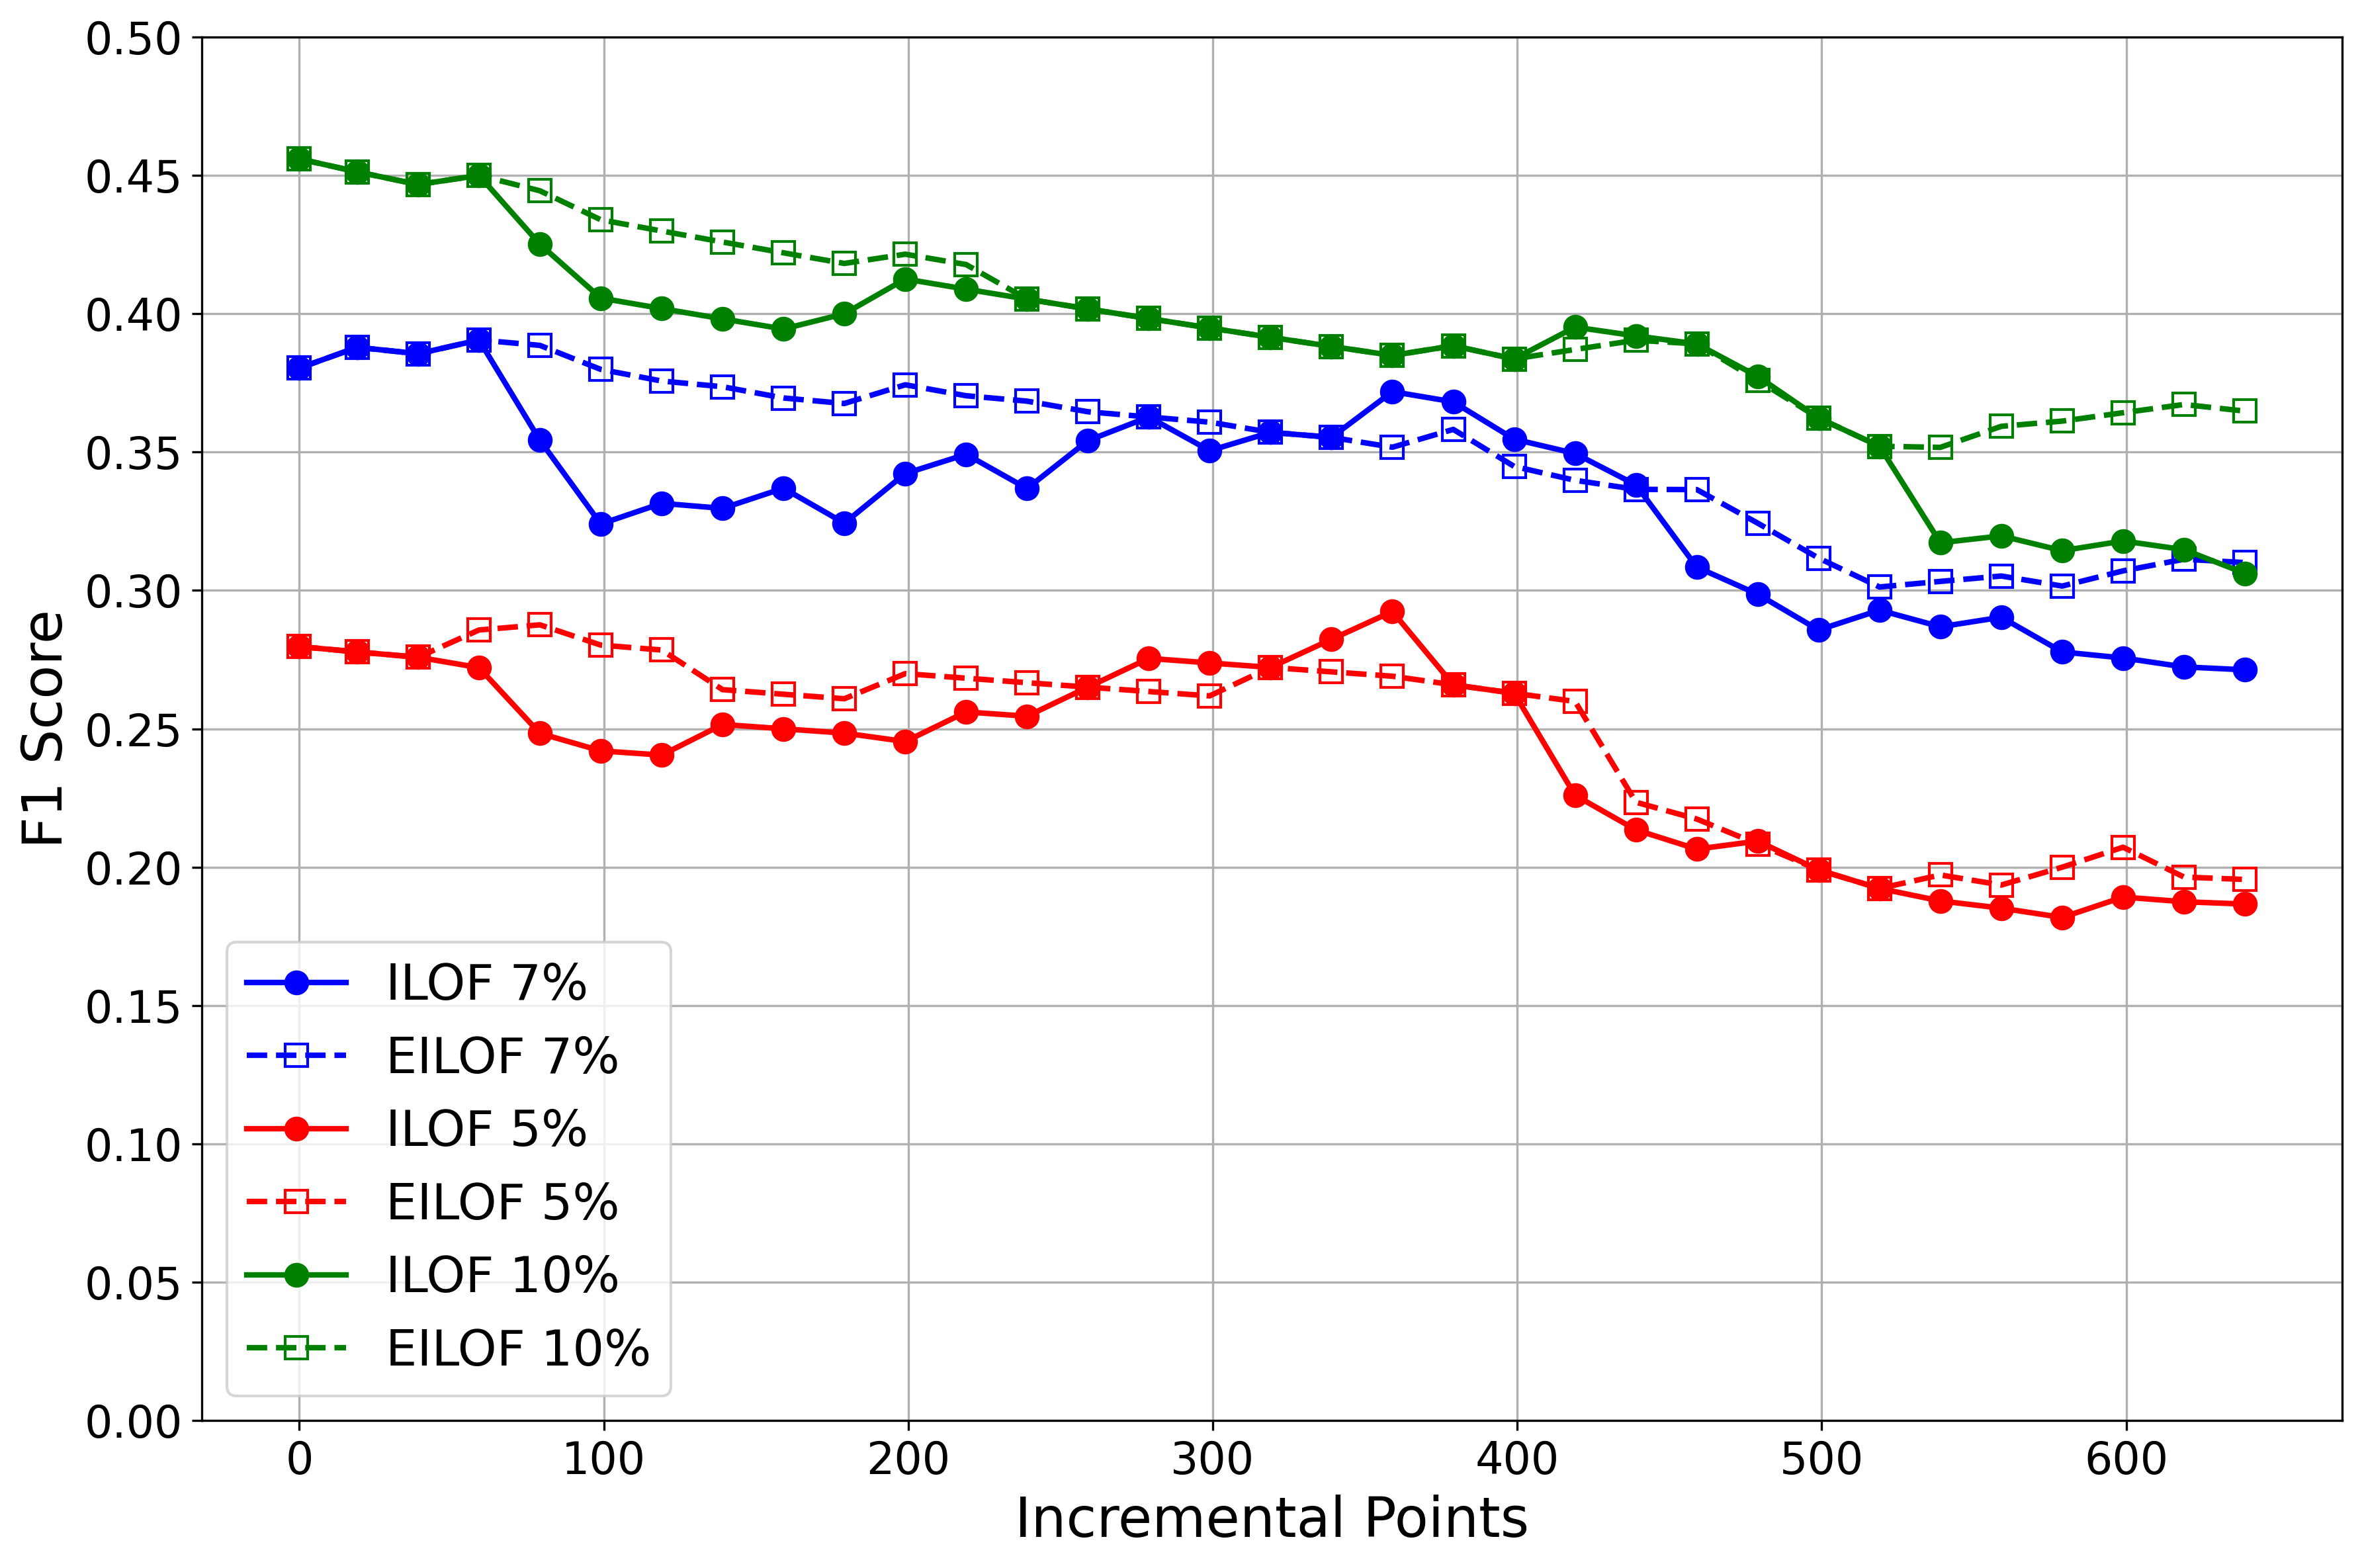

In [ ]:
x = range(len(f1_new_list7))

# Select key points every 20th point for clarity
key_points = np.insert(np.arange(19, len(f1_new_list7), 20), 0, 0)
plt.figure(figsize=(12, 8), dpi=300)
# Plotting ILOF 7% and EILOF 7% with different markers
plt.plot(key_points, np.array(f1_list7), label='ILOF 7%', marker='o', color='blue', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list7)[key_points], label='EILOF 7%', marker='s', color='blue', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)

# Plotting ILOF 5% and EILOF 5% with different markers
plt.plot(key_points, np.array(f1_list5), label='ILOF 5%', marker='o', color='red', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list5)[key_points], label='EILOF 5%', marker='s', color='red', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)

# Plotting ILOF 10% and EILOF 10% with different markers
plt.plot(key_points, np.array(f1_list10), label='ILOF 10%', marker='o', color='green', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list10)[key_points], label='EILOF 10%', marker='s', color='green', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)
plt.xlabel('Incremental Points', fontsize=20)
plt.ylabel('F1 Score', fontsize=20)
plt.legend(fontsize=18, loc='lower left')
plt.xticks(fontsize=16)
plt.yticks(np.arange(0, 0.55, 0.05), fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300)
plt.show()

## Fig. 10(b)

### Incremental LOF Thresholding with 5% Outlier Detection and $k$ = 100

In [ ]:
test_index = range(0,640)
k = 100
f1_list5 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    # Calculate the threshold as the 93rd percentile of LOF values
    threshold_incremental_new = np.percentile(lof_og, 95)

    # Classify points based on the threshold
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list5.append(f1)
f1_list5

[0.5034965034965035,
 0.5138888888888888,
 0.5241379310344828,
 0.5170068027210885,
 0.47058823529411764,
 0.43312101910828027,
 0.4430379746835443,
 0.4276729559748428,
 0.4125,
 0.40993788819875776,
 0.4049079754601227,
 0.4268292682926829,
 0.42424242424242425,
 0.43373493975903615,
 0.4311377245508982,
 0.44047619047619047,
 0.44970414201183434,
 0.4588235294117647,
 0.4678362573099415,
 0.4508670520231214,
 0.44571428571428573,
 0.4293785310734463,
 0.4157303370786517,
 0.3804347826086957,
 0.36649214659685864,
 0.3482587064676617,
 0.34615384615384615,
 0.3380281690140845,
 0.3333333333333333,
 0.33636363636363636,
 0.34234234234234234,
 0.33035714285714285,
 0.3288888888888889]

### Incremental LOF Thresholding with 7% Outlier Detection and $k$ = 100

In [ ]:
test_index = range(0,640)
k = 100
f1_list7 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    # Calculate the threshold as the 93rd percentile of LOF values
    threshold_incremental_new = np.percentile(lof_og, 93)

    # Classify points based on the threshold
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list7.append(f1)
f1_list7

[0.6503067484662577,
 0.6666666666666666,
 0.6746987951807228,
 0.6863905325443787,
 0.6285714285714286,
 0.5698324022346368,
 0.574585635359116,
 0.5714285714285714,
 0.5652173913043478,
 0.5621621621621622,
 0.5561497326203209,
 0.5714285714285714,
 0.5789473684210527,
 0.59375,
 0.6010362694300518,
 0.6185567010309279,
 0.6326530612244898,
 0.6294416243654822,
 0.6432160804020101,
 0.6368159203980099,
 0.6305418719211823,
 0.6116504854368932,
 0.6086956521739131,
 0.5233644859813084,
 0.45248868778280543,
 0.4069264069264069,
 0.39330543933054396,
 0.4016393442622951,
 0.4032258064516129,
 0.40476190476190477,
 0.4094488188976378,
 0.4046692607003891,
 0.40310077519379844]

### Incremental LOF Thresholding with 10% Outlier Detection and $k$ = 100

In [ ]:
test_index = range(0,640)
k = 100
f1_list10 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    threshold_incremental_new = np.percentile(lof_og, 90)

    # Classify points based on the threshold
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list10.append(f1)
f1_list10

[0.7668393782383419,
 0.7794871794871795,
 0.7715736040609137,
 0.78,
 0.7729468599033816,
 0.7547169811320755,
 0.7570093457943925,
 0.75,
 0.7522935779816514,
 0.7454545454545455,
 0.7533632286995515,
 0.7644444444444445,
 0.7577092511013216,
 0.759825327510917,
 0.7532467532467533,
 0.7553648068669528,
 0.7574468085106383,
 0.759493670886076,
 0.7531380753138075,
 0.743801652892562,
 0.7428571428571429,
 0.7338709677419355,
 0.728,
 0.6926070038910506,
 0.5962264150943396,
 0.4492753623188406,
 0.4225352112676056,
 0.4206896551724138,
 0.40816326530612246,
 0.39464882943143814,
 0.3973509933774834,
 0.4,
 0.3973941368078176]

### EILOF Thresholding with 5% Outlier Detection and $k$ = 100

In [ ]:
test_index = range(640)
k = 100
f1_new_list5 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])

    # Calculate threshold using the 95th percentile of LOF scores
    threshold_incremental = np.percentile(model.lof_scores, 95)
    predicted_labels_inc = (model.lof_scores > threshold_incremental).astype(int)
    labels_update_inc = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update_inc, predicted_labels_inc)
    f1_new_list5.append(f1)
f1_new_list5

[0.5034965034965035,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5138888888888888,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5241379310344828,
 0.5342465753424658,
 0.5342465753424658,
 0.5342465753424658,
 0.5342465753424658,
 0.5342465753424658,
 0.5342465753424658,
 0.5306122448

### EILOF Thresholding with 7% Outlier Detection and $k$ = 100

In [ ]:
test_index = range(640)
k = 100
f1_new_list7 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])
    threshold_incremental = np.percentile(model.lof_scores, 93)
    predicted_labels_inc = (model.lof_scores > threshold_incremental).astype(int)
    labels_update_inc = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update_inc, predicted_labels_inc)
    f1_new_list7.append(f1)
f1_new_list7

[0.6503067484662577,
 0.6585365853658537,
 0.6585365853658537,
 0.6585365853658537,
 0.6585365853658537,
 0.6585365853658537,
 0.6585365853658537,
 0.6585365853658537,
 0.6585365853658537,
 0.6585365853658537,
 0.6585365853658537,
 0.6585365853658537,
 0.6585365853658537,
 0.6585365853658537,
 0.6585365853658537,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6746987951807228,
 0.6746987951807228,
 0.6746987951807228,
 0.6746987951807228,
 0.6746987951807228,
 0.6746987951807228,
 0.6746987951807228,
 0.6746987951807228,
 0.6746987951807228,
 0.6746987951807228,
 0.6746987951807228,
 0.6746987951807228,
 0.6746987951807228,
 0.6746987951807228,
 0.6826347305389222,
 0.6826347305389222,
 0.6826347305389222,
 0.6826347305389222,
 0.6785714285

### EILOF Thresholding with 10% Outlier Detection and $k$ = 100

In [ ]:
test_index = range(640)
k = 100
f1_new_list10 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]
    model.update([new_point])
    threshold_incremental = np.percentile(model.lof_scores, 90)
    predicted_labels_inc = (model.lof_scores > threshold_incremental).astype(int)
    labels_update_inc = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update_inc, predicted_labels_inc)
    f1_new_list10.append(f1)
f1_new_list10

[0.7668393782383419,
 0.7731958762886598,
 0.7731958762886598,
 0.7731958762886598,
 0.7731958762886598,
 0.7731958762886598,
 0.7731958762886598,
 0.7731958762886598,
 0.7731958762886598,
 0.7731958762886598,
 0.7731958762886598,
 0.7794871794871795,
 0.7794871794871795,
 0.7794871794871795,
 0.7794871794871795,
 0.7794871794871795,
 0.7794871794871795,
 0.7794871794871795,
 0.7794871794871795,
 0.7794871794871795,
 0.7794871794871795,
 0.7755102040816326,
 0.7755102040816326,
 0.7755102040816326,
 0.7755102040816326,
 0.7755102040816326,
 0.7755102040816326,
 0.7755102040816326,
 0.7755102040816326,
 0.7755102040816326,
 0.7755102040816326,
 0.7715736040609137,
 0.7715736040609137,
 0.7715736040609137,
 0.7715736040609137,
 0.7715736040609137,
 0.7715736040609137,
 0.7715736040609137,
 0.7715736040609137,
 0.7715736040609137,
 0.7715736040609137,
 0.7777777777777778,
 0.7777777777777778,
 0.7777777777777778,
 0.7777777777777778,
 0.7777777777777778,
 0.7777777777777778,
 0.7738693467

### Fig. 10 (b): Comparison of EILOF and ILOF performance on Credit Fraud when $k$ = 100

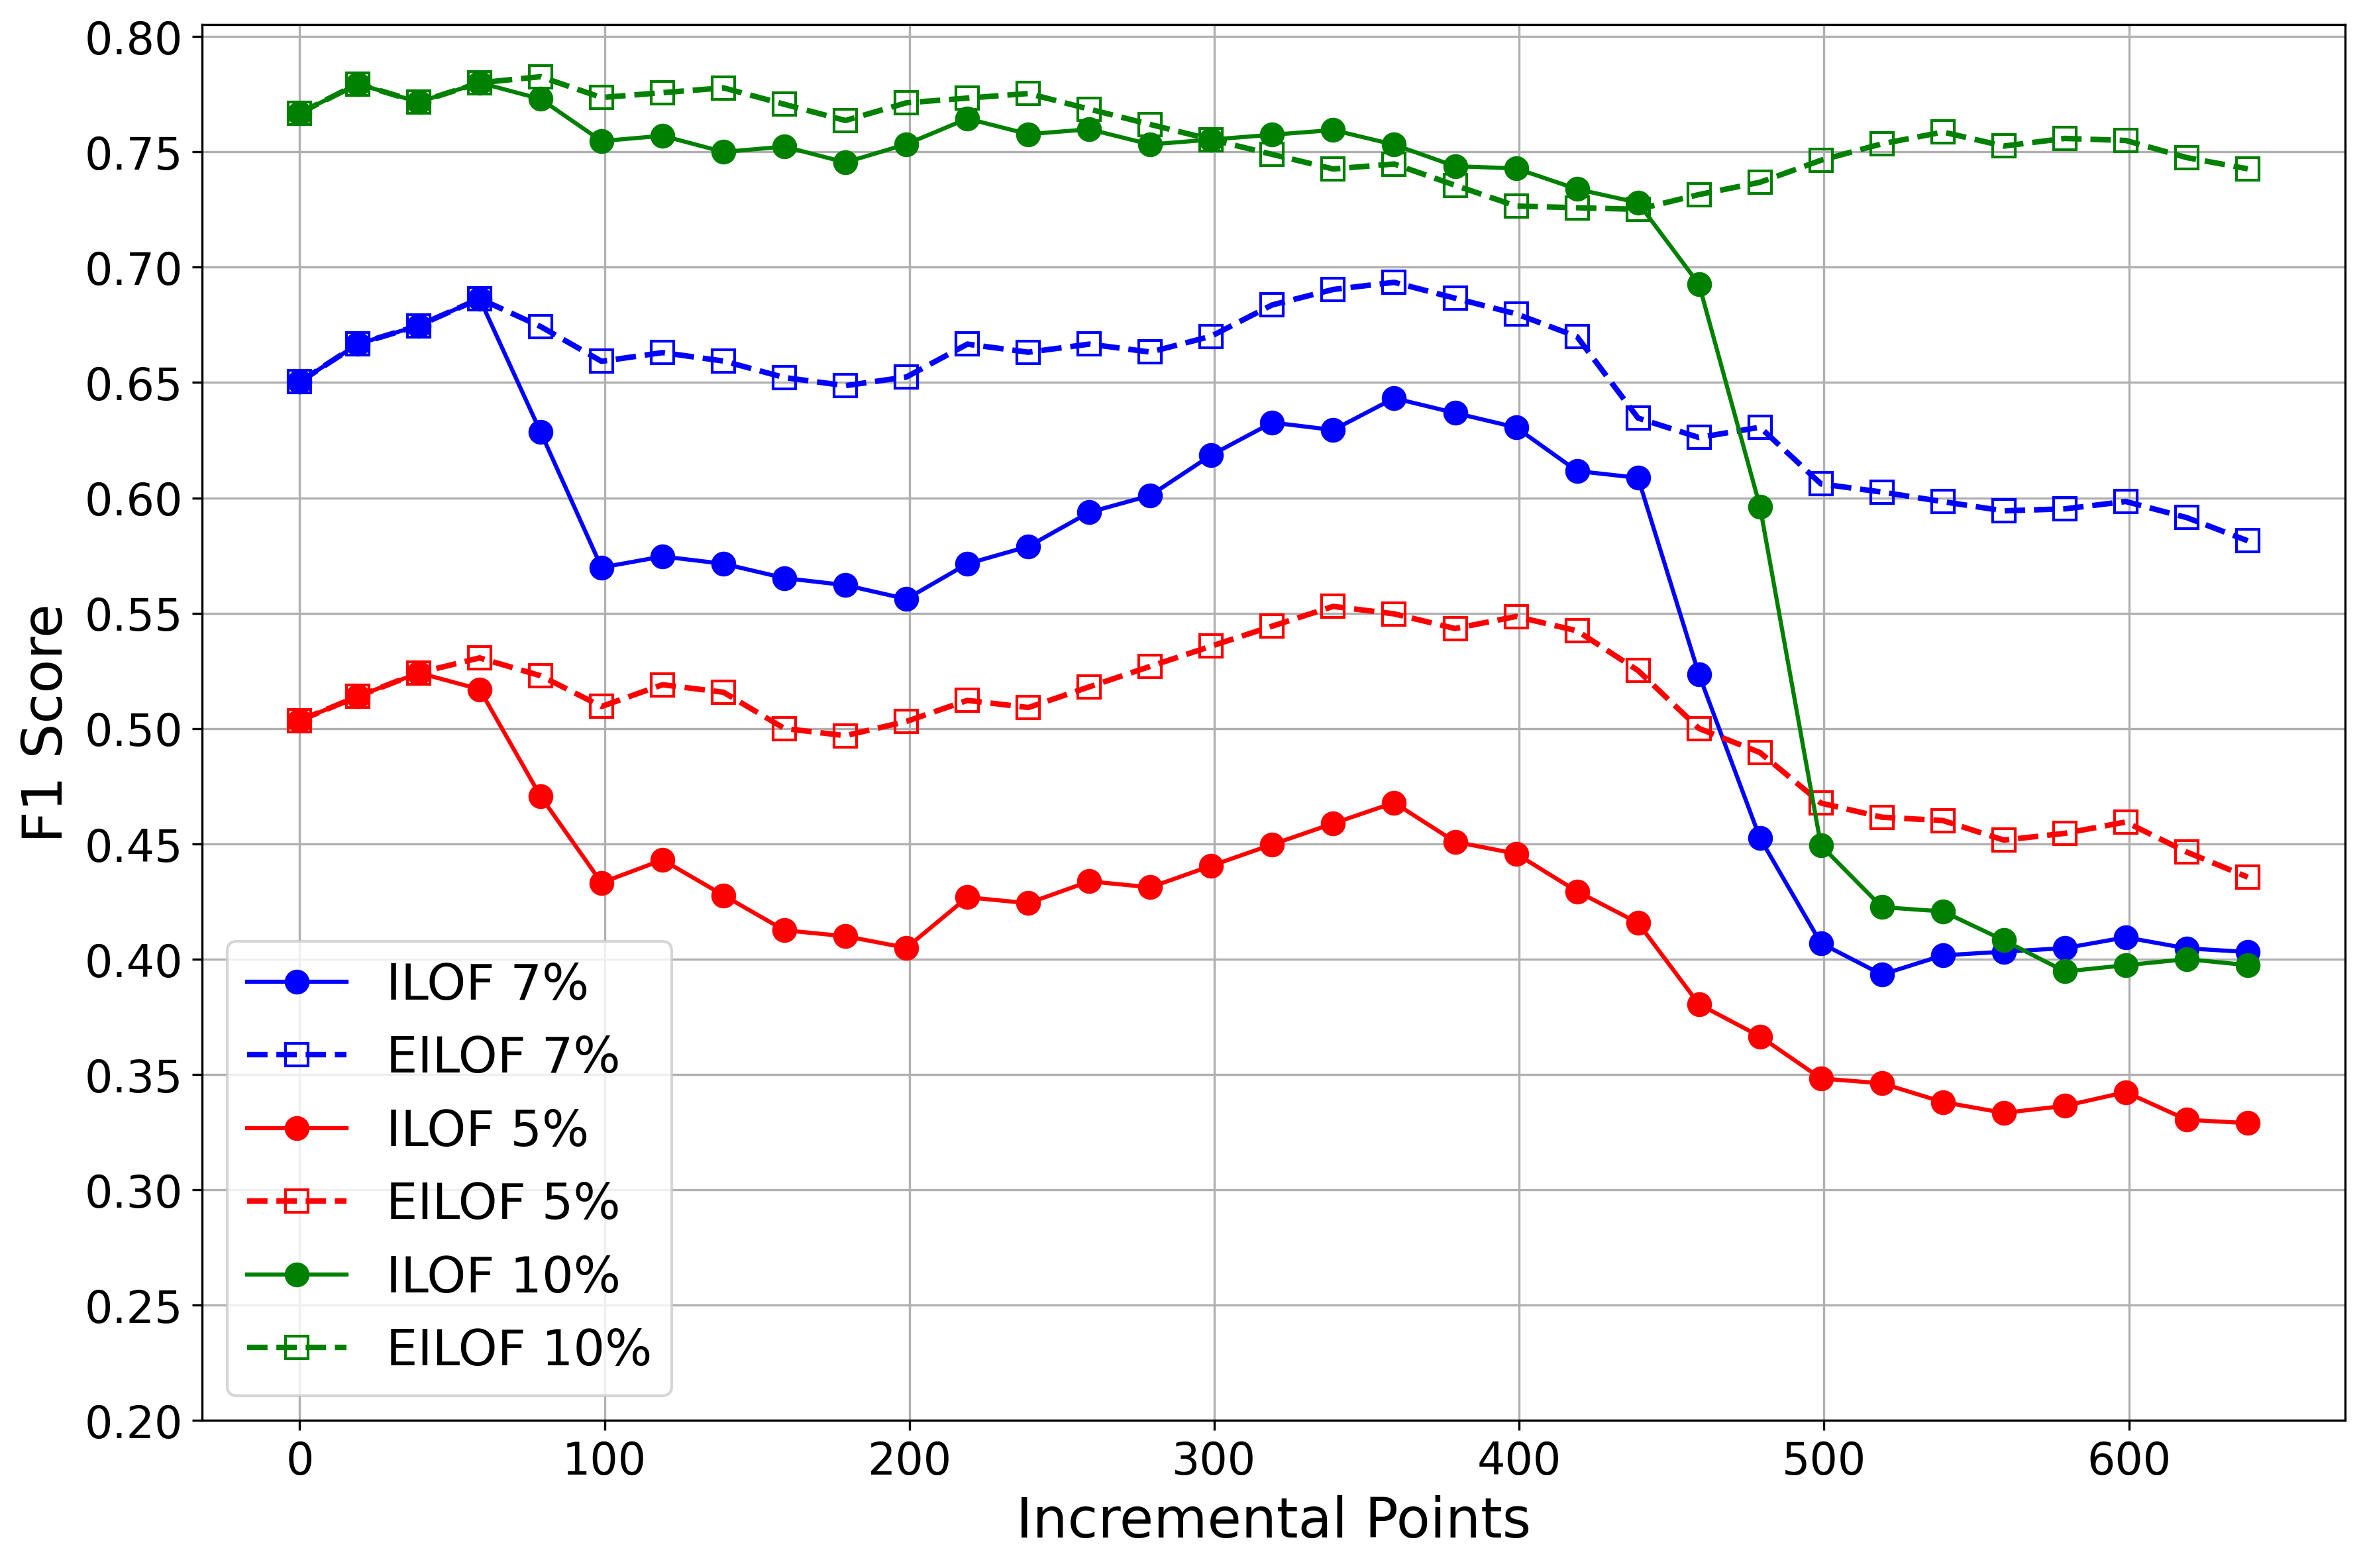

In [ ]:
x = range(len(f1_new_list7))

# Select key points every 20th point for clarity
key_points = np.insert(np.arange(19, len(f1_new_list7), 20), 0, 0)
plt.figure(figsize=(12, 8), dpi=300)

# Plotting ILOF 7% and EILOF 7% with different markers
plt.plot(key_points, np.array(f1_list7), label='ILOF 7%', marker='o', color='blue', markersize=8, linestyle='-', linewidth=1.5)
plt.plot(key_points, np.array(f1_new_list7)[key_points], label='EILOF 7%', marker='s', color='blue', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)

# Plotting ILOF 5% and EILOF 5% with different markers
plt.plot(key_points, np.array(f1_list5), label='ILOF 5%', marker='o', color='red', markersize=8, linestyle='-', linewidth=1.5)
plt.plot(key_points, np.array(f1_new_list5)[key_points], label='EILOF 5%', marker='s', color='red', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)

# Plotting ILOF 10% and EILOF 10% with different markers
plt.plot(key_points, np.array(f1_list10), label='ILOF 10%', marker='o', color='green', markersize=8, linestyle='-', linewidth=1.5)
plt.plot(key_points, np.array(f1_new_list10)[key_points], label='EILOF 10%', marker='s', color='green', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)
plt.xlabel('Incremental Points', fontsize=20)
plt.ylabel('F1 Score', fontsize=20)
plt.legend(fontsize=18, loc='lower left')
plt.xticks(fontsize=16)
plt.yticks(np.arange(0.20, 0.85, 0.05), fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300)
plt.show()

## Fig. 10(c)

### Incremental LOF Thresholding with 5% Outlier Detection and $k$ = 150

In [ ]:
test_index = range(0,640)
k = 150
f1_list5 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    threshold_incremental_new = np.percentile(lof_og, 95)

    # Classify points based on the threshold
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list5.append(f1)
f1_list5

[0.6153846153846154,
 0.6111111111111112,
 0.6206896551724138,
 0.6122448979591837,
 0.5882352941176471,
 0.5732484076433121,
 0.5822784810126582,
 0.5786163522012578,
 0.575,
 0.5714285714285714,
 0.5766871165644172,
 0.573170731707317,
 0.5696969696969697,
 0.5662650602409639,
 0.5748502994011976,
 0.5833333333333334,
 0.591715976331361,
 0.6,
 0.6081871345029239,
 0.6127167630057804,
 0.6171428571428571,
 0.6101694915254238,
 0.5955056179775281,
 0.5760869565217391,
 0.5863874345549738,
 0.5472636815920398,
 0.5192307692307693,
 0.49765258215962443,
 0.48148148148148145,
 0.4818181818181818,
 0.4864864864864865,
 0.48214285714285715,
 0.48]

### Incremental LOF Thresholding with 7% Outlier Detection and $k$ = 150

In [ ]:
test_index = range(0,640)
k = 150
f1_list7 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    threshold_incremental_new = np.percentile(lof_og, 93)

    # Classify points based on the threshold
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list7.append(f1)
f1_list7

[0.6871165644171779,
 0.703030303030303,
 0.6987951807228916,
 0.7100591715976331,
 0.6971428571428572,
 0.6927374301675978,
 0.7071823204419889,
 0.7032967032967034,
 0.6956521739130435,
 0.6918918918918919,
 0.6951871657754011,
 0.708994708994709,
 0.7052631578947368,
 0.7083333333333334,
 0.7150259067357513,
 0.7216494845360825,
 0.7142857142857143,
 0.7106598984771574,
 0.7135678391959799,
 0.7164179104477612,
 0.7093596059113301,
 0.7087378640776699,
 0.6956521739130435,
 0.7102803738317757,
 0.7239819004524887,
 0.6926406926406926,
 0.6861924686192469,
 0.680327868852459,
 0.6693548387096774,
 0.6428571428571429,
 0.6377952755905512,
 0.6303501945525292,
 0.627906976744186]

### Incremental LOF Thresholding with 10% Outlier Detection and $k$ = 150

In [ ]:
test_index = range(0,640)
k = 150
f1_list10 = []
Accuracy = []
data_copy = selected_data
lof_list = []
reach_list = []
lrd_list = []


for i in np.insert(np.arange(19, len(test_index), 20), 0, 0):
    data_copy = np.concatenate((selected_data, unselected_data[:i]))
    dist_og = cdist(data_copy, data_copy, 'euclidean')
    neighbors_og = k_nearest_neighbors(dist_og, k)
    k_th_dist_og = np.sort(dist_og, axis=1)[:, k]
    reachability_dist = reachability_distance(dist_og, k) #orginal reachability dis
    lrd_og = local_reachability_density(reachability_dist, neighbors_og) #orginal lrd
    lof_og = lof_srs(dist_og, neighbors_og, lrd_og, k)
    threshold_incremental_new = np.percentile(lof_og, 90)

    # Classify points based on the threshold
    predicted_labels = (lof_og > threshold_incremental_new).astype(int)
    selected_labels_1600 = np.concatenate((selected_labels, unselected_labels[:i]))
    f1 = f1_score(selected_labels_1600, predicted_labels)
    accuracy = accuracy_score(selected_labels_1600, predicted_labels)
    f1_list10.append(f1)
f1_list10

[0.7875647668393783,
 0.7897435897435897,
 0.7817258883248731,
 0.78,
 0.8019323671497585,
 0.8018867924528302,
 0.8037383177570093,
 0.7962962962962963,
 0.7889908256880734,
 0.7818181818181819,
 0.7802690582959642,
 0.7733333333333333,
 0.775330396475771,
 0.7685589519650655,
 0.7705627705627706,
 0.7725321888412017,
 0.7659574468085106,
 0.759493670886076,
 0.7531380753138075,
 0.7520661157024794,
 0.7428571428571429,
 0.7419354838709677,
 0.736,
 0.7470817120622568,
 0.7471698113207547,
 0.782608695652174,
 0.7887323943661971,
 0.7862068965517242,
 0.782312925170068,
 0.7892976588628763,
 0.7880794701986755,
 0.7868852459016393,
 0.7882736156351792]

### EILOF Thresholding with 5% Outlier Detection and $k$ = 150

In [ ]:
# Initialize variables
test_index = range(640)
k = 150
f1_new_list5 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]
    # Update the model incrementally with the new point
    model.update([new_point])
    threshold_incremental = np.percentile(model.lof_scores, 95)
    predicted_labels_inc = (model.lof_scores > threshold_incremental).astype(int)
    labels_update_inc = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update_inc, predicted_labels_inc)
    f1_new_list5.append(f1)
f1_new_list5

[0.6153846153846154,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6111111111111112,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6206896551724138,
 0.6164383561643836,
 0.6164383561643836,
 0.6164383561643836,
 0.6164383561643836,
 0.6164383561643836,
 0.6164383561643836,
 0.6122448979

### EILOF Thresholding with 7% Outlier Detection and $k$ = 150

In [ ]:
test_index = range(640)
k = 150
f1_new_list7 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])
    threshold_incremental = np.percentile(model.lof_scores, 93)
    predicted_labels_inc = (model.lof_scores > threshold_incremental).astype(int)
    labels_update_inc = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update_inc, predicted_labels_inc)
    f1_new_list7.append(f1)
f1_new_list7

[0.6871165644171779,
 0.6951219512195121,
 0.6951219512195121,
 0.6951219512195121,
 0.6951219512195121,
 0.6951219512195121,
 0.6951219512195121,
 0.6951219512195121,
 0.6951219512195121,
 0.6951219512195121,
 0.6951219512195121,
 0.6951219512195121,
 0.6951219512195121,
 0.6951219512195121,
 0.6951219512195121,
 0.6909090909090909,
 0.6909090909090909,
 0.6909090909090909,
 0.6909090909090909,
 0.6909090909090909,
 0.6909090909090909,
 0.6909090909090909,
 0.6909090909090909,
 0.6909090909090909,
 0.6909090909090909,
 0.6909090909090909,
 0.6909090909090909,
 0.6909090909090909,
 0.6909090909090909,
 0.6987951807228916,
 0.6987951807228916,
 0.6987951807228916,
 0.6987951807228916,
 0.6987951807228916,
 0.6987951807228916,
 0.6987951807228916,
 0.6987951807228916,
 0.6987951807228916,
 0.6987951807228916,
 0.6987951807228916,
 0.6987951807228916,
 0.6987951807228916,
 0.6987951807228916,
 0.7065868263473054,
 0.7065868263473054,
 0.7065868263473054,
 0.7065868263473054,
 0.7023809523

### EILOF Thresholding with 10% Outlier Detection and $k$ = 150

In [ ]:
test_index = range(640)
k = 150
f1_new_list7 = []

# Initialize EILOF model
model = EILOF(k=k)

# Fit the model on the selected data
model.fit(selected_data)

# Loop through the test indices
for i in test_index:
    # Get the new point to add
    new_point = unselected_data[i]

    # Update the model incrementally with the new point
    model.update([new_point])
    threshold_incremental = np.percentile(model.lof_scores, 90)
    predicted_labels_inc = (model.lof_scores > threshold_incremental).astype(int)
    labels_update_inc = np.append(selected_labels, unselected_labels[:i+1])
    f1 = f1_score(labels_update_inc, predicted_labels_inc)
    f1_new_list7.append(f1)
f1_new_list7

[0.7875647668393783,
 0.7835051546391752,
 0.7835051546391752,
 0.7835051546391752,
 0.7835051546391752,
 0.7835051546391752,
 0.7835051546391752,
 0.7835051546391752,
 0.7835051546391752,
 0.7835051546391752,
 0.7835051546391752,
 0.7897435897435897,
 0.7897435897435897,
 0.7897435897435897,
 0.7897435897435897,
 0.7897435897435897,
 0.7897435897435897,
 0.7897435897435897,
 0.7897435897435897,
 0.7897435897435897,
 0.7897435897435897,
 0.7857142857142857,
 0.7857142857142857,
 0.7857142857142857,
 0.7857142857142857,
 0.7857142857142857,
 0.7857142857142857,
 0.7857142857142857,
 0.7857142857142857,
 0.7857142857142857,
 0.7857142857142857,
 0.7817258883248731,
 0.7817258883248731,
 0.7817258883248731,
 0.7817258883248731,
 0.7817258883248731,
 0.7817258883248731,
 0.7817258883248731,
 0.7817258883248731,
 0.7817258883248731,
 0.7817258883248731,
 0.7777777777777778,
 0.7777777777777778,
 0.7777777777777778,
 0.7777777777777778,
 0.7777777777777778,
 0.7777777777777778,
 0.7839195979

### Fig. 10 (c): Comparison of EILOF and ILOF performance on Credit Fraud when $k$ = 150

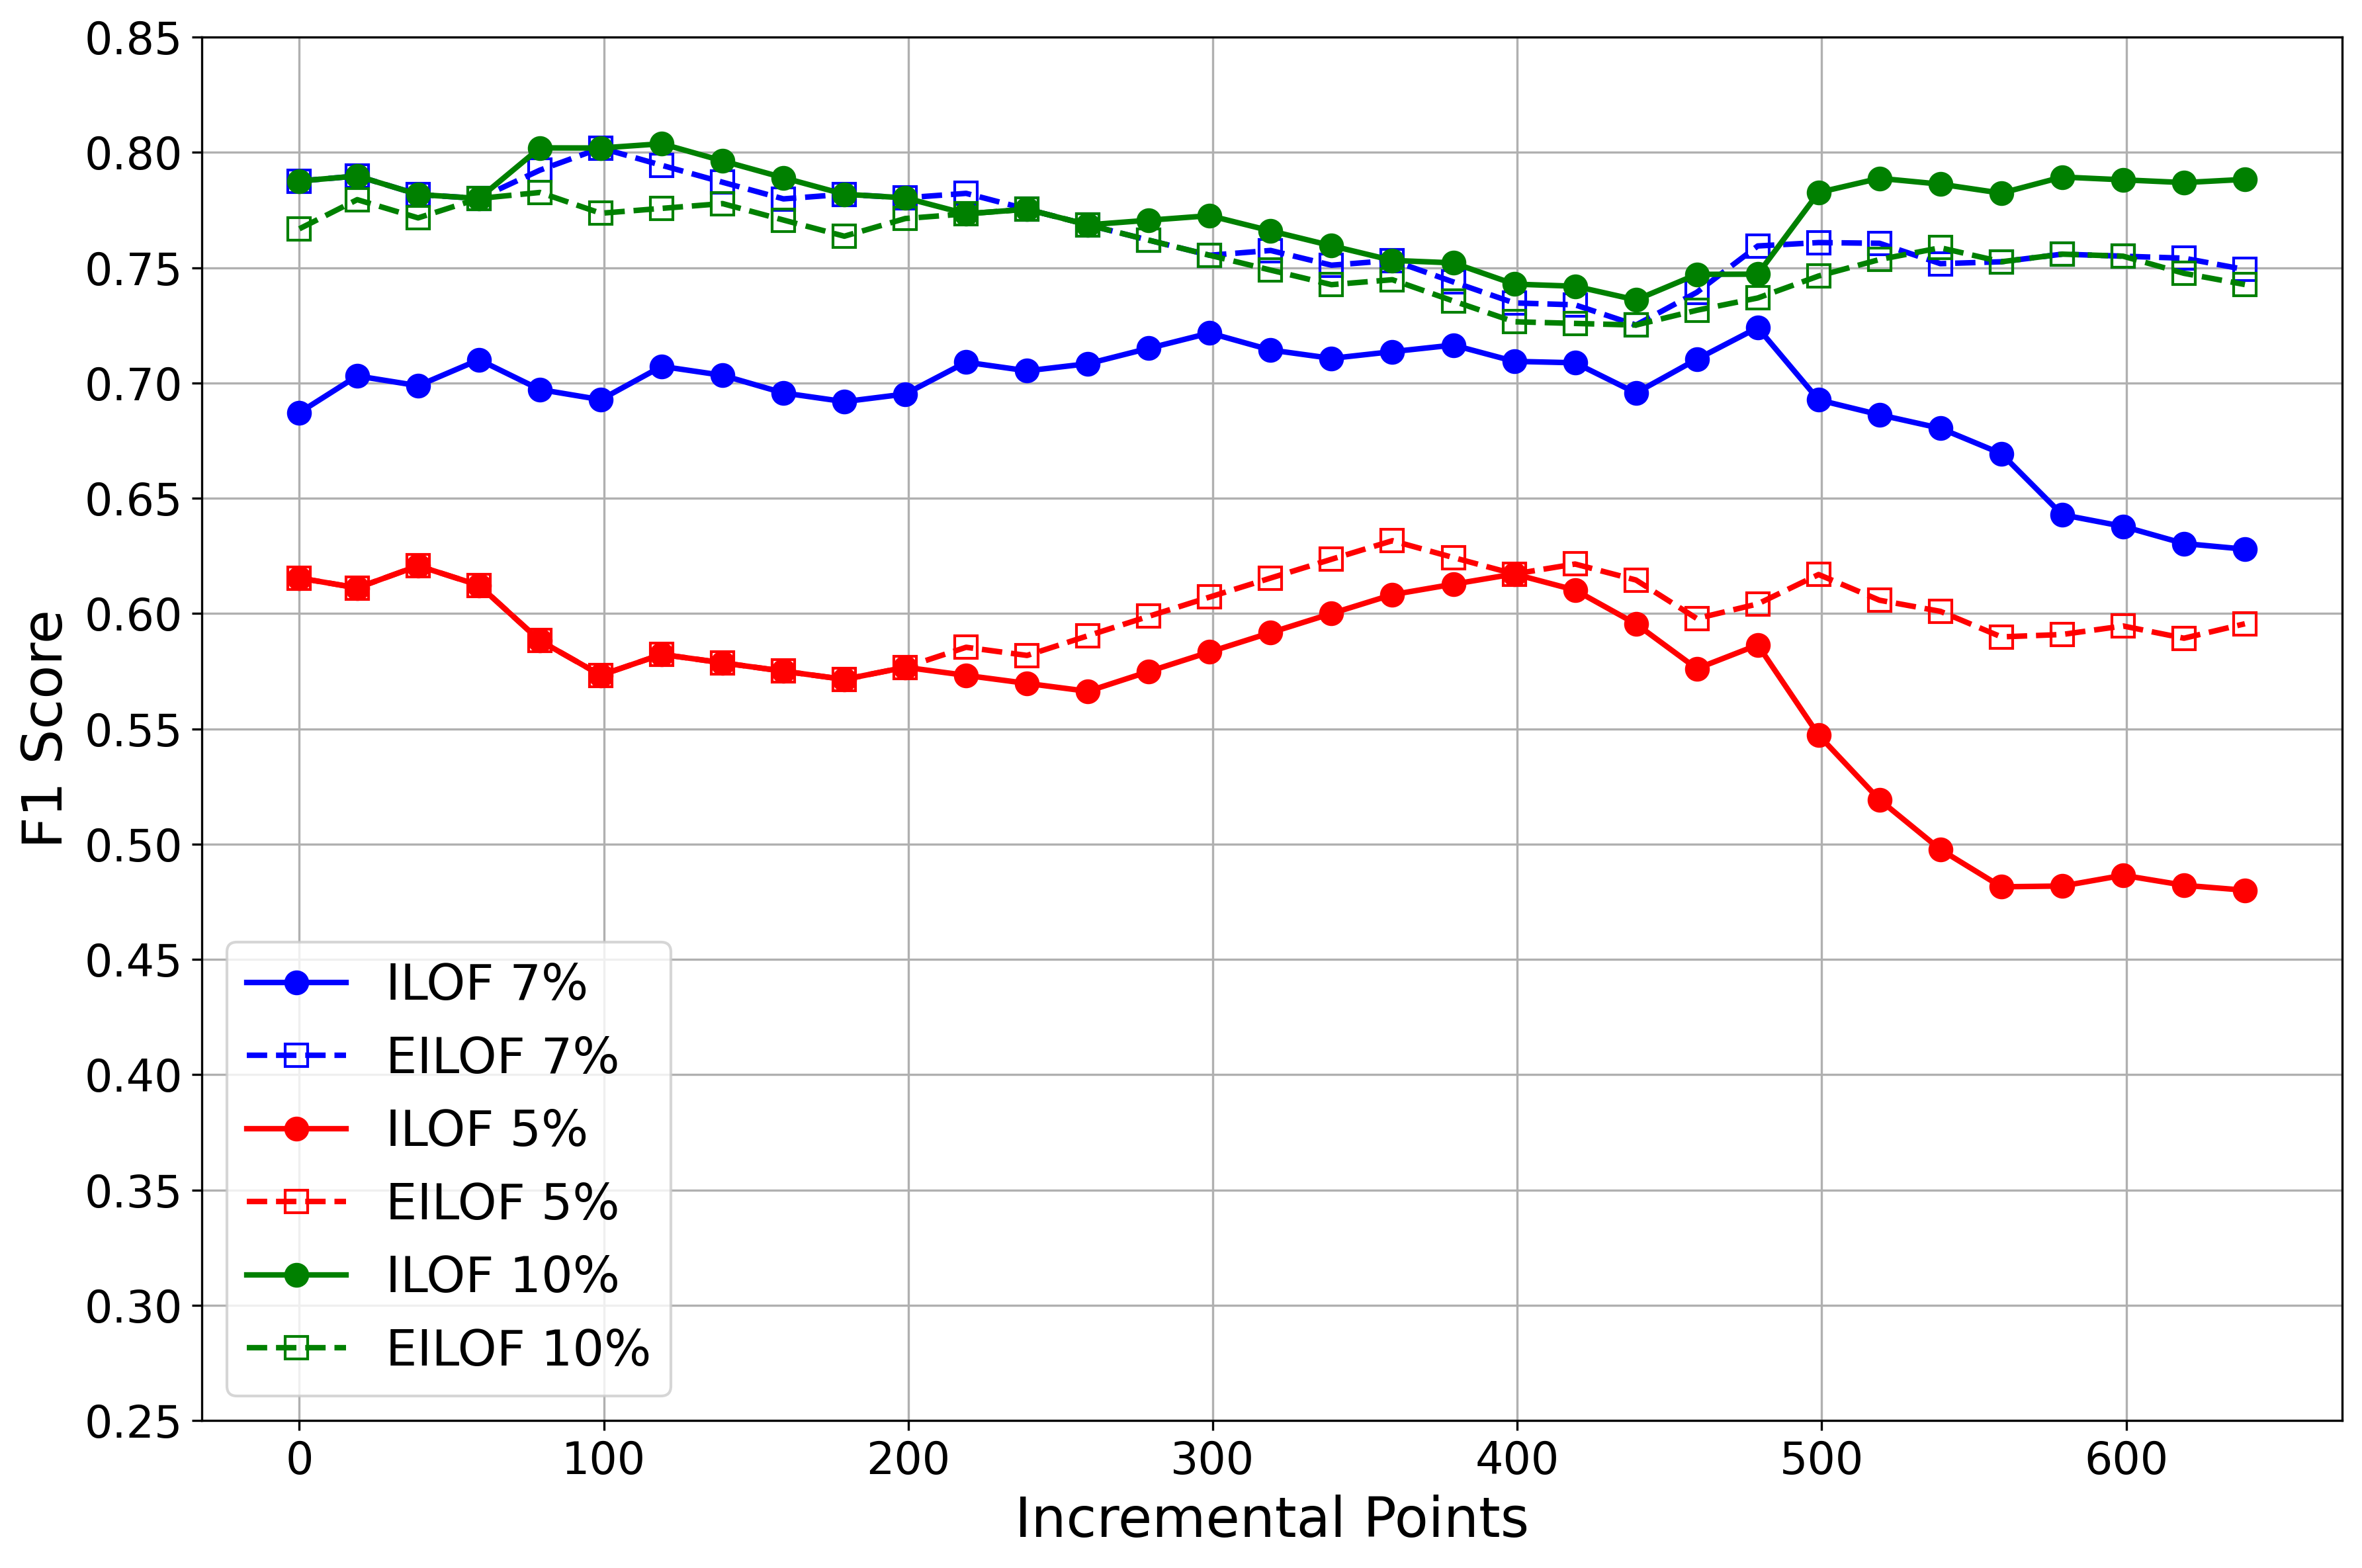

In [ ]:
x = range(len(f1_new_list7))

# Select key points every 20th point for clarity
key_points = np.insert(np.arange(19, len(f1_new_list7), 20), 0, 0)
plt.figure(figsize=(12, 8), dpi=300)
# Plotting ILOF 7% and EILOF 7% with different markers
plt.plot(key_points, np.array(f1_list7), label='ILOF 7%', marker='o', color='blue', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list7)[key_points], label='EILOF 7%', marker='s', color='blue', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)
# Plotting ILOF 5% and EILOF 5% with different markers
plt.plot(key_points, np.array(f1_list5), label='ILOF 5%', marker='o', color='red', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list5)[key_points], label='EILOF 5%', marker='s', color='red', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)
# Plotting ILOF 10% and EILOF 10% with different markers
plt.plot(key_points, np.array(f1_list10), label='ILOF 10%', marker='o', color='green', markersize=8, linestyle='-', linewidth=2)
plt.plot(key_points, np.array(f1_new_list10)[key_points], label='EILOF 10%', marker='s', color='green', linestyle='dashed', markersize=8, markerfacecolor='none', linewidth=2)
plt.xlabel('Incremental Points', fontsize=20)
plt.ylabel('F1 Score', fontsize=20)
plt.legend(fontsize=18, loc='lower left')
plt.xticks(fontsize=16)
plt.yticks(np.arange(0.25, 0.90, 0.05), fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300)
plt.show()